# DA for DMD kol_model.py

In [1]:
import random
from time import perf_counter

import torch
from torch import nn
import torch.nn.functional as F
import numpy
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = True


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)


def set_device():
    """
    Use CPU if cuda device is not available
    setup tf32 for faster GPU computation
    """
    if torch.cuda.device_count() == 0:
        return "cpu"
    torch.set_float32_matmul_precision("high")
    return "cuda"


set_seed(42)
g = torch.Generator()
g.manual_seed(42)
device = set_device()
device

mkdir -p failed for path /home/wy524/.config/matplotlib: [Errno 13] Permission denied: '/home/wy524'


Matplotlib created a temporary cache directory at /tmp/matplotlib-pye9c88x because there was an issue with the default path (/home/wy524/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


'cpu'

In [2]:
from kol_model_FTF import KOL_C_FORWARD

forward_model = KOL_C_FORWARD()
forward_model.load_state_dict(torch.load('../../../../results/CAE_DMD/KMG/kol_model_weights_FTF/forward_model.pt', weights_only=True, map_location=device))
forward_model.C_forward = torch.load('../../../../results/CAE_DMD/KMG/kol_model_weights_FTF/C_forward.pt', weights_only=True, map_location=device)
forward_model.eval()

print(forward_model)

KOL_C_FORWARD(
  (K_S): KOL_K_S(
    (input_proj): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (downsample): Conv2d(16, 16, kernel_size=(4, 4), stride=(4, 4))
    (factorized_layers): ModuleList(
      (0): FactorizedBlock(
        (attn): FactorizedAttention2D(
          (to_qkv): Linear(in_features=16, out_features=48, bias=False)
          (to_out): Linear(in_features=16, out_features=16, bias=True)
          (rope): RoPE2D()
          (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        )
        (mlp): Sequential(
          (0): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=16, out_features=32, bias=True)
          (2): GELU(approximate='none')
          (3): Linear(in_features=32, out_features=16, bias=True)
        )
      )
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (final_proj): Linear(in_features=4096, out_features=512, bias=True)
    (dropout): Dropout(p=0.9, inplace=False)
  )
 

In [3]:
import os
import sys
current_directory = os.getcwd()
src_directory = os.path.abspath(os.path.join(current_directory, "..", "..", "..", ".."))
sys.path.append(src_directory)

from src.utils.Dataset import KolDynamicsDataset

foward_step = 12

val_idx = 3

kol_train_dataset = KolDynamicsDataset(data_path="../../../../data/kolmogorov/RE40_T20/kolmogorov_train_data.npy",
                seq_length = foward_step,
                mean=None,
                std=None)
    
kol_val_dataset = KolDynamicsDataset(data_path="../../../../data/kolmogorov/RE40_T20/kolmogorov_val_data.npy",
            seq_length = foward_step,
            mean=kol_train_dataset.mean,
            std=kol_train_dataset.std)

denorm = kol_val_dataset.denormalizer()

Loaded Kolmogorov data with shape: (40, 1000, 1, 64, 64)


dataset total samples: 39520
Loaded Kolmogorov data with shape: (10, 1000, 1, 64, 64)
dataset total samples: 9880


In [4]:
groundtruth = kol_val_dataset.data[val_idx, ...]
groundtruth = torch.from_numpy(groundtruth)

groundtruth.shape

torch.Size([1000, 1, 64, 64])

In [5]:
def visualize_image(image_2d, title='Image', cmap='viridis'):
    if isinstance(image_2d, torch.Tensor):
        image_2d = image_2d.detach().cpu().numpy()

    plt.figure(figsize=(2, 2))
    plt.imshow(image_2d, cmap=cmap)
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
import os
import sys
import numpy as np

class UnifiedDynamicSparseObservationHandler:
    def __init__(self, max_obs_ratio: float = 0.15, min_obs_ratio: float = 0.05, seed: int = 42):
        self.max_obs_ratio = max_obs_ratio
        self.min_obs_ratio = min_obs_ratio
        self.seed = seed
        self.fixed_positions = None
        self.max_obs_count = 0
        self.time_masks = {}
        
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
    
    def generate_unified_observations(self, image_shape: tuple, time_steps: list) -> int:
        if len(image_shape) == 3:
            C, H, W = image_shape
        else:
            raise ValueError(f"Expected 3D image shape (C, H, W), got {image_shape}")
        
        total_pixels = C * H * W
        self.max_obs_count = int(total_pixels * self.max_obs_ratio)
        
        self.fixed_positions = torch.randperm(total_pixels)[:self.max_obs_count]
        print(f"Fixed observation positions generated: {self.max_obs_count} positions")
        
        for i, t in enumerate(time_steps):
            obs_ratio = np.random.uniform(self.min_obs_ratio, self.max_obs_ratio)
            num_valid = int(total_pixels * obs_ratio)
            num_valid = min(num_valid, self.max_obs_count)
            
            valid_indices = torch.randperm(self.max_obs_count)[:num_valid]
            
            self.time_masks[i] = {
                'num_valid': num_valid,
                'valid_indices': valid_indices,
                'obs_ratio': obs_ratio
            }
            
            print(f"Time step {t}: {num_valid}/{self.max_obs_count} observations ({obs_ratio:.3f} ratio)")
        
        return self.max_obs_count
    
    def apply_unified_observation(self, full_image: torch.Tensor, time_step_idx: int) -> torch.Tensor:
        if time_step_idx not in self.time_masks:
            raise ValueError(f"Time step index {time_step_idx} not found in masks")
        
        mask_info = self.time_masks[time_step_idx]
        
        flat_image = full_image.flatten()
        fixed_obs = flat_image[self.fixed_positions]
        
        obs_vector = torch.zeros(self.max_obs_count, device=full_image.device)
        valid_indices = mask_info['valid_indices']
        obs_vector[valid_indices] = fixed_obs[valid_indices]
        
        return obs_vector
    
    def create_block_R_matrix(self, base_variance=1e-3):
        R = torch.eye(self.max_obs_count) * base_variance
        return R
    
    def create_unified_R_matrix(self, base_variance: float = 1e-3, 
                               invalid_variance: float = 1.0) -> torch.Tensor:
        R = torch.eye(self.max_obs_count) * invalid_variance
        
        min_valid = min(mask_info['num_valid'] for mask_info in self.time_masks.values())
        
        R[:min_valid, :min_valid] = torch.eye(min_valid) * base_variance
        
        return R

In [7]:
_global_obs_handler = None
_global_time_idx = 0

def update_observation_time_index(time_idx: int):
    global _global_time_idx
    _global_time_idx = time_idx

### DA

In [8]:
import torchda

In [9]:
obs_handler = UnifiedDynamicSparseObservationHandler(
    max_obs_ratio=0.11, 
    min_obs_ratio=0.09, 
    seed=42
)

In [10]:
start_da_end_idxs = (40, 45, 65)

time_obs = [
    start_da_end_idxs[1],
    start_da_end_idxs[1] + 10,
]
gaps = [10] * (len(time_obs) - 1)

full_y_data = [
    kol_val_dataset.normalize(groundtruth[i+1, ...])
    for i in range(groundtruth.shape[0])
    if i in time_obs
]

full_y_data = torch.cat(full_y_data).to(device)

In [11]:
print(full_y_data.shape)

torch.Size([2, 1, 64, 64])


In [12]:
sample_image_shape = full_y_data[0].shape
max_obs_count = obs_handler.generate_unified_observations(sample_image_shape, range(len(time_obs)))

sparse_y_data = []
for i, full_img in enumerate(full_y_data):
    sparse_obs = obs_handler.apply_unified_observation(full_img, i)
    sparse_y_data.append(sparse_obs)
sparse_y_data = torch.stack(sparse_y_data).to(device)

print(f"Original observation shape: {full_y_data.shape}")
print(f"Dynamic sparse observation shape: {sparse_y_data.shape}")

Fixed observation positions generated: 450 positions
Time step 0: 399/450 observations (0.097 ratio)
Time step 1: 446/450 observations (0.109 ratio)
Original observation shape: torch.Size([2, 1, 64, 64])
Dynamic sparse observation shape: torch.Size([2, 450])


In [13]:
def H_unified(x):
    global _global_time_idx, _global_obs_handler
    
    x_reconstructed = forward_model.K_S_preimage(x)
    sparse_obs = _global_obs_handler.apply_unified_observation(
        x_reconstructed.squeeze(), _global_time_idx
    )
    return sparse_obs.unsqueeze(0)

_global_obs_handler = obs_handler

In [14]:
_global_obs_handler = obs_handler

In [15]:
latent_dim = forward_model.C_forward.shape[0]
B = torch.eye(latent_dim, device=device)

R = obs_handler.create_block_R_matrix(base_variance=1e-3).to(device)

obs_dim = sparse_y_data.shape[1]

print(f"Background covariance B shape: {B.shape}")
print(f"Observation dimension: {obs_dim}")

print(f"R matrix shape: {R.shape}")
print(f"R matrix condition number: {torch.linalg.cond(R):.2e}")
print(f"R matrix rank: {torch.linalg.matrix_rank(R)}")
print(f"R matrix is invertible: {torch.linalg.matrix_rank(R) == R.shape[0]}")

Background covariance B shape: torch.Size([512, 512])
Observation dimension: 450
R matrix shape: torch.Size([450, 450])
R matrix condition number: 1.00e+00


R matrix rank: 450
R matrix is invertible: True


In [16]:
def dmd_warpper(z_t, time_fw=None, *args):
    if time_fw == None:
        if z_t.ndim == 1:
            z_t = z_t.unsqueeze(0)

        z_tp = forward_model.latent_forward(z_t)
        
    else:
        if z_t.ndim == 1:
            z_t = z_t.unsqueeze(0)

        z_tp = torch.empty((time_fw.shape[0], z_t.shape[0], z_t.shape[1]), device=z_t.device)
        
        current_state = forward_model.K_S_preimage(z_t)
        
        for i in range(int(time_fw.shape[0])):
            z_current = forward_model.K_S(current_state)
            z_tp[i] = z_current
            
            if i < int(time_fw.shape[0]) - 1:
                z_next = forward_model.latent_forward(z_current)
                current_state = forward_model.K_S_preimage(z_next)
    
    return z_tp

In [17]:
case_to_run = (
    torchda.CaseBuilder()
    .set_observation_time_steps(time_obs)
    .set_gaps(gaps)
    .set_forward_model(dmd_warpper)
    .set_observation_model(H_unified)
    .set_background_covariance_matrix(B)
    .set_observation_covariance_matrix(R)
    .set_observations(sparse_y_data)
    .set_optimizer_cls(torch.optim.Adam)
    .set_optimizer_args({"lr": 0.05})
    .set_max_iterations(1000)
    .set_algorithm(torchda.Algorithms.Var4D)
    .set_device(torchda.Device.CPU)
    .set_output_sequence_length(1)
)

In [18]:
outs_4d_da = []

start_time = perf_counter()

current_state = kol_val_dataset.normalize(groundtruth[start_da_end_idxs[0]])

for i in range(start_da_end_idxs[0], start_da_end_idxs[-1] + 1):
    print(f"Processing step {i}")
    
    z_current = forward_model.K_S(current_state)
    
    if i == start_da_end_idxs[1]:
        update_observation_time_index(0)
        
        case_to_run.set_background_state(z_current.ravel())
        result = case_to_run.execute()
        z_assimilated = result["assimilated_state"]

        z_assimilated = z_assimilated.unsqueeze(0)
        
        intermediate_results = result["intermediate_results"]
        final_cost = intermediate_results["J"][-1]
        print(f"Final cost function: {final_cost}")
        print(f"Number of iterations: {len(intermediate_results['J'])}")
        
        outs_4d_da.append(z_assimilated)
        
        current_state = forward_model.K_S_preimage(z_assimilated)
    else:
        outs_4d_da.append(z_current)
        
        z_next = dmd_warpper(z_current)
        current_state = forward_model.K_S_preimage(z_next)
    
    print("=" * 50)

print(f"Unified dynamic sparse observation 4D-Var time: {perf_counter() - start_time}s")

Processing step 40


Processing step 41
Processing step 42
Processing step 43
Processing step 44
Processing step 45


Timestamp: 2025-07-25 14:15:28.149819, Iterations: 0, Jb: 0.0, Jo: 460698.78125, J: 460698.78125, Norm of J gradient: 1505.901611328125
Timestamp: 2025-07-25 14:15:28.326104, Iterations: 1, Jb: 1.2800014019012451, Jo: 459337.75, J: 459339.03125, Norm of J gradient: 1490.309326171875


Timestamp: 2025-07-25 14:15:28.509586, Iterations: 2, Jb: 5.077660083770752, Jo: 457999.28125, J: 458004.34375, Norm of J gradient: 1466.8638916015625
Timestamp: 2025-07-25 14:15:28.693801, Iterations: 3, Jb: 11.341968536376953, Jo: 456667.0625, J: 456678.40625, Norm of J gradient: 1464.9298095703125


Timestamp: 2025-07-25 14:15:28.867480, Iterations: 4, Jb: 20.086090087890625, Jo: 455343.25, J: 455363.34375, Norm of J gradient: 1448.043701171875
Timestamp: 2025-07-25 14:15:29.033762, Iterations: 5, Jb: 31.28815269470215, Jo: 454029.125, J: 454060.40625, Norm of J gradient: 1448.9798583984375


Timestamp: 2025-07-25 14:15:29.206178, Iterations: 6, Jb: 44.9295654296875, Jo: 452717.15625, J: 452762.09375, Norm of J gradient: 1436.475830078125
Timestamp: 2025-07-25 14:15:29.373529, Iterations: 7, Jb: 60.966102600097656, Jo: 451417.3125, J: 451478.28125, Norm of J gradient: 1431.7977294921875


Timestamp: 2025-07-25 14:15:29.541513, Iterations: 8, Jb: 79.34405517578125, Jo: 450128.75, J: 450208.09375, Norm of J gradient: 1427.3653564453125
Timestamp: 2025-07-25 14:15:29.706174, Iterations: 9, Jb: 100.0489273071289, Jo: 448837.25, J: 448937.3125, Norm of J gradient: 1422.2315673828125


Timestamp: 2025-07-25 14:15:29.875003, Iterations: 10, Jb: 123.05858612060547, Jo: 447558.375, J: 447681.4375, Norm of J gradient: 1409.0621337890625
Timestamp: 2025-07-25 14:15:30.042738, Iterations: 11, Jb: 148.33114624023438, Jo: 446297.8125, J: 446446.15625, Norm of J gradient: 1382.6348876953125


Timestamp: 2025-07-25 14:15:30.209729, Iterations: 12, Jb: 175.58612060546875, Jo: 445059.71875, J: 445235.3125, Norm of J gradient: 1376.4049072265625
Timestamp: 2025-07-25 14:15:30.389201, Iterations: 13, Jb: 204.82899475097656, Jo: 443830.0, J: 444034.84375, Norm of J gradient: 1369.876953125


Timestamp: 2025-07-25 14:15:30.583423, Iterations: 14, Jb: 236.03509521484375, Jo: 442605.75, J: 442841.78125, Norm of J gradient: 1358.5869140625
Timestamp: 2025-07-25 14:15:30.767250, Iterations: 15, Jb: 269.1966857910156, Jo: 441392.8125, J: 441662.0, Norm of J gradient: 1342.537841796875


Timestamp: 2025-07-25 14:15:30.948479, Iterations: 16, Jb: 304.3243103027344, Jo: 440182.9375, J: 440487.25, Norm of J gradient: 1344.7108154296875
Timestamp: 2025-07-25 14:15:31.129263, Iterations: 17, Jb: 341.38104248046875, Jo: 438989.5625, J: 439330.9375, Norm of J gradient: 1325.3504638671875


Timestamp: 2025-07-25 14:15:31.310253, Iterations: 18, Jb: 380.3291015625, Jo: 437814.46875, J: 438194.8125, Norm of J gradient: 1305.6077880859375
Timestamp: 2025-07-25 14:15:31.490827, Iterations: 19, Jb: 421.1192626953125, Jo: 436655.4375, J: 437076.5625, Norm of J gradient: 1289.6533203125


Timestamp: 2025-07-25 14:15:31.672986, Iterations: 20, Jb: 463.7154846191406, Jo: 435514.6875, J: 435978.40625, Norm of J gradient: 1264.73095703125
Timestamp: 2025-07-25 14:15:31.855768, Iterations: 21, Jb: 508.0903625488281, Jo: 434396.03125, J: 434904.125, Norm of J gradient: 1250.8424072265625


Timestamp: 2025-07-25 14:15:32.039080, Iterations: 22, Jb: 554.18798828125, Jo: 433292.4375, J: 433846.625, Norm of J gradient: 1242.33837890625
Timestamp: 2025-07-25 14:15:32.221262, Iterations: 23, Jb: 601.9866943359375, Jo: 432199.78125, J: 432801.78125, Norm of J gradient: 1229.5771484375


Timestamp: 2025-07-25 14:15:32.402479, Iterations: 24, Jb: 651.4420776367188, Jo: 431119.125, J: 431770.5625, Norm of J gradient: 1224.713134765625
Timestamp: 2025-07-25 14:15:32.583035, Iterations: 25, Jb: 702.5525512695312, Jo: 430038.4375, J: 430741.0, Norm of J gradient: 1233.107421875


Timestamp: 2025-07-25 14:15:32.766296, Iterations: 26, Jb: 755.3192138671875, Jo: 428962.40625, J: 429717.71875, Norm of J gradient: 1218.2877197265625
Timestamp: 2025-07-25 14:15:32.947506, Iterations: 27, Jb: 809.675537109375, Jo: 427905.0625, J: 428714.75, Norm of J gradient: 1197.3614501953125


Timestamp: 2025-07-25 14:15:33.133030, Iterations: 28, Jb: 865.4942016601562, Jo: 426871.46875, J: 427736.96875, Norm of J gradient: 1181.734375
Timestamp: 2025-07-25 14:15:33.317265, Iterations: 29, Jb: 922.74609375, Jo: 425849.75, J: 426772.5, Norm of J gradient: 1163.460205078125


Timestamp: 2025-07-25 14:15:33.488486, Iterations: 30, Jb: 981.3758544921875, Jo: 424838.03125, J: 425819.40625, Norm of J gradient: 1168.7581787109375
Timestamp: 2025-07-25 14:15:33.657024, Iterations: 31, Jb: 1041.38232421875, Jo: 423831.0, J: 424872.375, Norm of J gradient: 1153.5689697265625


Timestamp: 2025-07-25 14:15:33.826856, Iterations: 32, Jb: 1102.707275390625, Jo: 422837.03125, J: 423939.75, Norm of J gradient: 1143.878173828125
Timestamp: 2025-07-25 14:15:33.994351, Iterations: 33, Jb: 1165.333251953125, Jo: 421844.6875, J: 423010.03125, Norm of J gradient: 1144.2373046875


Timestamp: 2025-07-25 14:15:34.162981, Iterations: 34, Jb: 1229.2783203125, Jo: 420853.25, J: 422082.53125, Norm of J gradient: 1150.934814453125
Timestamp: 2025-07-25 14:15:34.329802, Iterations: 35, Jb: 1294.609619140625, Jo: 419864.65625, J: 421159.28125, Norm of J gradient: 1133.56005859375


Timestamp: 2025-07-25 14:15:34.496298, Iterations: 36, Jb: 1361.2574462890625, Jo: 418888.625, J: 420249.875, Norm of J gradient: 1114.26123046875
Timestamp: 2025-07-25 14:15:34.678672, Iterations: 37, Jb: 1429.1099853515625, Jo: 417927.0, J: 419356.125, Norm of J gradient: 1111.0992431640625


Timestamp: 2025-07-25 14:15:34.862716, Iterations: 38, Jb: 1498.184326171875, Jo: 416972.0625, J: 418470.25, Norm of J gradient: 1102.73876953125
Timestamp: 2025-07-25 14:15:35.045772, Iterations: 39, Jb: 1568.4918212890625, Jo: 416023.5, J: 417592.0, Norm of J gradient: 1094.3187255859375


Timestamp: 2025-07-25 14:15:35.228054, Iterations: 40, Jb: 1640.0672607421875, Jo: 415080.09375, J: 416720.15625, Norm of J gradient: 1085.0389404296875
Timestamp: 2025-07-25 14:15:35.408087, Iterations: 41, Jb: 1712.8756103515625, Jo: 414148.96875, J: 415861.84375, Norm of J gradient: 1075.2236328125


Timestamp: 2025-07-25 14:15:35.589051, Iterations: 42, Jb: 1786.8603515625, Jo: 413229.9375, J: 415016.8125, Norm of J gradient: 1060.863525390625
Timestamp: 2025-07-25 14:15:35.769499, Iterations: 43, Jb: 1861.931396484375, Jo: 412318.5625, J: 414180.5, Norm of J gradient: 1055.87939453125


Timestamp: 2025-07-25 14:15:35.957056, Iterations: 44, Jb: 1938.0740966796875, Jo: 411420.1875, J: 413358.25, Norm of J gradient: 1033.2532958984375
Timestamp: 2025-07-25 14:15:36.140807, Iterations: 45, Jb: 2015.1435546875, Jo: 410536.78125, J: 412551.9375, Norm of J gradient: 1029.7100830078125


Timestamp: 2025-07-25 14:15:36.322688, Iterations: 46, Jb: 2093.107421875, Jo: 409658.09375, J: 411751.1875, Norm of J gradient: 1028.8992919921875
Timestamp: 2025-07-25 14:15:36.503084, Iterations: 47, Jb: 2172.02587890625, Jo: 408787.5625, J: 410959.59375, Norm of J gradient: 1015.7332153320312


Timestamp: 2025-07-25 14:15:36.680348, Iterations: 48, Jb: 2251.86669921875, Jo: 407920.75, J: 410172.625, Norm of J gradient: 1020.8527221679688
Timestamp: 2025-07-25 14:15:36.864013, Iterations: 49, Jb: 2332.66357421875, Jo: 407055.8125, J: 409388.46875, Norm of J gradient: 1009.595703125


Timestamp: 2025-07-25 14:15:37.049516, Iterations: 50, Jb: 2414.34814453125, Jo: 406193.75, J: 408608.09375, Norm of J gradient: 1019.1070556640625
Timestamp: 2025-07-25 14:15:37.227206, Iterations: 51, Jb: 2496.9443359375, Jo: 405338.625, J: 407835.5625, Norm of J gradient: 1015.41943359375


Timestamp: 2025-07-25 14:15:37.398423, Iterations: 52, Jb: 2580.508544921875, Jo: 404485.75, J: 407066.25, Norm of J gradient: 1003.4871215820312
Timestamp: 2025-07-25 14:15:37.568422, Iterations: 53, Jb: 2664.969970703125, Jo: 403640.59375, J: 406305.5625, Norm of J gradient: 1001.363525390625


Timestamp: 2025-07-25 14:15:37.739002, Iterations: 54, Jb: 2750.430908203125, Jo: 402798.4375, J: 405548.875, Norm of J gradient: 993.7327270507812
Timestamp: 2025-07-25 14:15:37.908500, Iterations: 55, Jb: 2836.90087890625, Jo: 401957.4375, J: 404794.34375, Norm of J gradient: 993.4789428710938


Timestamp: 2025-07-25 14:15:38.079090, Iterations: 56, Jb: 2924.39208984375, Jo: 401117.09375, J: 404041.5, Norm of J gradient: 989.6310424804688
Timestamp: 2025-07-25 14:15:38.245638, Iterations: 57, Jb: 3012.91650390625, Jo: 400270.0625, J: 403282.96875, Norm of J gradient: 999.8969116210938


Timestamp: 2025-07-25 14:15:38.417196, Iterations: 58, Jb: 3102.53173828125, Jo: 399420.625, J: 402523.15625, Norm of J gradient: 994.6214599609375
Timestamp: 2025-07-25 14:15:38.599688, Iterations: 59, Jb: 3193.284423828125, Jo: 398567.0625, J: 401760.34375, Norm of J gradient: 995.0372314453125


Timestamp: 2025-07-25 14:15:38.782969, Iterations: 60, Jb: 3285.325439453125, Jo: 397715.375, J: 401000.6875, Norm of J gradient: 990.9647216796875
Timestamp: 2025-07-25 14:15:38.964939, Iterations: 61, Jb: 3378.662841796875, Jo: 396866.5, J: 400245.15625, Norm of J gradient: 978.3679809570312


Timestamp: 2025-07-25 14:15:39.148432, Iterations: 62, Jb: 3473.1767578125, Jo: 396022.75, J: 399495.9375, Norm of J gradient: 980.14599609375
Timestamp: 2025-07-25 14:15:39.332597, Iterations: 63, Jb: 3568.942138671875, Jo: 395181.875, J: 398750.8125, Norm of J gradient: 970.2979125976562


Timestamp: 2025-07-25 14:15:39.514322, Iterations: 64, Jb: 3665.90185546875, Jo: 394344.875, J: 398010.78125, Norm of J gradient: 967.0472412109375
Timestamp: 2025-07-25 14:15:39.696062, Iterations: 65, Jb: 3763.960205078125, Jo: 393513.375, J: 397277.34375, Norm of J gradient: 967.742919921875


Timestamp: 2025-07-25 14:15:39.879043, Iterations: 66, Jb: 3863.10888671875, Jo: 392681.3125, J: 396544.40625, Norm of J gradient: 965.6405029296875
Timestamp: 2025-07-25 14:15:40.062184, Iterations: 67, Jb: 3963.354248046875, Jo: 391851.5, J: 395814.84375, Norm of J gradient: 954.11328125


Timestamp: 2025-07-25 14:15:40.246888, Iterations: 68, Jb: 4064.56884765625, Jo: 391027.9375, J: 395092.5, Norm of J gradient: 946.2546997070312
Timestamp: 2025-07-25 14:15:40.429347, Iterations: 69, Jb: 4166.8466796875, Jo: 390205.5, J: 394372.34375, Norm of J gradient: 948.6524658203125


Timestamp: 2025-07-25 14:15:40.612323, Iterations: 70, Jb: 4270.18798828125, Jo: 389375.1875, J: 393645.375, Norm of J gradient: 951.7366943359375
Timestamp: 2025-07-25 14:15:40.794766, Iterations: 71, Jb: 4374.64794921875, Jo: 388544.1875, J: 392918.84375, Norm of J gradient: 944.09521484375


Timestamp: 2025-07-25 14:15:40.981110, Iterations: 72, Jb: 4480.1591796875, Jo: 387713.90625, J: 392194.0625, Norm of J gradient: 940.2776489257812
Timestamp: 2025-07-25 14:15:41.164199, Iterations: 73, Jb: 4586.701171875, Jo: 386891.59375, J: 391478.28125, Norm of J gradient: 933.9500122070312


Timestamp: 2025-07-25 14:15:41.338291, Iterations: 74, Jb: 4694.171875, Jo: 386073.5625, J: 390767.75, Norm of J gradient: 933.8045043945312
Timestamp: 2025-07-25 14:15:41.505874, Iterations: 75, Jb: 4802.6201171875, Jo: 385254.0625, J: 390056.6875, Norm of J gradient: 934.7791137695312


Timestamp: 2025-07-25 14:15:41.688432, Iterations: 76, Jb: 4912.080078125, Jo: 384439.0, J: 389351.09375, Norm of J gradient: 930.9189453125
Timestamp: 2025-07-25 14:15:41.860380, Iterations: 77, Jb: 5022.41455078125, Jo: 383628.1875, J: 388650.59375, Norm of J gradient: 930.2689208984375


Timestamp: 2025-07-25 14:15:42.030826, Iterations: 78, Jb: 5133.6181640625, Jo: 382815.8125, J: 387949.4375, Norm of J gradient: 927.765625
Timestamp: 2025-07-25 14:15:42.197139, Iterations: 79, Jb: 5245.681640625, Jo: 382003.0625, J: 387248.75, Norm of J gradient: 921.3880004882812


Timestamp: 2025-07-25 14:15:42.366942, Iterations: 80, Jb: 5358.61669921875, Jo: 381196.6875, J: 386555.3125, Norm of J gradient: 913.449951171875
Timestamp: 2025-07-25 14:15:42.547786, Iterations: 81, Jb: 5472.33056640625, Jo: 380390.25, J: 385862.59375, Norm of J gradient: 918.7586669921875


Timestamp: 2025-07-25 14:15:42.732708, Iterations: 82, Jb: 5587.0068359375, Jo: 379580.71875, J: 385167.71875, Norm of J gradient: 907.3339233398438
Timestamp: 2025-07-25 14:15:42.914740, Iterations: 83, Jb: 5702.552734375, Jo: 378780.0625, J: 384482.625, Norm of J gradient: 902.7003784179688


Timestamp: 2025-07-25 14:15:43.098103, Iterations: 84, Jb: 5818.931640625, Jo: 377981.3125, J: 383800.25, Norm of J gradient: 898.5905151367188
Timestamp: 2025-07-25 14:15:43.279952, Iterations: 85, Jb: 5936.13232421875, Jo: 377183.5, J: 383119.625, Norm of J gradient: 896.33984375


Timestamp: 2025-07-25 14:15:43.460685, Iterations: 86, Jb: 6054.2138671875, Jo: 376387.28125, J: 382441.5, Norm of J gradient: 894.4918823242188
Timestamp: 2025-07-25 14:15:43.640400, Iterations: 87, Jb: 6173.1748046875, Jo: 375590.34375, J: 381763.53125, Norm of J gradient: 901.1390380859375


Timestamp: 2025-07-25 14:15:43.822166, Iterations: 88, Jb: 6293.1064453125, Jo: 374790.78125, J: 381083.875, Norm of J gradient: 901.7501831054688
Timestamp: 2025-07-25 14:15:44.001923, Iterations: 89, Jb: 6414.11328125, Jo: 373990.03125, J: 380404.15625, Norm of J gradient: 900.1820068359375


Timestamp: 2025-07-25 14:15:44.182738, Iterations: 90, Jb: 6536.18212890625, Jo: 373193.34375, J: 379729.53125, Norm of J gradient: 886.3978881835938
Timestamp: 2025-07-25 14:15:44.364313, Iterations: 91, Jb: 6659.07861328125, Jo: 372404.0, J: 379063.09375, Norm of J gradient: 885.3524169921875


Timestamp: 2025-07-25 14:15:44.546454, Iterations: 92, Jb: 6782.73193359375, Jo: 371615.6875, J: 378398.40625, Norm of J gradient: 875.3345336914062
Timestamp: 2025-07-25 14:15:44.729015, Iterations: 93, Jb: 6907.00732421875, Jo: 370839.0625, J: 377746.0625, Norm of J gradient: 865.3170776367188


Timestamp: 2025-07-25 14:15:44.913281, Iterations: 94, Jb: 7031.75, Jo: 370070.71875, J: 377102.46875, Norm of J gradient: 860.130859375
Timestamp: 2025-07-25 14:15:45.097243, Iterations: 95, Jb: 7157.033203125, Jo: 369301.84375, J: 376458.875, Norm of J gradient: 860.6031494140625


Timestamp: 2025-07-25 14:15:45.273788, Iterations: 96, Jb: 7283.00927734375, Jo: 368540.03125, J: 375823.03125, Norm of J gradient: 858.5723266601562
Timestamp: 2025-07-25 14:15:45.442157, Iterations: 97, Jb: 7409.6259765625, Jo: 367785.75, J: 375195.375, Norm of J gradient: 855.1514282226562


Timestamp: 2025-07-25 14:15:45.612807, Iterations: 98, Jb: 7536.88916015625, Jo: 367038.25, J: 374575.125, Norm of J gradient: 847.12109375
Timestamp: 2025-07-25 14:15:45.782773, Iterations: 99, Jb: 7664.7578125, Jo: 366294.09375, J: 373958.84375, Norm of J gradient: 844.5452270507812


Timestamp: 2025-07-25 14:15:45.953040, Iterations: 100, Jb: 7793.14111328125, Jo: 365554.78125, J: 373347.9375, Norm of J gradient: 836.1622314453125
Timestamp: 2025-07-25 14:15:46.122007, Iterations: 101, Jb: 7921.89013671875, Jo: 364836.3125, J: 372758.1875, Norm of J gradient: 811.5628662109375


Timestamp: 2025-07-25 14:15:46.289936, Iterations: 102, Jb: 8050.69287109375, Jo: 364126.9375, J: 372177.625, Norm of J gradient: 811.3330078125
Timestamp: 2025-07-25 14:15:46.470478, Iterations: 103, Jb: 8179.3935546875, Jo: 363423.46875, J: 371602.875, Norm of J gradient: 806.6444091796875


Timestamp: 2025-07-25 14:15:46.651164, Iterations: 104, Jb: 8307.9189453125, Jo: 362726.78125, J: 371034.6875, Norm of J gradient: 802.903076171875
Timestamp: 2025-07-25 14:15:46.832194, Iterations: 105, Jb: 8436.3095703125, Jo: 362036.0625, J: 370472.375, Norm of J gradient: 792.596923828125


Timestamp: 2025-07-25 14:15:47.011237, Iterations: 106, Jb: 8564.4013671875, Jo: 361352.09375, J: 369916.5, Norm of J gradient: 783.2886962890625
Timestamp: 2025-07-25 14:15:47.199476, Iterations: 107, Jb: 8692.142578125, Jo: 360676.59375, J: 369368.75, Norm of J gradient: 770.6369018554688


Timestamp: 2025-07-25 14:15:47.382296, Iterations: 108, Jb: 8819.17578125, Jo: 360017.71875, J: 368836.90625, Norm of J gradient: 762.4159545898438
Timestamp: 2025-07-25 14:15:47.565859, Iterations: 109, Jb: 8945.333984375, Jo: 359366.59375, J: 368311.9375, Norm of J gradient: 760.2376098632812


Timestamp: 2025-07-25 14:15:47.748167, Iterations: 110, Jb: 9070.7578125, Jo: 358723.625, J: 367794.375, Norm of J gradient: 752.2083129882812
Timestamp: 2025-07-25 14:15:47.930906, Iterations: 111, Jb: 9195.283203125, Jo: 358091.4375, J: 367286.71875, Norm of J gradient: 749.5204467773438


Timestamp: 2025-07-25 14:15:48.114499, Iterations: 112, Jb: 9319.109375, Jo: 357461.0, J: 366780.125, Norm of J gradient: 751.4879150390625
Timestamp: 2025-07-25 14:15:48.295807, Iterations: 113, Jb: 9442.37890625, Jo: 356827.96875, J: 366270.34375, Norm of J gradient: 752.2650146484375


Timestamp: 2025-07-25 14:15:48.478314, Iterations: 114, Jb: 9565.3720703125, Jo: 356202.15625, J: 365767.53125, Norm of J gradient: 745.3883056640625
Timestamp: 2025-07-25 14:15:48.661963, Iterations: 115, Jb: 9688.0029296875, Jo: 355577.09375, J: 365265.09375, Norm of J gradient: 747.3193969726562


Timestamp: 2025-07-25 14:15:48.837352, Iterations: 116, Jb: 9810.4580078125, Jo: 354949.84375, J: 364760.3125, Norm of J gradient: 745.6144409179688
Timestamp: 2025-07-25 14:15:49.004542, Iterations: 117, Jb: 9932.845703125, Jo: 354326.5, J: 364259.34375, Norm of J gradient: 741.5301513671875


Timestamp: 2025-07-25 14:15:49.175704, Iterations: 118, Jb: 10055.1845703125, Jo: 353704.875, J: 363760.0625, Norm of J gradient: 755.9856567382812
Timestamp: 2025-07-25 14:15:49.344082, Iterations: 119, Jb: 10177.845703125, Jo: 353082.0625, J: 363259.90625, Norm of J gradient: 747.5897216796875


Timestamp: 2025-07-25 14:15:49.512102, Iterations: 120, Jb: 10300.6259765625, Jo: 352464.96875, J: 362765.59375, Norm of J gradient: 726.6951904296875
Timestamp: 2025-07-25 14:15:49.679863, Iterations: 121, Jb: 10423.083984375, Jo: 351870.53125, J: 362293.625, Norm of J gradient: 716.1636962890625


Timestamp: 2025-07-25 14:15:49.849897, Iterations: 122, Jb: 10545.224609375, Jo: 351281.9375, J: 361827.15625, Norm of J gradient: 707.240234375
Timestamp: 2025-07-25 14:15:50.017342, Iterations: 123, Jb: 10666.8896484375, Jo: 350699.9375, J: 361366.8125, Norm of J gradient: 696.7346801757812


Timestamp: 2025-07-25 14:15:50.184449, Iterations: 124, Jb: 10788.1123046875, Jo: 350124.0625, J: 360912.1875, Norm of J gradient: 688.5112915039062
Timestamp: 2025-07-25 14:15:50.360284, Iterations: 125, Jb: 10909.0009765625, Jo: 349552.25, J: 360461.25, Norm of J gradient: 685.0494995117188


Timestamp: 2025-07-25 14:15:50.551995, Iterations: 126, Jb: 11029.5947265625, Jo: 348985.625, J: 360015.21875, Norm of J gradient: 674.717529296875
Timestamp: 2025-07-25 14:15:50.728164, Iterations: 127, Jb: 11149.8388671875, Jo: 348424.65625, J: 359574.5, Norm of J gradient: 677.546630859375


Timestamp: 2025-07-25 14:15:50.901036, Iterations: 128, Jb: 11269.8369140625, Jo: 347865.875, J: 359135.71875, Norm of J gradient: 672.63720703125
Timestamp: 2025-07-25 14:15:51.083050, Iterations: 129, Jb: 11389.56640625, Jo: 347309.21875, J: 358698.78125, Norm of J gradient: 669.7767944335938


Timestamp: 2025-07-25 14:15:51.265893, Iterations: 130, Jb: 11509.087890625, Jo: 346754.9375, J: 358264.03125, Norm of J gradient: 666.6668701171875
Timestamp: 2025-07-25 14:15:51.449558, Iterations: 131, Jb: 11628.4814453125, Jo: 346204.5, J: 357832.96875, Norm of J gradient: 667.7124633789062


Timestamp: 2025-07-25 14:15:51.632501, Iterations: 132, Jb: 11747.60546875, Jo: 345663.21875, J: 357410.8125, Norm of J gradient: 670.0097045898438
Timestamp: 2025-07-25 14:15:51.815342, Iterations: 133, Jb: 11866.9521484375, Jo: 345120.8125, J: 356987.75, Norm of J gradient: 678.4404907226562


Timestamp: 2025-07-25 14:15:51.990962, Iterations: 134, Jb: 11986.5673828125, Jo: 344575.625, J: 356562.1875, Norm of J gradient: 678.2606201171875
Timestamp: 2025-07-25 14:15:52.169899, Iterations: 135, Jb: 12106.28515625, Jo: 344029.1875, J: 356135.46875, Norm of J gradient: 677.6649169921875


Timestamp: 2025-07-25 14:15:52.345073, Iterations: 136, Jb: 12226.1376953125, Jo: 343485.71875, J: 355711.84375, Norm of J gradient: 670.7376098632812
Timestamp: 2025-07-25 14:15:52.526481, Iterations: 137, Jb: 12345.888671875, Jo: 342944.5, J: 355290.375, Norm of J gradient: 673.0017700195312


Timestamp: 2025-07-25 14:15:52.712433, Iterations: 138, Jb: 12465.6103515625, Jo: 342401.0, J: 354866.625, Norm of J gradient: 671.801025390625
Timestamp: 2025-07-25 14:15:52.895831, Iterations: 139, Jb: 12585.421875, Jo: 341857.8125, J: 354443.25, Norm of J gradient: 676.6821899414062


Timestamp: 2025-07-25 14:15:53.065085, Iterations: 140, Jb: 12705.55859375, Jo: 341320.3125, J: 354025.875, Norm of J gradient: 660.587646484375
Timestamp: 2025-07-25 14:15:53.234345, Iterations: 141, Jb: 12825.40234375, Jo: 340785.9375, J: 353611.34375, Norm of J gradient: 657.6553955078125


Timestamp: 2025-07-25 14:15:53.402573, Iterations: 142, Jb: 12945.0302734375, Jo: 340248.3125, J: 353193.34375, Norm of J gradient: 662.3575439453125
Timestamp: 2025-07-25 14:15:53.570899, Iterations: 143, Jb: 13064.6650390625, Jo: 339709.59375, J: 352774.25, Norm of J gradient: 664.4396362304688


Timestamp: 2025-07-25 14:15:53.740409, Iterations: 144, Jb: 13184.6240234375, Jo: 339169.25, J: 352353.875, Norm of J gradient: 662.6166381835938
Timestamp: 2025-07-25 14:15:53.909827, Iterations: 145, Jb: 13305.009765625, Jo: 338627.8125, J: 351932.8125, Norm of J gradient: 660.6617431640625


Timestamp: 2025-07-25 14:15:54.085089, Iterations: 146, Jb: 13425.7587890625, Jo: 338087.6875, J: 351513.4375, Norm of J gradient: 658.1058349609375
Timestamp: 2025-07-25 14:15:54.257799, Iterations: 147, Jb: 13546.673828125, Jo: 337548.46875, J: 351095.15625, Norm of J gradient: 652.1611328125


Timestamp: 2025-07-25 14:15:54.439377, Iterations: 148, Jb: 13667.6298828125, Jo: 337009.1875, J: 350676.8125, Norm of J gradient: 651.3921508789062
Timestamp: 2025-07-25 14:15:54.623400, Iterations: 149, Jb: 13788.72265625, Jo: 336473.59375, J: 350262.3125, Norm of J gradient: 643.6867065429688


Timestamp: 2025-07-25 14:15:54.805938, Iterations: 150, Jb: 13909.650390625, Jo: 335941.0625, J: 349850.71875, Norm of J gradient: 638.765869140625
Timestamp: 2025-07-25 14:15:54.977762, Iterations: 151, Jb: 14030.37890625, Jo: 335413.75, J: 349444.125, Norm of J gradient: 632.548583984375


Timestamp: 2025-07-25 14:15:55.151646, Iterations: 152, Jb: 14151.0419921875, Jo: 334892.0, J: 349043.03125, Norm of J gradient: 639.4212036132812
Timestamp: 2025-07-25 14:15:55.331949, Iterations: 153, Jb: 14271.947265625, Jo: 334375.90625, J: 348647.84375, Norm of J gradient: 640.29443359375


Timestamp: 2025-07-25 14:15:55.514316, Iterations: 154, Jb: 14393.0234375, Jo: 333863.25, J: 348256.28125, Norm of J gradient: 632.3392333984375
Timestamp: 2025-07-25 14:15:55.694759, Iterations: 155, Jb: 14514.185546875, Jo: 333359.4375, J: 347873.625, Norm of J gradient: 621.7655029296875


Timestamp: 2025-07-25 14:15:55.879467, Iterations: 156, Jb: 14635.08984375, Jo: 332863.75, J: 347498.84375, Norm of J gradient: 614.9546508789062
Timestamp: 2025-07-25 14:15:56.068652, Iterations: 157, Jb: 14755.490234375, Jo: 332373.71875, J: 347129.21875, Norm of J gradient: 605.8359375


Timestamp: 2025-07-25 14:15:56.252569, Iterations: 158, Jb: 14875.396484375, Jo: 331883.71875, J: 346759.125, Norm of J gradient: 612.1969604492188
Timestamp: 2025-07-25 14:15:56.426752, Iterations: 159, Jb: 14994.94921875, Jo: 331396.15625, J: 346391.09375, Norm of J gradient: 603.6925048828125


Timestamp: 2025-07-25 14:15:56.612003, Iterations: 160, Jb: 15113.6708984375, Jo: 330911.4375, J: 346025.09375, Norm of J gradient: 604.5906982421875
Timestamp: 2025-07-25 14:15:56.794725, Iterations: 161, Jb: 15231.48828125, Jo: 330424.53125, J: 345656.03125, Norm of J gradient: 603.9126586914062


Timestamp: 2025-07-25 14:15:56.971544, Iterations: 162, Jb: 15348.8251953125, Jo: 329936.59375, J: 345285.40625, Norm of J gradient: 606.3170166015625
Timestamp: 2025-07-25 14:15:57.139150, Iterations: 163, Jb: 15466.208984375, Jo: 329447.125, J: 344913.34375, Norm of J gradient: 611.75537109375


Timestamp: 2025-07-25 14:15:57.309935, Iterations: 164, Jb: 15583.8681640625, Jo: 328956.0, J: 344539.875, Norm of J gradient: 610.9860229492188
Timestamp: 2025-07-25 14:15:57.478301, Iterations: 165, Jb: 15701.8525390625, Jo: 328464.40625, J: 344166.25, Norm of J gradient: 606.88818359375


Timestamp: 2025-07-25 14:15:57.648875, Iterations: 166, Jb: 15820.0927734375, Jo: 327971.375, J: 343791.46875, Norm of J gradient: 608.4822998046875
Timestamp: 2025-07-25 14:15:57.816661, Iterations: 167, Jb: 15938.7353515625, Jo: 327477.1875, J: 343415.9375, Norm of J gradient: 606.79833984375


Timestamp: 2025-07-25 14:15:57.984782, Iterations: 168, Jb: 16057.990234375, Jo: 326983.15625, J: 343041.15625, Norm of J gradient: 610.4874267578125
Timestamp: 2025-07-25 14:15:58.165406, Iterations: 169, Jb: 16177.6767578125, Jo: 326484.75, J: 342662.4375, Norm of J gradient: 612.9401245117188


Timestamp: 2025-07-25 14:15:58.348330, Iterations: 170, Jb: 16298.0400390625, Jo: 325986.5625, J: 342284.59375, Norm of J gradient: 600.9202270507812
Timestamp: 2025-07-25 14:15:58.529685, Iterations: 171, Jb: 16418.482421875, Jo: 325490.09375, J: 341908.5625, Norm of J gradient: 602.9314575195312


Timestamp: 2025-07-25 14:15:58.711215, Iterations: 172, Jb: 16539.21484375, Jo: 324992.34375, J: 341531.5625, Norm of J gradient: 617.8861083984375
Timestamp: 2025-07-25 14:15:58.891033, Iterations: 173, Jb: 16660.2421875, Jo: 324497.28125, J: 341157.53125, Norm of J gradient: 587.6068115234375


Timestamp: 2025-07-25 14:15:59.071942, Iterations: 174, Jb: 16780.876953125, Jo: 324010.875, J: 340791.75, Norm of J gradient: 585.076171875
Timestamp: 2025-07-25 14:15:59.254053, Iterations: 175, Jb: 16901.24609375, Jo: 323525.5625, J: 340426.8125, Norm of J gradient: 596.2217407226562


Timestamp: 2025-07-25 14:15:59.438399, Iterations: 176, Jb: 17021.7109375, Jo: 323036.375, J: 340058.09375, Norm of J gradient: 595.5255126953125
Timestamp: 2025-07-25 14:15:59.620076, Iterations: 177, Jb: 17142.34765625, Jo: 322545.09375, J: 339687.4375, Norm of J gradient: 601.8042602539062


Timestamp: 2025-07-25 14:15:59.806301, Iterations: 178, Jb: 17263.55078125, Jo: 322050.75, J: 339314.3125, Norm of J gradient: 599.2049560546875
Timestamp: 2025-07-25 14:15:59.988979, Iterations: 179, Jb: 17385.4375, Jo: 321553.09375, J: 338938.53125, Norm of J gradient: 597.302978515625


Timestamp: 2025-07-25 14:16:00.172600, Iterations: 180, Jb: 17507.998046875, Jo: 321061.3125, J: 338569.3125, Norm of J gradient: 591.3861694335938
Timestamp: 2025-07-25 14:16:00.354073, Iterations: 181, Jb: 17630.607421875, Jo: 320574.21875, J: 338204.8125, Norm of J gradient: 592.1485595703125


Timestamp: 2025-07-25 14:16:00.535248, Iterations: 182, Jb: 17753.748046875, Jo: 320087.65625, J: 337841.40625, Norm of J gradient: 588.3676147460938
Timestamp: 2025-07-25 14:16:00.706215, Iterations: 183, Jb: 17877.1484375, Jo: 319602.46875, J: 337479.625, Norm of J gradient: 587.916015625


Timestamp: 2025-07-25 14:16:00.875605, Iterations: 184, Jb: 18000.791015625, Jo: 319121.375, J: 337122.15625, Norm of J gradient: 588.6879272460938
Timestamp: 2025-07-25 14:16:01.044733, Iterations: 185, Jb: 18124.623046875, Jo: 318641.59375, J: 336766.21875, Norm of J gradient: 587.3404541015625


Timestamp: 2025-07-25 14:16:01.215705, Iterations: 186, Jb: 18248.412109375, Jo: 318165.4375, J: 336413.84375, Norm of J gradient: 584.7133178710938
Timestamp: 2025-07-25 14:16:01.384039, Iterations: 187, Jb: 18371.626953125, Jo: 317686.53125, J: 336058.15625, Norm of J gradient: 597.1856689453125


Timestamp: 2025-07-25 14:16:01.554090, Iterations: 188, Jb: 18494.5546875, Jo: 317204.125, J: 335698.6875, Norm of J gradient: 582.0794067382812
Timestamp: 2025-07-25 14:16:01.722578, Iterations: 189, Jb: 18617.498046875, Jo: 316726.125, J: 335343.625, Norm of J gradient: 571.4319458007812


Timestamp: 2025-07-25 14:16:01.891232, Iterations: 190, Jb: 18739.4453125, Jo: 316263.90625, J: 335003.34375, Norm of J gradient: 560.4188842773438
Timestamp: 2025-07-25 14:16:02.057177, Iterations: 191, Jb: 18860.134765625, Jo: 315808.0625, J: 334668.1875, Norm of J gradient: 553.274169921875


Timestamp: 2025-07-25 14:16:02.238939, Iterations: 192, Jb: 18979.34765625, Jo: 315355.875, J: 334335.21875, Norm of J gradient: 546.2183837890625
Timestamp: 2025-07-25 14:16:02.412538, Iterations: 193, Jb: 19096.931640625, Jo: 314902.375, J: 333999.3125, Norm of J gradient: 551.04150390625


Timestamp: 2025-07-25 14:16:02.603272, Iterations: 194, Jb: 19213.447265625, Jo: 314452.125, J: 333665.5625, Norm of J gradient: 555.1543579101562
Timestamp: 2025-07-25 14:16:02.778794, Iterations: 195, Jb: 19328.978515625, Jo: 314006.59375, J: 333335.5625, Norm of J gradient: 557.1367797851562


Timestamp: 2025-07-25 14:16:02.959941, Iterations: 196, Jb: 19443.458984375, Jo: 313564.5, J: 333007.96875, Norm of J gradient: 550.3465576171875
Timestamp: 2025-07-25 14:16:03.131656, Iterations: 197, Jb: 19556.806640625, Jo: 313125.5, J: 332682.3125, Norm of J gradient: 543.096923828125


Timestamp: 2025-07-25 14:16:03.316147, Iterations: 198, Jb: 19669.146484375, Jo: 312690.0, J: 332359.15625, Norm of J gradient: 561.9738159179688
Timestamp: 2025-07-25 14:16:03.496831, Iterations: 199, Jb: 19780.8828125, Jo: 312252.4375, J: 332033.3125, Norm of J gradient: 535.3624877929688


Timestamp: 2025-07-25 14:16:03.681953, Iterations: 200, Jb: 19891.798828125, Jo: 311820.75, J: 331712.5625, Norm of J gradient: 549.5065307617188
Timestamp: 2025-07-25 14:16:03.864895, Iterations: 201, Jb: 20002.11328125, Jo: 311390.125, J: 331392.25, Norm of J gradient: 538.3131103515625


Timestamp: 2025-07-25 14:16:04.050549, Iterations: 202, Jb: 20111.65234375, Jo: 310964.5, J: 331076.15625, Norm of J gradient: 529.7169799804688
Timestamp: 2025-07-25 14:16:04.232333, Iterations: 203, Jb: 20220.931640625, Jo: 310542.78125, J: 330763.71875, Norm of J gradient: 521.0577392578125


Timestamp: 2025-07-25 14:16:04.408554, Iterations: 204, Jb: 20329.609375, Jo: 310124.0625, J: 330453.6875, Norm of J gradient: 515.5115966796875
Timestamp: 2025-07-25 14:16:04.591015, Iterations: 205, Jb: 20437.6640625, Jo: 309707.0625, J: 330144.71875, Norm of J gradient: 513.9674682617188


Timestamp: 2025-07-25 14:16:04.777036, Iterations: 206, Jb: 20545.087890625, Jo: 309294.03125, J: 329839.125, Norm of J gradient: 514.671142578125
Timestamp: 2025-07-25 14:16:04.959589, Iterations: 207, Jb: 20651.8125, Jo: 308885.28125, J: 329537.09375, Norm of J gradient: 512.04931640625


Timestamp: 2025-07-25 14:16:05.146340, Iterations: 208, Jb: 20758.001953125, Jo: 308479.75, J: 329237.75, Norm of J gradient: 504.96173095703125
Timestamp: 2025-07-25 14:16:05.332295, Iterations: 209, Jb: 20863.533203125, Jo: 308081.09375, J: 328944.625, Norm of J gradient: 497.7399597167969


Timestamp: 2025-07-25 14:16:05.511578, Iterations: 210, Jb: 20968.3984375, Jo: 307688.125, J: 328656.53125, Norm of J gradient: 486.07342529296875
Timestamp: 2025-07-25 14:16:05.679197, Iterations: 211, Jb: 21072.154296875, Jo: 307299.59375, J: 328371.75, Norm of J gradient: 488.60302734375


Timestamp: 2025-07-25 14:16:05.849462, Iterations: 212, Jb: 21174.900390625, Jo: 306917.09375, J: 328092.0, Norm of J gradient: 472.853515625
Timestamp: 2025-07-25 14:16:06.017584, Iterations: 213, Jb: 21276.5625, Jo: 306542.25, J: 327818.8125, Norm of J gradient: 470.9498596191406


Timestamp: 2025-07-25 14:16:06.188202, Iterations: 214, Jb: 21377.431640625, Jo: 306175.96875, J: 327553.40625, Norm of J gradient: 475.9902648925781
Timestamp: 2025-07-25 14:16:06.355372, Iterations: 215, Jb: 21477.21484375, Jo: 305815.0, J: 327292.21875, Norm of J gradient: 468.58978271484375


Timestamp: 2025-07-25 14:16:06.540852, Iterations: 216, Jb: 21576.052734375, Jo: 305458.40625, J: 327034.46875, Norm of J gradient: 462.3259582519531
Timestamp: 2025-07-25 14:16:06.717840, Iterations: 217, Jb: 21674.07421875, Jo: 305106.84375, J: 326780.90625, Norm of J gradient: 457.7792663574219


Timestamp: 2025-07-25 14:16:06.896663, Iterations: 218, Jb: 21771.080078125, Jo: 304762.65625, J: 326533.75, Norm of J gradient: 450.972900390625
Timestamp: 2025-07-25 14:16:07.079065, Iterations: 219, Jb: 21867.103515625, Jo: 304424.34375, J: 326291.4375, Norm of J gradient: 454.72003173828125


Timestamp: 2025-07-25 14:16:07.262909, Iterations: 220, Jb: 21961.873046875, Jo: 304093.03125, J: 326054.90625, Norm of J gradient: 442.26708984375
Timestamp: 2025-07-25 14:16:07.444493, Iterations: 221, Jb: 22055.626953125, Jo: 303766.1875, J: 325821.8125, Norm of J gradient: 437.7647705078125


Timestamp: 2025-07-25 14:16:07.626526, Iterations: 222, Jb: 22148.5625, Jo: 303442.5625, J: 325591.125, Norm of J gradient: 436.050537109375
Timestamp: 2025-07-25 14:16:07.805602, Iterations: 223, Jb: 22240.0078125, Jo: 303122.0625, J: 325362.0625, Norm of J gradient: 432.2973937988281


Timestamp: 2025-07-25 14:16:07.977215, Iterations: 224, Jb: 22330.3125, Jo: 302803.25, J: 325133.5625, Norm of J gradient: 427.4917297363281
Timestamp: 2025-07-25 14:16:08.149594, Iterations: 225, Jb: 22419.28125, Jo: 302483.3125, J: 324902.59375, Norm of J gradient: 428.0491943359375


Timestamp: 2025-07-25 14:16:08.324166, Iterations: 226, Jb: 22507.25, Jo: 302164.875, J: 324672.125, Norm of J gradient: 424.41937255859375
Timestamp: 2025-07-25 14:16:08.507872, Iterations: 227, Jb: 22594.23828125, Jo: 301852.5, J: 324446.75, Norm of J gradient: 430.87310791015625


Timestamp: 2025-07-25 14:16:08.682514, Iterations: 228, Jb: 22679.927734375, Jo: 301541.875, J: 324221.8125, Norm of J gradient: 425.56890869140625
Timestamp: 2025-07-25 14:16:08.866258, Iterations: 229, Jb: 22764.48046875, Jo: 301235.40625, J: 323999.875, Norm of J gradient: 436.93798828125


Timestamp: 2025-07-25 14:16:09.051345, Iterations: 230, Jb: 22848.265625, Jo: 300932.65625, J: 323780.9375, Norm of J gradient: 426.5339660644531
Timestamp: 2025-07-25 14:16:09.230238, Iterations: 231, Jb: 22931.423828125, Jo: 300632.28125, J: 323563.71875, Norm of J gradient: 420.6798095703125


Timestamp: 2025-07-25 14:16:09.402421, Iterations: 232, Jb: 23013.51171875, Jo: 300332.03125, J: 323345.53125, Norm of J gradient: 424.5074768066406
Timestamp: 2025-07-25 14:16:09.571707, Iterations: 233, Jb: 23095.056640625, Jo: 300032.53125, J: 323127.59375, Norm of J gradient: 421.44403076171875


Timestamp: 2025-07-25 14:16:09.743277, Iterations: 234, Jb: 23175.9375, Jo: 299731.53125, J: 322907.46875, Norm of J gradient: 422.60528564453125
Timestamp: 2025-07-25 14:16:09.912670, Iterations: 235, Jb: 23256.513671875, Jo: 299431.4375, J: 322687.9375, Norm of J gradient: 422.9645690917969


Timestamp: 2025-07-25 14:16:10.083953, Iterations: 236, Jb: 23336.8125, Jo: 299134.40625, J: 322471.21875, Norm of J gradient: 434.78619384765625
Timestamp: 2025-07-25 14:16:10.253370, Iterations: 237, Jb: 23417.2421875, Jo: 298841.15625, J: 322258.40625, Norm of J gradient: 411.06549072265625


Timestamp: 2025-07-25 14:16:10.426453, Iterations: 238, Jb: 23497.712890625, Jo: 298551.5625, J: 322049.28125, Norm of J gradient: 405.9141540527344
Timestamp: 2025-07-25 14:16:10.598108, Iterations: 239, Jb: 23577.662109375, Jo: 298266.34375, J: 321844.0, Norm of J gradient: 408.98101806640625


Timestamp: 2025-07-25 14:16:10.771911, Iterations: 240, Jb: 23656.951171875, Jo: 297982.0, J: 321638.9375, Norm of J gradient: 399.0523376464844
Timestamp: 2025-07-25 14:16:10.956007, Iterations: 241, Jb: 23735.09375, Jo: 297702.90625, J: 321438.0, Norm of J gradient: 394.0068359375


Timestamp: 2025-07-25 14:16:11.140498, Iterations: 242, Jb: 23812.072265625, Jo: 297431.6875, J: 321243.75, Norm of J gradient: 392.1614074707031
Timestamp: 2025-07-25 14:16:11.324368, Iterations: 243, Jb: 23888.205078125, Jo: 297165.4375, J: 321053.65625, Norm of J gradient: 397.9419860839844


Timestamp: 2025-07-25 14:16:11.500562, Iterations: 244, Jb: 23963.412109375, Jo: 296900.6875, J: 320864.09375, Norm of J gradient: 393.47308349609375
Timestamp: 2025-07-25 14:16:11.681625, Iterations: 245, Jb: 24037.3828125, Jo: 296637.4375, J: 320674.8125, Norm of J gradient: 389.7695007324219


Timestamp: 2025-07-25 14:16:11.864315, Iterations: 246, Jb: 24111.087890625, Jo: 296372.625, J: 320483.71875, Norm of J gradient: 396.9347839355469
Timestamp: 2025-07-25 14:16:12.037848, Iterations: 247, Jb: 24184.81640625, Jo: 296108.84375, J: 320293.65625, Norm of J gradient: 399.9461975097656


Timestamp: 2025-07-25 14:16:12.213245, Iterations: 248, Jb: 24257.228515625, Jo: 295849.96875, J: 320107.1875, Norm of J gradient: 384.67584228515625
Timestamp: 2025-07-25 14:16:12.389945, Iterations: 249, Jb: 24328.349609375, Jo: 295594.84375, J: 319923.1875, Norm of J gradient: 383.2383728027344


Timestamp: 2025-07-25 14:16:12.564884, Iterations: 250, Jb: 24398.41015625, Jo: 295341.9375, J: 319740.34375, Norm of J gradient: 381.6557312011719
Timestamp: 2025-07-25 14:16:12.748111, Iterations: 251, Jb: 24467.9765625, Jo: 295092.15625, J: 319560.125, Norm of J gradient: 388.8730163574219


Timestamp: 2025-07-25 14:16:12.923742, Iterations: 252, Jb: 24536.6484375, Jo: 294847.5625, J: 319384.21875, Norm of J gradient: 373.0728454589844
Timestamp: 2025-07-25 14:16:13.105629, Iterations: 253, Jb: 24604.501953125, Jo: 294606.125, J: 319210.625, Norm of J gradient: 368.85052490234375


Timestamp: 2025-07-25 14:16:13.276563, Iterations: 254, Jb: 24671.123046875, Jo: 294369.25, J: 319040.375, Norm of J gradient: 365.3609619140625
Timestamp: 2025-07-25 14:16:13.445746, Iterations: 255, Jb: 24735.978515625, Jo: 294136.125, J: 318872.09375, Norm of J gradient: 364.1612243652344


Timestamp: 2025-07-25 14:16:13.617119, Iterations: 256, Jb: 24799.35546875, Jo: 293906.25, J: 318705.59375, Norm of J gradient: 364.2792663574219
Timestamp: 2025-07-25 14:16:13.786374, Iterations: 257, Jb: 24861.5, Jo: 293678.75, J: 318540.25, Norm of J gradient: 363.54327392578125


Timestamp: 2025-07-25 14:16:13.955961, Iterations: 258, Jb: 24922.669921875, Jo: 293454.4375, J: 318377.09375, Norm of J gradient: 358.77752685546875
Timestamp: 2025-07-25 14:16:14.124026, Iterations: 259, Jb: 24983.361328125, Jo: 293230.71875, J: 318214.09375, Norm of J gradient: 359.2147521972656


Timestamp: 2025-07-25 14:16:14.306385, Iterations: 260, Jb: 25043.19921875, Jo: 293007.0625, J: 318050.25, Norm of J gradient: 356.205322265625
Timestamp: 2025-07-25 14:16:14.488218, Iterations: 261, Jb: 25102.28125, Jo: 292781.84375, J: 317884.125, Norm of J gradient: 361.7184143066406


Timestamp: 2025-07-25 14:16:14.671141, Iterations: 262, Jb: 25160.216796875, Jo: 292557.15625, J: 317717.375, Norm of J gradient: 379.11370849609375
Timestamp: 2025-07-25 14:16:14.852085, Iterations: 263, Jb: 25217.181640625, Jo: 292335.0, J: 317552.1875, Norm of J gradient: 353.657958984375


Timestamp: 2025-07-25 14:16:15.035943, Iterations: 264, Jb: 25273.578125, Jo: 292115.3125, J: 317388.875, Norm of J gradient: 362.47869873046875
Timestamp: 2025-07-25 14:16:15.207921, Iterations: 265, Jb: 25329.40234375, Jo: 291896.875, J: 317226.28125, Norm of J gradient: 369.64068603515625


Timestamp: 2025-07-25 14:16:15.391085, Iterations: 266, Jb: 25385.64453125, Jo: 291675.5, J: 317061.15625, Norm of J gradient: 369.3184814453125
Timestamp: 2025-07-25 14:16:15.566307, Iterations: 267, Jb: 25441.98046875, Jo: 291455.34375, J: 316897.3125, Norm of J gradient: 359.41656494140625


Timestamp: 2025-07-25 14:16:15.745795, Iterations: 268, Jb: 25497.24609375, Jo: 291236.90625, J: 316734.15625, Norm of J gradient: 360.4736633300781
Timestamp: 2025-07-25 14:16:15.918067, Iterations: 269, Jb: 25551.02734375, Jo: 291018.15625, J: 316569.1875, Norm of J gradient: 356.5342102050781


Timestamp: 2025-07-25 14:16:16.092767, Iterations: 270, Jb: 25603.880859375, Jo: 290804.96875, J: 316408.84375, Norm of J gradient: 352.6678161621094
Timestamp: 2025-07-25 14:16:16.261784, Iterations: 271, Jb: 25656.62890625, Jo: 290593.5625, J: 316250.1875, Norm of J gradient: 346.40966796875


Timestamp: 2025-07-25 14:16:16.446462, Iterations: 272, Jb: 25709.421875, Jo: 290382.78125, J: 316092.1875, Norm of J gradient: 361.90570068359375
Timestamp: 2025-07-25 14:16:16.628612, Iterations: 273, Jb: 25761.9921875, Jo: 290173.21875, J: 315935.21875, Norm of J gradient: 342.13275146484375


Timestamp: 2025-07-25 14:16:16.805055, Iterations: 274, Jb: 25814.6484375, Jo: 289967.8125, J: 315782.46875, Norm of J gradient: 356.15869140625
Timestamp: 2025-07-25 14:16:16.988166, Iterations: 275, Jb: 25867.32421875, Jo: 289759.5, J: 315626.8125, Norm of J gradient: 350.1289367675781


Timestamp: 2025-07-25 14:16:17.164182, Iterations: 276, Jb: 25919.736328125, Jo: 289552.34375, J: 315472.09375, Norm of J gradient: 357.9384460449219
Timestamp: 2025-07-25 14:16:17.333093, Iterations: 277, Jb: 25972.7265625, Jo: 289344.90625, J: 315317.625, Norm of J gradient: 361.3549499511719


Timestamp: 2025-07-25 14:16:17.504867, Iterations: 278, Jb: 26025.779296875, Jo: 289136.78125, J: 315162.5625, Norm of J gradient: 353.3879699707031
Timestamp: 2025-07-25 14:16:17.674192, Iterations: 279, Jb: 26079.927734375, Jo: 288927.53125, J: 315007.46875, Norm of J gradient: 356.6701354980469


Timestamp: 2025-07-25 14:16:17.845218, Iterations: 280, Jb: 26135.287109375, Jo: 288717.75, J: 314853.03125, Norm of J gradient: 362.0865173339844
Timestamp: 2025-07-25 14:16:18.013991, Iterations: 281, Jb: 26191.755859375, Jo: 288506.625, J: 314698.375, Norm of J gradient: 358.4757080078125


Timestamp: 2025-07-25 14:16:18.185426, Iterations: 282, Jb: 26248.37890625, Jo: 288296.5, J: 314544.875, Norm of J gradient: 344.0699768066406
Timestamp: 2025-07-25 14:16:18.352968, Iterations: 283, Jb: 26304.642578125, Jo: 288088.6875, J: 314393.34375, Norm of J gradient: 340.3624267578125


Timestamp: 2025-07-25 14:16:18.533238, Iterations: 284, Jb: 26359.912109375, Jo: 287880.03125, J: 314239.9375, Norm of J gradient: 340.45050048828125
Timestamp: 2025-07-25 14:16:18.712214, Iterations: 285, Jb: 26414.41796875, Jo: 287674.15625, J: 314088.5625, Norm of J gradient: 333.7001953125


Timestamp: 2025-07-25 14:16:18.894632, Iterations: 286, Jb: 26467.9375, Jo: 287468.375, J: 313936.3125, Norm of J gradient: 349.0198974609375
Timestamp: 2025-07-25 14:16:19.066960, Iterations: 287, Jb: 26521.662109375, Jo: 287261.125, J: 313782.78125, Norm of J gradient: 349.7746276855469


Timestamp: 2025-07-25 14:16:19.243408, Iterations: 288, Jb: 26575.064453125, Jo: 287053.4375, J: 313628.5, Norm of J gradient: 362.244384765625
Timestamp: 2025-07-25 14:16:19.424268, Iterations: 289, Jb: 26627.82421875, Jo: 286845.5625, J: 313473.375, Norm of J gradient: 337.53546142578125


Timestamp: 2025-07-25 14:16:19.606427, Iterations: 290, Jb: 26679.9375, Jo: 286640.53125, J: 313320.46875, Norm of J gradient: 331.1287841796875
Timestamp: 2025-07-25 14:16:19.776933, Iterations: 291, Jb: 26731.037109375, Jo: 286441.65625, J: 313172.6875, Norm of J gradient: 334.4666442871094


Timestamp: 2025-07-25 14:16:19.950304, Iterations: 292, Jb: 26780.669921875, Jo: 286246.3125, J: 313026.96875, Norm of J gradient: 337.60076904296875
Timestamp: 2025-07-25 14:16:20.121590, Iterations: 293, Jb: 26829.619140625, Jo: 286052.1875, J: 312881.8125, Norm of J gradient: 342.6488952636719


Timestamp: 2025-07-25 14:16:20.306533, Iterations: 294, Jb: 26878.466796875, Jo: 285856.25, J: 312734.71875, Norm of J gradient: 334.7272033691406
Timestamp: 2025-07-25 14:16:20.487549, Iterations: 295, Jb: 26926.494140625, Jo: 285663.3125, J: 312589.8125, Norm of J gradient: 330.4151306152344


Timestamp: 2025-07-25 14:16:20.672021, Iterations: 296, Jb: 26972.982421875, Jo: 285473.21875, J: 312446.1875, Norm of J gradient: 335.2093811035156
Timestamp: 2025-07-25 14:16:20.856206, Iterations: 297, Jb: 27017.8984375, Jo: 285286.4375, J: 312304.34375, Norm of J gradient: 342.21923828125


Timestamp: 2025-07-25 14:16:21.039885, Iterations: 298, Jb: 27060.5, Jo: 285101.65625, J: 312162.15625, Norm of J gradient: 324.74053955078125
Timestamp: 2025-07-25 14:16:21.224484, Iterations: 299, Jb: 27101.7734375, Jo: 284918.53125, J: 312020.3125, Norm of J gradient: 322.0210266113281


Timestamp: 2025-07-25 14:16:21.409773, Iterations: 300, Jb: 27141.896484375, Jo: 284736.34375, J: 311878.25, Norm of J gradient: 320.71575927734375
Timestamp: 2025-07-25 14:16:21.586044, Iterations: 301, Jb: 27180.658203125, Jo: 284555.25, J: 311735.90625, Norm of J gradient: 329.19781494140625


Timestamp: 2025-07-25 14:16:21.755345, Iterations: 302, Jb: 27218.62109375, Jo: 284376.125, J: 311594.75, Norm of J gradient: 318.51824951171875
Timestamp: 2025-07-25 14:16:21.924485, Iterations: 303, Jb: 27255.875, Jo: 284203.90625, J: 311459.78125, Norm of J gradient: 336.4288330078125


Timestamp: 2025-07-25 14:16:22.092539, Iterations: 304, Jb: 27293.09765625, Jo: 284030.90625, J: 311324.0, Norm of J gradient: 355.0029602050781
Timestamp: 2025-07-25 14:16:22.260497, Iterations: 305, Jb: 27329.6328125, Jo: 283856.625, J: 311186.25, Norm of J gradient: 335.99664306640625


Timestamp: 2025-07-25 14:16:22.430518, Iterations: 306, Jb: 27366.193359375, Jo: 283681.375, J: 311047.5625, Norm of J gradient: 325.034912109375
Timestamp: 2025-07-25 14:16:22.604391, Iterations: 307, Jb: 27402.326171875, Jo: 283506.40625, J: 310908.71875, Norm of J gradient: 326.1739501953125


Timestamp: 2025-07-25 14:16:22.776074, Iterations: 308, Jb: 27438.2734375, Jo: 283334.59375, J: 310772.875, Norm of J gradient: 318.7234802246094
Timestamp: 2025-07-25 14:16:22.972131, Iterations: 309, Jb: 27474.224609375, Jo: 283165.96875, J: 310640.1875, Norm of J gradient: 314.4347839355469


Timestamp: 2025-07-25 14:16:23.156189, Iterations: 310, Jb: 27510.380859375, Jo: 282998.1875, J: 310508.5625, Norm of J gradient: 305.4950866699219
Timestamp: 2025-07-25 14:16:23.337740, Iterations: 311, Jb: 27545.751953125, Jo: 282833.5, J: 310379.25, Norm of J gradient: 304.7955017089844


Timestamp: 2025-07-25 14:16:23.520658, Iterations: 312, Jb: 27578.896484375, Jo: 282671.46875, J: 310250.375, Norm of J gradient: 312.60479736328125
Timestamp: 2025-07-25 14:16:23.704020, Iterations: 313, Jb: 27611.73828125, Jo: 282507.78125, J: 310119.53125, Norm of J gradient: 310.7337646484375


Timestamp: 2025-07-25 14:16:23.886553, Iterations: 314, Jb: 27644.35546875, Jo: 282345.6875, J: 309990.03125, Norm of J gradient: 332.6356506347656
Timestamp: 2025-07-25 14:16:24.068703, Iterations: 315, Jb: 27676.818359375, Jo: 282183.96875, J: 309860.78125, Norm of J gradient: 342.4171447753906


Timestamp: 2025-07-25 14:16:24.252412, Iterations: 316, Jb: 27709.46484375, Jo: 282019.3125, J: 309728.78125, Norm of J gradient: 318.45892333984375
Timestamp: 2025-07-25 14:16:24.432690, Iterations: 317, Jb: 27742.37890625, Jo: 281857.0, J: 309599.375, Norm of J gradient: 320.0605773925781


Timestamp: 2025-07-25 14:16:24.614455, Iterations: 318, Jb: 27775.607421875, Jo: 281697.1875, J: 309472.78125, Norm of J gradient: 309.12493896484375
Timestamp: 2025-07-25 14:16:24.795919, Iterations: 319, Jb: 27809.025390625, Jo: 281537.78125, J: 309346.8125, Norm of J gradient: 313.8048400878906


Timestamp: 2025-07-25 14:16:24.971896, Iterations: 320, Jb: 27842.5390625, Jo: 281379.8125, J: 309222.34375, Norm of J gradient: 308.3403625488281
Timestamp: 2025-07-25 14:16:25.157010, Iterations: 321, Jb: 27875.103515625, Jo: 281223.71875, J: 309098.8125, Norm of J gradient: 311.55694580078125


Timestamp: 2025-07-25 14:16:25.343026, Iterations: 322, Jb: 27906.974609375, Jo: 281070.875, J: 308977.84375, Norm of J gradient: 306.4872131347656
Timestamp: 2025-07-25 14:16:25.517216, Iterations: 323, Jb: 27938.2890625, Jo: 280917.21875, J: 308855.5, Norm of J gradient: 302.04791259765625


Timestamp: 2025-07-25 14:16:25.688057, Iterations: 324, Jb: 27968.255859375, Jo: 280768.125, J: 308736.375, Norm of J gradient: 304.2801818847656
Timestamp: 2025-07-25 14:16:25.855296, Iterations: 325, Jb: 27998.302734375, Jo: 280620.21875, J: 308618.53125, Norm of J gradient: 311.04949951171875


Timestamp: 2025-07-25 14:16:26.023418, Iterations: 326, Jb: 28028.50390625, Jo: 280472.96875, J: 308501.46875, Norm of J gradient: 298.43646240234375
Timestamp: 2025-07-25 14:16:26.190020, Iterations: 327, Jb: 28057.875, Jo: 280327.25, J: 308385.125, Norm of J gradient: 295.62335205078125


Timestamp: 2025-07-25 14:16:26.358526, Iterations: 328, Jb: 28085.087890625, Jo: 280182.9375, J: 308268.03125, Norm of J gradient: 314.0093688964844
Timestamp: 2025-07-25 14:16:26.525642, Iterations: 329, Jb: 28110.373046875, Jo: 280041.25, J: 308151.625, Norm of J gradient: 297.7833251953125


Timestamp: 2025-07-25 14:16:26.701625, Iterations: 330, Jb: 28134.232421875, Jo: 279904.78125, J: 308039.0, Norm of J gradient: 318.02337646484375
Timestamp: 2025-07-25 14:16:26.886123, Iterations: 331, Jb: 28156.333984375, Jo: 279771.71875, J: 307928.0625, Norm of J gradient: 304.7940979003906


Timestamp: 2025-07-25 14:16:27.069456, Iterations: 332, Jb: 28177.3671875, Jo: 279640.09375, J: 307817.46875, Norm of J gradient: 295.7625732421875
Timestamp: 2025-07-25 14:16:27.250293, Iterations: 333, Jb: 28198.25, Jo: 279506.6875, J: 307704.9375, Norm of J gradient: 296.2273254394531


Timestamp: 2025-07-25 14:16:27.431710, Iterations: 334, Jb: 28219.173828125, Jo: 279372.25, J: 307591.4375, Norm of J gradient: 284.1457214355469
Timestamp: 2025-07-25 14:16:27.612081, Iterations: 335, Jb: 28238.8671875, Jo: 279242.15625, J: 307481.03125, Norm of J gradient: 289.8257751464844


Timestamp: 2025-07-25 14:16:27.794063, Iterations: 336, Jb: 28257.76171875, Jo: 279111.65625, J: 307369.40625, Norm of J gradient: 281.2120361328125
Timestamp: 2025-07-25 14:16:27.975236, Iterations: 337, Jb: 28275.896484375, Jo: 278981.46875, J: 307257.375, Norm of J gradient: 294.0251159667969


Timestamp: 2025-07-25 14:16:28.160219, Iterations: 338, Jb: 28293.349609375, Jo: 278850.53125, J: 307143.875, Norm of J gradient: 294.90509033203125
Timestamp: 2025-07-25 14:16:28.341479, Iterations: 339, Jb: 28311.072265625, Jo: 278721.90625, J: 307032.96875, Norm of J gradient: 303.7187194824219


Timestamp: 2025-07-25 14:16:28.524493, Iterations: 340, Jb: 28330.6484375, Jo: 278592.75, J: 306923.40625, Norm of J gradient: 289.121826171875
Timestamp: 2025-07-25 14:16:28.705223, Iterations: 341, Jb: 28350.529296875, Jo: 278465.8125, J: 306816.34375, Norm of J gradient: 282.8611145019531


Timestamp: 2025-07-25 14:16:28.887446, Iterations: 342, Jb: 28369.943359375, Jo: 278336.875, J: 306706.8125, Norm of J gradient: 292.2689514160156
Timestamp: 2025-07-25 14:16:29.063257, Iterations: 343, Jb: 28389.41796875, Jo: 278207.90625, J: 306597.3125, Norm of J gradient: 314.93328857421875


Timestamp: 2025-07-25 14:16:29.237919, Iterations: 344, Jb: 28408.634765625, Jo: 278076.96875, J: 306485.59375, Norm of J gradient: 309.437744140625
Timestamp: 2025-07-25 14:16:29.405146, Iterations: 345, Jb: 28427.744140625, Jo: 277947.03125, J: 306374.78125, Norm of J gradient: 292.2576599121094


Timestamp: 2025-07-25 14:16:29.575783, Iterations: 346, Jb: 28448.12890625, Jo: 277818.59375, J: 306266.71875, Norm of J gradient: 289.9904479980469
Timestamp: 2025-07-25 14:16:29.743563, Iterations: 347, Jb: 28470.021484375, Jo: 277687.5625, J: 306157.59375, Norm of J gradient: 300.8935852050781


Timestamp: 2025-07-25 14:16:29.915293, Iterations: 348, Jb: 28493.83203125, Jo: 277554.875, J: 306048.71875, Norm of J gradient: 302.96966552734375
Timestamp: 2025-07-25 14:16:30.083288, Iterations: 349, Jb: 28518.671875, Jo: 277421.84375, J: 305940.5, Norm of J gradient: 283.5990295410156


Timestamp: 2025-07-25 14:16:30.252800, Iterations: 350, Jb: 28543.43359375, Jo: 277288.46875, J: 305831.90625, Norm of J gradient: 286.1441955566406
Timestamp: 2025-07-25 14:16:30.418599, Iterations: 351, Jb: 28567.720703125, Jo: 277155.59375, J: 305723.3125, Norm of J gradient: 281.7980041503906


Timestamp: 2025-07-25 14:16:30.592440, Iterations: 352, Jb: 28590.509765625, Jo: 277026.65625, J: 305617.15625, Norm of J gradient: 282.20513916015625
Timestamp: 2025-07-25 14:16:30.774860, Iterations: 353, Jb: 28611.7265625, Jo: 276900.125, J: 305511.84375, Norm of J gradient: 281.4393005371094


Timestamp: 2025-07-25 14:16:30.946947, Iterations: 354, Jb: 28632.583984375, Jo: 276774.15625, J: 305406.75, Norm of J gradient: 285.7066955566406
Timestamp: 2025-07-25 14:16:31.117591, Iterations: 355, Jb: 28653.505859375, Jo: 276647.0625, J: 305300.5625, Norm of J gradient: 278.04571533203125


Timestamp: 2025-07-25 14:16:31.291250, Iterations: 356, Jb: 28674.662109375, Jo: 276521.59375, J: 305196.25, Norm of J gradient: 284.6935729980469
Timestamp: 2025-07-25 14:16:31.475375, Iterations: 357, Jb: 28696.044921875, Jo: 276395.71875, J: 305091.75, Norm of J gradient: 307.4351806640625


Timestamp: 2025-07-25 14:16:31.658718, Iterations: 358, Jb: 28717.455078125, Jo: 276269.3125, J: 304986.78125, Norm of J gradient: 306.7685546875
Timestamp: 2025-07-25 14:16:31.840976, Iterations: 359, Jb: 28737.919921875, Jo: 276147.25, J: 304885.15625, Norm of J gradient: 283.36083984375


Timestamp: 2025-07-25 14:16:32.026269, Iterations: 360, Jb: 28757.705078125, Jo: 276022.53125, J: 304780.25, Norm of J gradient: 273.4197082519531
Timestamp: 2025-07-25 14:16:32.208583, Iterations: 361, Jb: 28777.759765625, Jo: 275897.15625, J: 304674.90625, Norm of J gradient: 288.0377502441406


Timestamp: 2025-07-25 14:16:32.390442, Iterations: 362, Jb: 28799.044921875, Jo: 275770.40625, J: 304569.4375, Norm of J gradient: 286.55126953125
Timestamp: 2025-07-25 14:16:32.570148, Iterations: 363, Jb: 28820.75390625, Jo: 275640.46875, J: 304461.21875, Norm of J gradient: 278.36895751953125


Timestamp: 2025-07-25 14:16:32.745654, Iterations: 364, Jb: 28842.4453125, Jo: 275511.4375, J: 304353.875, Norm of J gradient: 292.16839599609375
Timestamp: 2025-07-25 14:16:32.925759, Iterations: 365, Jb: 28862.748046875, Jo: 275383.375, J: 304246.125, Norm of J gradient: 277.42333984375


Timestamp: 2025-07-25 14:16:33.118295, Iterations: 366, Jb: 28882.083984375, Jo: 275256.59375, J: 304138.6875, Norm of J gradient: 276.720458984375
Timestamp: 2025-07-25 14:16:33.301849, Iterations: 367, Jb: 28900.5703125, Jo: 275133.78125, J: 304034.34375, Norm of J gradient: 268.3543701171875


Timestamp: 2025-07-25 14:16:33.470770, Iterations: 368, Jb: 28918.95703125, Jo: 275012.09375, J: 303931.0625, Norm of J gradient: 275.4377746582031
Timestamp: 2025-07-25 14:16:33.639362, Iterations: 369, Jb: 28937.79296875, Jo: 274887.59375, J: 303825.375, Norm of J gradient: 280.86846923828125


Timestamp: 2025-07-25 14:16:33.810901, Iterations: 370, Jb: 28958.302734375, Jo: 274761.0, J: 303719.3125, Norm of J gradient: 277.2545166015625
Timestamp: 2025-07-25 14:16:33.980593, Iterations: 371, Jb: 28979.673828125, Jo: 274634.96875, J: 303614.65625, Norm of J gradient: 282.2283630371094


Timestamp: 2025-07-25 14:16:34.151525, Iterations: 372, Jb: 29001.626953125, Jo: 274509.5, J: 303511.125, Norm of J gradient: 280.7326354980469
Timestamp: 2025-07-25 14:16:34.318370, Iterations: 373, Jb: 29023.845703125, Jo: 274384.25, J: 303408.09375, Norm of J gradient: 292.6732482910156


Timestamp: 2025-07-25 14:16:34.486447, Iterations: 374, Jb: 29045.908203125, Jo: 274261.75, J: 303307.65625, Norm of J gradient: 275.9682922363281
Timestamp: 2025-07-25 14:16:34.668842, Iterations: 375, Jb: 29068.6796875, Jo: 274138.40625, J: 303207.09375, Norm of J gradient: 281.6795654296875


Timestamp: 2025-07-25 14:16:34.854858, Iterations: 376, Jb: 29091.662109375, Jo: 274015.40625, J: 303107.0625, Norm of J gradient: 281.3909606933594
Timestamp: 2025-07-25 14:16:35.037994, Iterations: 377, Jb: 29115.123046875, Jo: 273889.9375, J: 303005.0625, Norm of J gradient: 275.43988037109375


Timestamp: 2025-07-25 14:16:35.213893, Iterations: 378, Jb: 29138.40625, Jo: 273765.4375, J: 302903.84375, Norm of J gradient: 277.0463562011719
Timestamp: 2025-07-25 14:16:35.396360, Iterations: 379, Jb: 29162.017578125, Jo: 273641.96875, J: 302804.0, Norm of J gradient: 282.9108581542969


Timestamp: 2025-07-25 14:16:35.579826, Iterations: 380, Jb: 29185.861328125, Jo: 273516.09375, J: 302701.96875, Norm of J gradient: 278.3429260253906
Timestamp: 2025-07-25 14:16:35.754823, Iterations: 381, Jb: 29210.24609375, Jo: 273390.84375, J: 302601.09375, Norm of J gradient: 293.2205505371094


Timestamp: 2025-07-25 14:16:35.949159, Iterations: 382, Jb: 29234.11328125, Jo: 273267.21875, J: 302501.34375, Norm of J gradient: 268.41943359375
Timestamp: 2025-07-25 14:16:36.129323, Iterations: 383, Jb: 29258.65625, Jo: 273144.09375, J: 302402.75, Norm of J gradient: 258.2238464355469


Timestamp: 2025-07-25 14:16:36.313666, Iterations: 384, Jb: 29282.2734375, Jo: 273023.5, J: 302305.78125, Norm of J gradient: 275.54400634765625
Timestamp: 2025-07-25 14:16:36.495356, Iterations: 385, Jb: 29305.916015625, Jo: 272899.5625, J: 302205.46875, Norm of J gradient: 273.5218505859375


Timestamp: 2025-07-25 14:16:36.681506, Iterations: 386, Jb: 29330.21484375, Jo: 272777.03125, J: 302107.25, Norm of J gradient: 278.03961181640625
Timestamp: 2025-07-25 14:16:36.865530, Iterations: 387, Jb: 29355.146484375, Jo: 272655.65625, J: 302010.8125, Norm of J gradient: 270.8125305175781


Timestamp: 2025-07-25 14:16:37.052789, Iterations: 388, Jb: 29380.15234375, Jo: 272534.25, J: 301914.40625, Norm of J gradient: 261.4728698730469
Timestamp: 2025-07-25 14:16:37.233026, Iterations: 389, Jb: 29404.5546875, Jo: 272415.0625, J: 301819.625, Norm of J gradient: 274.003173828125


Timestamp: 2025-07-25 14:16:37.402159, Iterations: 390, Jb: 29428.7421875, Jo: 272296.25, J: 301725.0, Norm of J gradient: 264.20977783203125
Timestamp: 2025-07-25 14:16:37.571692, Iterations: 391, Jb: 29452.837890625, Jo: 272178.21875, J: 301631.0625, Norm of J gradient: 261.9730529785156


Timestamp: 2025-07-25 14:16:37.741117, Iterations: 392, Jb: 29476.794921875, Jo: 272062.84375, J: 301539.625, Norm of J gradient: 286.6828308105469
Timestamp: 2025-07-25 14:16:37.910118, Iterations: 393, Jb: 29500.470703125, Jo: 271947.9375, J: 301448.40625, Norm of J gradient: 257.10162353515625


Timestamp: 2025-07-25 14:16:38.081152, Iterations: 394, Jb: 29523.44140625, Jo: 271835.0, J: 301358.4375, Norm of J gradient: 249.88771057128906
Timestamp: 2025-07-25 14:16:38.246233, Iterations: 395, Jb: 29544.708984375, Jo: 271723.96875, J: 301268.6875, Norm of J gradient: 244.82354736328125


Timestamp: 2025-07-25 14:16:38.414020, Iterations: 396, Jb: 29563.892578125, Jo: 271616.65625, J: 301180.5625, Norm of J gradient: 252.8355255126953
Timestamp: 2025-07-25 14:16:38.592477, Iterations: 397, Jb: 29581.650390625, Jo: 271510.8125, J: 301092.46875, Norm of J gradient: 257.99761962890625


Timestamp: 2025-07-25 14:16:38.775212, Iterations: 398, Jb: 29598.46875, Jo: 271404.96875, J: 301003.4375, Norm of J gradient: 252.8226776123047
Timestamp: 2025-07-25 14:16:38.954950, Iterations: 399, Jb: 29615.3984375, Jo: 271302.1875, J: 300917.59375, Norm of J gradient: 261.57550048828125


Timestamp: 2025-07-25 14:16:39.135755, Iterations: 400, Jb: 29632.044921875, Jo: 271197.0625, J: 300829.09375, Norm of J gradient: 258.761962890625
Timestamp: 2025-07-25 14:16:39.316804, Iterations: 401, Jb: 29648.271484375, Jo: 271094.875, J: 300743.15625, Norm of J gradient: 261.7186279296875


Timestamp: 2025-07-25 14:16:39.499524, Iterations: 402, Jb: 29664.77734375, Jo: 270992.5, J: 300657.28125, Norm of J gradient: 253.5330810546875
Timestamp: 2025-07-25 14:16:39.681058, Iterations: 403, Jb: 29682.076171875, Jo: 270890.5625, J: 300572.625, Norm of J gradient: 248.19851684570312


Timestamp: 2025-07-25 14:16:39.865010, Iterations: 404, Jb: 29699.287109375, Jo: 270788.6875, J: 300487.96875, Norm of J gradient: 249.81068420410156
Timestamp: 2025-07-25 14:16:40.049191, Iterations: 405, Jb: 29716.3359375, Jo: 270687.53125, J: 300403.875, Norm of J gradient: 238.14283752441406


Timestamp: 2025-07-25 14:16:40.234039, Iterations: 406, Jb: 29732.11328125, Jo: 270589.78125, J: 300321.90625, Norm of J gradient: 246.24815368652344
Timestamp: 2025-07-25 14:16:40.414395, Iterations: 407, Jb: 29747.509765625, Jo: 270490.875, J: 300238.375, Norm of J gradient: 250.40585327148438


Timestamp: 2025-07-25 14:16:40.592285, Iterations: 408, Jb: 29762.1875, Jo: 270393.1875, J: 300155.375, Norm of J gradient: 241.7578582763672
Timestamp: 2025-07-25 14:16:40.764668, Iterations: 409, Jb: 29775.126953125, Jo: 270298.40625, J: 300073.53125, Norm of J gradient: 235.2167205810547


Timestamp: 2025-07-25 14:16:40.934018, Iterations: 410, Jb: 29787.978515625, Jo: 270204.28125, J: 299992.25, Norm of J gradient: 234.69342041015625
Timestamp: 2025-07-25 14:16:41.103469, Iterations: 411, Jb: 29799.78515625, Jo: 270112.65625, J: 299912.4375, Norm of J gradient: 267.9200439453125


Timestamp: 2025-07-25 14:16:41.273385, Iterations: 412, Jb: 29810.30859375, Jo: 270020.90625, J: 299831.21875, Norm of J gradient: 241.33135986328125
Timestamp: 2025-07-25 14:16:41.441179, Iterations: 413, Jb: 29820.90625, Jo: 269931.875, J: 299752.78125, Norm of J gradient: 256.6061706542969


Timestamp: 2025-07-25 14:16:41.611811, Iterations: 414, Jb: 29832.29296875, Jo: 269840.21875, J: 299672.5, Norm of J gradient: 250.89834594726562
Timestamp: 2025-07-25 14:16:41.781410, Iterations: 415, Jb: 29843.822265625, Jo: 269747.78125, J: 299591.59375, Norm of J gradient: 239.39645385742188


Timestamp: 2025-07-25 14:16:41.948565, Iterations: 416, Jb: 29854.1328125, Jo: 269658.4375, J: 299512.5625, Norm of J gradient: 230.88621520996094
Timestamp: 2025-07-25 14:16:42.118966, Iterations: 417, Jb: 29863.64453125, Jo: 269572.1875, J: 299435.84375, Norm of J gradient: 235.4705810546875


Timestamp: 2025-07-25 14:16:42.303832, Iterations: 418, Jb: 29872.21484375, Jo: 269486.9375, J: 299359.15625, Norm of J gradient: 250.00115966796875
Timestamp: 2025-07-25 14:16:42.485809, Iterations: 419, Jb: 29878.423828125, Jo: 269402.8125, J: 299281.25, Norm of J gradient: 234.0804443359375


Timestamp: 2025-07-25 14:16:42.668046, Iterations: 420, Jb: 29883.76953125, Jo: 269320.625, J: 299204.40625, Norm of J gradient: 224.08331298828125
Timestamp: 2025-07-25 14:16:42.849413, Iterations: 421, Jb: 29887.990234375, Jo: 269240.25, J: 299128.25, Norm of J gradient: 230.2269744873047


Timestamp: 2025-07-25 14:16:43.032800, Iterations: 422, Jb: 29892.4921875, Jo: 269161.4375, J: 299053.9375, Norm of J gradient: 225.35800170898438
Timestamp: 2025-07-25 14:16:43.214572, Iterations: 423, Jb: 29896.703125, Jo: 269083.9375, J: 298980.625, Norm of J gradient: 231.3543701171875


Timestamp: 2025-07-25 14:16:43.398462, Iterations: 424, Jb: 29901.806640625, Jo: 269006.6875, J: 298908.5, Norm of J gradient: 234.63589477539062
Timestamp: 2025-07-25 14:16:43.580457, Iterations: 425, Jb: 29907.49609375, Jo: 268929.125, J: 298836.625, Norm of J gradient: 234.12306213378906


Timestamp: 2025-07-25 14:16:43.763570, Iterations: 426, Jb: 29913.8125, Jo: 268851.125, J: 298764.9375, Norm of J gradient: 222.91763305664062
Timestamp: 2025-07-25 14:16:43.944242, Iterations: 427, Jb: 29919.388671875, Jo: 268773.15625, J: 298692.53125, Norm of J gradient: 227.98098754882812


Timestamp: 2025-07-25 14:16:44.126918, Iterations: 428, Jb: 29923.87109375, Jo: 268698.21875, J: 298622.09375, Norm of J gradient: 222.54234313964844
Timestamp: 2025-07-25 14:16:44.308014, Iterations: 429, Jb: 29927.166015625, Jo: 268624.65625, J: 298551.8125, Norm of J gradient: 222.5628662109375


Timestamp: 2025-07-25 14:16:44.494113, Iterations: 430, Jb: 29929.65234375, Jo: 268552.5, J: 298482.15625, Norm of J gradient: 232.317138671875
Timestamp: 2025-07-25 14:16:44.668075, Iterations: 431, Jb: 29931.908203125, Jo: 268479.1875, J: 298411.09375, Norm of J gradient: 235.57797241210938


Timestamp: 2025-07-25 14:16:44.854939, Iterations: 432, Jb: 29934.244140625, Jo: 268405.5, J: 298339.75, Norm of J gradient: 224.98281860351562
Timestamp: 2025-07-25 14:16:45.037902, Iterations: 433, Jb: 29936.373046875, Jo: 268333.65625, J: 298270.03125, Norm of J gradient: 232.9285888671875


Timestamp: 2025-07-25 14:16:45.222195, Iterations: 434, Jb: 29938.6484375, Jo: 268261.5, J: 298200.15625, Norm of J gradient: 223.96658325195312
Timestamp: 2025-07-25 14:16:45.390089, Iterations: 435, Jb: 29941.1171875, Jo: 268189.0, J: 298130.125, Norm of J gradient: 221.41629028320312


Timestamp: 2025-07-25 14:16:45.558793, Iterations: 436, Jb: 29944.048828125, Jo: 268116.8125, J: 298060.875, Norm of J gradient: 228.2786865234375
Timestamp: 2025-07-25 14:16:45.728161, Iterations: 437, Jb: 29946.96484375, Jo: 268046.21875, J: 297993.1875, Norm of J gradient: 220.17689514160156


Timestamp: 2025-07-25 14:16:45.898515, Iterations: 438, Jb: 29950.00390625, Jo: 267976.875, J: 297926.875, Norm of J gradient: 215.03614807128906
Timestamp: 2025-07-25 14:16:46.066652, Iterations: 439, Jb: 29952.470703125, Jo: 267908.9375, J: 297861.40625, Norm of J gradient: 218.83053588867188


Timestamp: 2025-07-25 14:16:46.234305, Iterations: 440, Jb: 29954.171875, Jo: 267842.75, J: 297796.9375, Norm of J gradient: 224.84922790527344
Timestamp: 2025-07-25 14:16:46.399674, Iterations: 441, Jb: 29955.46875, Jo: 267776.90625, J: 297732.375, Norm of J gradient: 224.7806396484375


Timestamp: 2025-07-25 14:16:46.583785, Iterations: 442, Jb: 29955.84765625, Jo: 267713.84375, J: 297669.6875, Norm of J gradient: 228.27120971679688
Timestamp: 2025-07-25 14:16:46.762027, Iterations: 443, Jb: 29955.40625, Jo: 267652.96875, J: 297608.375, Norm of J gradient: 202.42213439941406


Timestamp: 2025-07-25 14:16:46.945636, Iterations: 444, Jb: 29954.642578125, Jo: 267593.25, J: 297547.90625, Norm of J gradient: 202.43045043945312
Timestamp: 2025-07-25 14:16:47.127487, Iterations: 445, Jb: 29952.595703125, Jo: 267534.75, J: 297487.34375, Norm of J gradient: 205.96737670898438


Timestamp: 2025-07-25 14:16:47.311980, Iterations: 446, Jb: 29949.794921875, Jo: 267476.625, J: 297426.40625, Norm of J gradient: 202.65682983398438
Timestamp: 2025-07-25 14:16:47.485573, Iterations: 447, Jb: 29946.421875, Jo: 267421.25, J: 297367.6875, Norm of J gradient: 207.0631561279297


Timestamp: 2025-07-25 14:16:47.660154, Iterations: 448, Jb: 29943.607421875, Jo: 267366.1875, J: 297309.78125, Norm of J gradient: 219.20811462402344
Timestamp: 2025-07-25 14:16:47.833174, Iterations: 449, Jb: 29941.744140625, Jo: 267311.21875, J: 297252.96875, Norm of J gradient: 235.98684692382812


Timestamp: 2025-07-25 14:16:48.019405, Iterations: 450, Jb: 29939.533203125, Jo: 267254.25, J: 297193.78125, Norm of J gradient: 209.50978088378906
Timestamp: 2025-07-25 14:16:48.202430, Iterations: 451, Jb: 29937.3671875, Jo: 267198.03125, J: 297135.40625, Norm of J gradient: 208.452392578125


Timestamp: 2025-07-25 14:16:48.387773, Iterations: 452, Jb: 29934.751953125, Jo: 267142.8125, J: 297077.5625, Norm of J gradient: 196.94766235351562
Timestamp: 2025-07-25 14:16:48.571414, Iterations: 453, Jb: 29932.2109375, Jo: 267089.375, J: 297021.59375, Norm of J gradient: 199.4526824951172


Timestamp: 2025-07-25 14:16:48.757414, Iterations: 454, Jb: 29929.63671875, Jo: 267036.40625, J: 296966.03125, Norm of J gradient: 216.39236450195312
Timestamp: 2025-07-25 14:16:48.941513, Iterations: 455, Jb: 29926.048828125, Jo: 266984.90625, J: 296910.96875, Norm of J gradient: 209.39059448242188


Timestamp: 2025-07-25 14:16:49.128140, Iterations: 456, Jb: 29922.7734375, Jo: 266933.5, J: 296856.28125, Norm of J gradient: 212.24497985839844
Timestamp: 2025-07-25 14:16:49.311846, Iterations: 457, Jb: 29919.298828125, Jo: 266881.75, J: 296801.0625, Norm of J gradient: 213.79702758789062


Timestamp: 2025-07-25 14:16:49.487350, Iterations: 458, Jb: 29917.265625, Jo: 266827.0, J: 296744.25, Norm of J gradient: 209.3723907470703
Timestamp: 2025-07-25 14:16:49.670511, Iterations: 459, Jb: 29915.640625, Jo: 266772.21875, J: 296687.875, Norm of J gradient: 230.23329162597656


Timestamp: 2025-07-25 14:16:49.843886, Iterations: 460, Jb: 29915.271484375, Jo: 266713.09375, J: 296628.375, Norm of J gradient: 219.44723510742188
Timestamp: 2025-07-25 14:16:50.014720, Iterations: 461, Jb: 29915.15234375, Jo: 266655.34375, J: 296570.5, Norm of J gradient: 219.732421875


Timestamp: 2025-07-25 14:16:50.185996, Iterations: 462, Jb: 29915.861328125, Jo: 266596.875, J: 296512.75, Norm of J gradient: 219.0736541748047
Timestamp: 2025-07-25 14:16:50.352862, Iterations: 463, Jb: 29918.642578125, Jo: 266535.78125, J: 296454.4375, Norm of J gradient: 219.59707641601562


Timestamp: 2025-07-25 14:16:50.521277, Iterations: 464, Jb: 29923.041015625, Jo: 266473.21875, J: 296396.25, Norm of J gradient: 217.13552856445312
Timestamp: 2025-07-25 14:16:50.692893, Iterations: 465, Jb: 29926.41015625, Jo: 266413.03125, J: 296339.4375, Norm of J gradient: 207.9698028564453


Timestamp: 2025-07-25 14:16:50.876658, Iterations: 466, Jb: 29928.7890625, Jo: 266354.46875, J: 296283.25, Norm of J gradient: 201.58810424804688
Timestamp: 2025-07-25 14:16:51.059204, Iterations: 467, Jb: 29931.1953125, Jo: 266297.40625, J: 296228.59375, Norm of J gradient: 207.482666015625


Timestamp: 2025-07-25 14:16:51.243758, Iterations: 468, Jb: 29934.427734375, Jo: 266238.0625, J: 296172.5, Norm of J gradient: 231.5961151123047
Timestamp: 2025-07-25 14:16:51.423172, Iterations: 469, Jb: 29937.83984375, Jo: 266180.15625, J: 296118.0, Norm of J gradient: 195.8607940673828


Timestamp: 2025-07-25 14:16:51.606274, Iterations: 470, Jb: 29940.4765625, Jo: 266122.96875, J: 296063.4375, Norm of J gradient: 203.12945556640625
Timestamp: 2025-07-25 14:16:51.787205, Iterations: 471, Jb: 29942.037109375, Jo: 266066.46875, J: 296008.5, Norm of J gradient: 207.2284393310547


Timestamp: 2025-07-25 14:16:51.970069, Iterations: 472, Jb: 29943.314453125, Jo: 266009.84375, J: 295953.15625, Norm of J gradient: 205.79832458496094
Timestamp: 2025-07-25 14:16:52.153347, Iterations: 473, Jb: 29944.0234375, Jo: 265953.03125, J: 295897.0625, Norm of J gradient: 211.79766845703125


Timestamp: 2025-07-25 14:16:52.335078, Iterations: 474, Jb: 29945.7734375, Jo: 265895.25, J: 295841.03125, Norm of J gradient: 201.0496063232422
Timestamp: 2025-07-25 14:16:52.516801, Iterations: 475, Jb: 29947.947265625, Jo: 265838.65625, J: 295786.59375, Norm of J gradient: 201.37606811523438


Timestamp: 2025-07-25 14:16:52.701756, Iterations: 476, Jb: 29949.91015625, Jo: 265782.0625, J: 295731.96875, Norm of J gradient: 205.44888305664062
Timestamp: 2025-07-25 14:16:52.884429, Iterations: 477, Jb: 29952.068359375, Jo: 265725.625, J: 295677.6875, Norm of J gradient: 197.80899047851562


Timestamp: 2025-07-25 14:16:53.069797, Iterations: 478, Jb: 29953.134765625, Jo: 265669.9375, J: 295623.0625, Norm of J gradient: 190.65086364746094
Timestamp: 2025-07-25 14:16:53.253471, Iterations: 479, Jb: 29953.474609375, Jo: 265615.21875, J: 295568.6875, Norm of J gradient: 197.90432739257812


Timestamp: 2025-07-25 14:16:53.431059, Iterations: 480, Jb: 29953.6875, Jo: 265560.6875, J: 295514.375, Norm of J gradient: 203.43870544433594
Timestamp: 2025-07-25 14:16:53.597990, Iterations: 481, Jb: 29954.2890625, Jo: 265505.875, J: 295460.15625, Norm of J gradient: 193.18927001953125


Timestamp: 2025-07-25 14:16:53.769607, Iterations: 482, Jb: 29954.537109375, Jo: 265453.96875, J: 295408.5, Norm of J gradient: 197.5851287841797
Timestamp: 2025-07-25 14:16:53.939440, Iterations: 483, Jb: 29954.984375, Jo: 265401.875, J: 295356.875, Norm of J gradient: 196.4109649658203


Timestamp: 2025-07-25 14:16:54.111332, Iterations: 484, Jb: 29955.587890625, Jo: 265349.75, J: 295305.34375, Norm of J gradient: 213.85963439941406
Timestamp: 2025-07-25 14:16:54.277942, Iterations: 485, Jb: 29955.626953125, Jo: 265299.25, J: 295254.875, Norm of J gradient: 190.09278869628906


Timestamp: 2025-07-25 14:16:54.446899, Iterations: 486, Jb: 29954.447265625, Jo: 265251.59375, J: 295206.03125, Norm of J gradient: 192.25466918945312
Timestamp: 2025-07-25 14:16:54.616943, Iterations: 487, Jb: 29952.998046875, Jo: 265203.625, J: 295156.625, Norm of J gradient: 192.53140258789062


Timestamp: 2025-07-25 14:16:54.799372, Iterations: 488, Jb: 29951.759765625, Jo: 265156.3125, J: 295108.0625, Norm of J gradient: 204.5439453125
Timestamp: 2025-07-25 14:16:54.980447, Iterations: 489, Jb: 29949.376953125, Jo: 265108.6875, J: 295058.0625, Norm of J gradient: 194.76821899414062


Timestamp: 2025-07-25 14:16:55.164236, Iterations: 490, Jb: 29945.75, Jo: 265063.0, J: 295008.75, Norm of J gradient: 185.68148803710938
Timestamp: 2025-07-25 14:16:55.345280, Iterations: 491, Jb: 29940.580078125, Jo: 265021.9375, J: 294962.53125, Norm of J gradient: 193.0474853515625


Timestamp: 2025-07-25 14:16:55.529498, Iterations: 492, Jb: 29935.328125, Jo: 264980.375, J: 294915.6875, Norm of J gradient: 181.30824279785156
Timestamp: 2025-07-25 14:16:55.710681, Iterations: 493, Jb: 29930.841796875, Jo: 264938.4375, J: 294869.28125, Norm of J gradient: 188.3702392578125


Timestamp: 2025-07-25 14:16:55.892745, Iterations: 494, Jb: 29927.62109375, Jo: 264896.96875, J: 294824.59375, Norm of J gradient: 223.8604736328125
Timestamp: 2025-07-25 14:16:56.073556, Iterations: 495, Jb: 29924.505859375, Jo: 264852.3125, J: 294776.8125, Norm of J gradient: 201.9792022705078


Timestamp: 2025-07-25 14:16:56.257699, Iterations: 496, Jb: 29920.873046875, Jo: 264810.09375, J: 294730.96875, Norm of J gradient: 184.8193359375
Timestamp: 2025-07-25 14:16:56.441318, Iterations: 497, Jb: 29916.83984375, Jo: 264769.21875, J: 294686.0625, Norm of J gradient: 179.44627380371094


Timestamp: 2025-07-25 14:16:56.624147, Iterations: 498, Jb: 29912.05859375, Jo: 264730.5625, J: 294642.625, Norm of J gradient: 183.08763122558594
Timestamp: 2025-07-25 14:16:56.808719, Iterations: 499, Jb: 29906.791015625, Jo: 264692.125, J: 294598.90625, Norm of J gradient: 178.91481018066406


Timestamp: 2025-07-25 14:16:56.993460, Iterations: 500, Jb: 29901.59765625, Jo: 264653.25, J: 294554.84375, Norm of J gradient: 194.70394897460938
Timestamp: 2025-07-25 14:16:57.177669, Iterations: 501, Jb: 29896.169921875, Jo: 264614.5, J: 294510.65625, Norm of J gradient: 181.70570373535156


Timestamp: 2025-07-25 14:16:57.353428, Iterations: 502, Jb: 29890.328125, Jo: 264578.71875, J: 294469.0625, Norm of J gradient: 186.66236877441406
Timestamp: 2025-07-25 14:16:57.522031, Iterations: 503, Jb: 29882.998046875, Jo: 264544.21875, J: 294427.21875, Norm of J gradient: 191.7015838623047


Timestamp: 2025-07-25 14:16:57.689856, Iterations: 504, Jb: 29875.0, Jo: 264509.9375, J: 294384.9375, Norm of J gradient: 181.7719268798828
Timestamp: 2025-07-25 14:16:57.858118, Iterations: 505, Jb: 29867.056640625, Jo: 264477.5625, J: 294344.625, Norm of J gradient: 185.22108459472656


Timestamp: 2025-07-25 14:16:58.028007, Iterations: 506, Jb: 29858.97265625, Jo: 264445.65625, J: 294304.625, Norm of J gradient: 179.60821533203125
Timestamp: 2025-07-25 14:16:58.197822, Iterations: 507, Jb: 29850.416015625, Jo: 264413.78125, J: 294264.1875, Norm of J gradient: 181.9561004638672


Timestamp: 2025-07-25 14:16:58.365557, Iterations: 508, Jb: 29842.615234375, Jo: 264380.78125, J: 294223.40625, Norm of J gradient: 179.3483428955078
Timestamp: 2025-07-25 14:16:58.539148, Iterations: 509, Jb: 29835.412109375, Jo: 264348.40625, J: 294183.8125, Norm of J gradient: 175.67730712890625


Timestamp: 2025-07-25 14:16:58.720917, Iterations: 510, Jb: 29828.265625, Jo: 264317.21875, J: 294145.5, Norm of J gradient: 183.2476348876953
Timestamp: 2025-07-25 14:16:58.902184, Iterations: 511, Jb: 29821.9140625, Jo: 264285.59375, J: 294107.5, Norm of J gradient: 199.251708984375


Timestamp: 2025-07-25 14:16:59.082892, Iterations: 512, Jb: 29815.818359375, Jo: 264254.3125, J: 294070.125, Norm of J gradient: 216.36544799804688
Timestamp: 2025-07-25 14:16:59.263155, Iterations: 513, Jb: 29809.9453125, Jo: 264222.6875, J: 294032.625, Norm of J gradient: 183.03440856933594


Timestamp: 2025-07-25 14:16:59.445440, Iterations: 514, Jb: 29803.466796875, Jo: 264192.0, J: 293995.46875, Norm of J gradient: 175.42144775390625
Timestamp: 2025-07-25 14:16:59.626357, Iterations: 515, Jb: 29797.017578125, Jo: 264162.5625, J: 293959.59375, Norm of J gradient: 169.9470977783203


Timestamp: 2025-07-25 14:16:59.810181, Iterations: 516, Jb: 29790.982421875, Jo: 264132.53125, J: 293923.5, Norm of J gradient: 169.2498321533203
Timestamp: 2025-07-25 14:16:59.991626, Iterations: 517, Jb: 29786.16015625, Jo: 264100.96875, J: 293887.125, Norm of J gradient: 178.5900115966797


Timestamp: 2025-07-25 14:17:00.173504, Iterations: 518, Jb: 29782.087890625, Jo: 264068.46875, J: 293850.5625, Norm of J gradient: 189.4797821044922
Timestamp: 2025-07-25 14:17:00.352187, Iterations: 519, Jb: 29776.94140625, Jo: 264036.15625, J: 293813.09375, Norm of J gradient: 183.24899291992188


Timestamp: 2025-07-25 14:17:00.532761, Iterations: 520, Jb: 29772.1640625, Jo: 264004.9375, J: 293777.09375, Norm of J gradient: 170.95321655273438
Timestamp: 2025-07-25 14:17:00.723221, Iterations: 521, Jb: 29768.75390625, Jo: 263973.03125, J: 293741.78125, Norm of J gradient: 193.85455322265625


Timestamp: 2025-07-25 14:17:00.907228, Iterations: 522, Jb: 29765.041015625, Jo: 263940.71875, J: 293705.75, Norm of J gradient: 181.83944702148438
Timestamp: 2025-07-25 14:17:01.089531, Iterations: 523, Jb: 29759.9375, Jo: 263912.21875, J: 293672.15625, Norm of J gradient: 192.421142578125


Timestamp: 2025-07-25 14:17:01.275912, Iterations: 524, Jb: 29754.513671875, Jo: 263881.34375, J: 293635.84375, Norm of J gradient: 190.031005859375
Timestamp: 2025-07-25 14:17:01.445481, Iterations: 525, Jb: 29748.42578125, Jo: 263851.125, J: 293599.5625, Norm of J gradient: 169.15695190429688


Timestamp: 2025-07-25 14:17:01.615883, Iterations: 526, Jb: 29742.50390625, Jo: 263821.46875, J: 293563.96875, Norm of J gradient: 166.98976135253906
Timestamp: 2025-07-25 14:17:01.785555, Iterations: 527, Jb: 29736.306640625, Jo: 263792.125, J: 293528.4375, Norm of J gradient: 175.19290161132812


Timestamp: 2025-07-25 14:17:01.954999, Iterations: 528, Jb: 29730.61328125, Jo: 263763.3125, J: 293493.9375, Norm of J gradient: 189.971923828125
Timestamp: 2025-07-25 14:17:02.124787, Iterations: 529, Jb: 29726.2734375, Jo: 263732.5, J: 293458.78125, Norm of J gradient: 181.9687042236328


Timestamp: 2025-07-25 14:17:02.293984, Iterations: 530, Jb: 29723.009765625, Jo: 263700.0, J: 293423.0, Norm of J gradient: 173.1478271484375
Timestamp: 2025-07-25 14:17:02.458450, Iterations: 531, Jb: 29719.11328125, Jo: 263668.96875, J: 293388.09375, Norm of J gradient: 174.7108612060547


Timestamp: 2025-07-25 14:17:02.639383, Iterations: 532, Jb: 29714.14453125, Jo: 263640.1875, J: 293354.34375, Norm of J gradient: 178.35546875
Timestamp: 2025-07-25 14:17:02.819834, Iterations: 533, Jb: 29709.2890625, Jo: 263611.90625, J: 293321.1875, Norm of J gradient: 193.92486572265625


Timestamp: 2025-07-25 14:17:03.003464, Iterations: 534, Jb: 29704.80078125, Jo: 263581.5625, J: 293286.375, Norm of J gradient: 178.07789611816406
Timestamp: 2025-07-25 14:17:03.183442, Iterations: 535, Jb: 29700.37890625, Jo: 263553.5625, J: 293253.9375, Norm of J gradient: 163.9163360595703


Timestamp: 2025-07-25 14:17:03.365278, Iterations: 536, Jb: 29696.865234375, Jo: 263526.6875, J: 293223.5625, Norm of J gradient: 188.22052001953125
Timestamp: 2025-07-25 14:17:03.547862, Iterations: 537, Jb: 29693.505859375, Jo: 263498.21875, J: 293191.71875, Norm of J gradient: 182.88409423828125


Timestamp: 2025-07-25 14:17:03.731788, Iterations: 538, Jb: 29689.666015625, Jo: 263470.4375, J: 293160.09375, Norm of J gradient: 174.08270263671875
Timestamp: 2025-07-25 14:17:03.915349, Iterations: 539, Jb: 29687.033203125, Jo: 263442.3125, J: 293129.34375, Norm of J gradient: 177.66043090820312


Timestamp: 2025-07-25 14:17:04.099042, Iterations: 540, Jb: 29684.392578125, Jo: 263415.3125, J: 293099.71875, Norm of J gradient: 204.00189208984375
Timestamp: 2025-07-25 14:17:04.279955, Iterations: 541, Jb: 29681.443359375, Jo: 263385.09375, J: 293066.53125, Norm of J gradient: 167.57716369628906


Timestamp: 2025-07-25 14:17:04.462548, Iterations: 542, Jb: 29678.796875, Jo: 263356.875, J: 293035.6875, Norm of J gradient: 167.89471435546875
Timestamp: 2025-07-25 14:17:04.638886, Iterations: 543, Jb: 29676.6015625, Jo: 263328.6875, J: 293005.28125, Norm of J gradient: 175.943603515625


Timestamp: 2025-07-25 14:17:04.822484, Iterations: 544, Jb: 29674.70703125, Jo: 263300.78125, J: 292975.5, Norm of J gradient: 171.76644897460938
Timestamp: 2025-07-25 14:17:05.006923, Iterations: 545, Jb: 29674.166015625, Jo: 263271.125, J: 292945.28125, Norm of J gradient: 164.28050231933594


Timestamp: 2025-07-25 14:17:05.191393, Iterations: 546, Jb: 29672.818359375, Jo: 263242.4375, J: 292915.25, Norm of J gradient: 154.4304962158203
Timestamp: 2025-07-25 14:17:05.361047, Iterations: 547, Jb: 29671.447265625, Jo: 263214.125, J: 292885.5625, Norm of J gradient: 173.25877380371094


Timestamp: 2025-07-25 14:17:05.530870, Iterations: 548, Jb: 29670.314453125, Jo: 263185.71875, J: 292856.03125, Norm of J gradient: 165.6907958984375
Timestamp: 2025-07-25 14:17:05.699040, Iterations: 549, Jb: 29668.583984375, Jo: 263159.09375, J: 292827.6875, Norm of J gradient: 185.09120178222656


Timestamp: 2025-07-25 14:17:05.869675, Iterations: 550, Jb: 29664.859375, Jo: 263134.75, J: 292799.625, Norm of J gradient: 157.14158630371094
Timestamp: 2025-07-25 14:17:06.038416, Iterations: 551, Jb: 29661.802734375, Jo: 263110.125, J: 292771.9375, Norm of J gradient: 165.78988647460938


Timestamp: 2025-07-25 14:17:06.209094, Iterations: 552, Jb: 29660.060546875, Jo: 263084.0, J: 292744.0625, Norm of J gradient: 189.4833984375
Timestamp: 2025-07-25 14:17:06.375846, Iterations: 553, Jb: 29657.916015625, Jo: 263059.4375, J: 292717.34375, Norm of J gradient: 169.16831970214844


Timestamp: 2025-07-25 14:17:06.558189, Iterations: 554, Jb: 29654.826171875, Jo: 263035.84375, J: 292690.65625, Norm of J gradient: 162.6128387451172
Timestamp: 2025-07-25 14:17:06.738263, Iterations: 555, Jb: 29651.498046875, Jo: 263014.25, J: 292665.75, Norm of J gradient: 178.1702880859375


Timestamp: 2025-07-25 14:17:06.910960, Iterations: 556, Jb: 29649.130859375, Jo: 262989.5625, J: 292638.6875, Norm of J gradient: 172.1197052001953
Timestamp: 2025-07-25 14:17:07.093286, Iterations: 557, Jb: 29647.890625, Jo: 262964.3125, J: 292612.1875, Norm of J gradient: 177.42733764648438


Timestamp: 2025-07-25 14:17:07.269361, Iterations: 558, Jb: 29645.724609375, Jo: 262941.65625, J: 292587.375, Norm of J gradient: 201.5316925048828
Timestamp: 2025-07-25 14:17:07.448967, Iterations: 559, Jb: 29641.953125, Jo: 262920.4375, J: 292562.375, Norm of J gradient: 148.982177734375


Timestamp: 2025-07-25 14:17:07.629388, Iterations: 560, Jb: 29637.583984375, Jo: 262899.9375, J: 292537.53125, Norm of J gradient: 153.9337615966797
Timestamp: 2025-07-25 14:17:07.809574, Iterations: 561, Jb: 29633.185546875, Jo: 262879.59375, J: 292512.78125, Norm of J gradient: 167.8143768310547


Timestamp: 2025-07-25 14:17:07.995110, Iterations: 562, Jb: 29630.40234375, Jo: 262856.375, J: 292486.78125, Norm of J gradient: 153.79298400878906
Timestamp: 2025-07-25 14:17:08.177433, Iterations: 563, Jb: 29628.861328125, Jo: 262834.40625, J: 292463.28125, Norm of J gradient: 173.31005859375


Timestamp: 2025-07-25 14:17:08.360683, Iterations: 564, Jb: 29628.28515625, Jo: 262810.65625, J: 292438.9375, Norm of J gradient: 190.38067626953125
Timestamp: 2025-07-25 14:17:08.543999, Iterations: 565, Jb: 29627.41015625, Jo: 262787.25, J: 292414.65625, Norm of J gradient: 171.83914184570312


Timestamp: 2025-07-25 14:17:08.727904, Iterations: 566, Jb: 29624.765625, Jo: 262766.0, J: 292390.75, Norm of J gradient: 175.40928649902344
Timestamp: 2025-07-25 14:17:08.912173, Iterations: 567, Jb: 29622.13671875, Jo: 262744.46875, J: 292366.59375, Norm of J gradient: 165.39810180664062


Timestamp: 2025-07-25 14:17:09.097640, Iterations: 568, Jb: 29619.837890625, Jo: 262722.96875, J: 292342.8125, Norm of J gradient: 164.54275512695312
Timestamp: 2025-07-25 14:17:09.272708, Iterations: 569, Jb: 29619.005859375, Jo: 262700.09375, J: 292319.09375, Norm of J gradient: 162.93234252929688


Timestamp: 2025-07-25 14:17:09.440321, Iterations: 570, Jb: 29617.9765625, Jo: 262678.28125, J: 292296.25, Norm of J gradient: 163.89349365234375
Timestamp: 2025-07-25 14:17:09.607961, Iterations: 571, Jb: 29616.005859375, Jo: 262656.40625, J: 292272.40625, Norm of J gradient: 158.5281219482422


Timestamp: 2025-07-25 14:17:09.777724, Iterations: 572, Jb: 29613.919921875, Jo: 262636.71875, J: 292250.625, Norm of J gradient: 183.38522338867188
Timestamp: 2025-07-25 14:17:09.947846, Iterations: 573, Jb: 29611.12109375, Jo: 262616.65625, J: 292227.78125, Norm of J gradient: 206.29896545410156


Timestamp: 2025-07-25 14:17:10.116265, Iterations: 574, Jb: 29607.255859375, Jo: 262597.9375, J: 292205.1875, Norm of J gradient: 161.61988830566406
Timestamp: 2025-07-25 14:17:10.279149, Iterations: 575, Jb: 29605.537109375, Jo: 262578.15625, J: 292183.6875, Norm of J gradient: 160.68319702148438


Timestamp: 2025-07-25 14:17:10.459147, Iterations: 576, Jb: 29605.58984375, Jo: 262555.34375, J: 292160.9375, Norm of J gradient: 149.0708465576172
Timestamp: 2025-07-25 14:17:10.639442, Iterations: 577, Jb: 29605.7734375, Jo: 262533.90625, J: 292139.6875, Norm of J gradient: 175.4996795654297


Timestamp: 2025-07-25 14:17:10.823526, Iterations: 578, Jb: 29605.3984375, Jo: 262511.875, J: 292117.28125, Norm of J gradient: 170.13916015625
Timestamp: 2025-07-25 14:17:11.005734, Iterations: 579, Jb: 29603.056640625, Jo: 262492.40625, J: 292095.46875, Norm of J gradient: 162.74867248535156


Timestamp: 2025-07-25 14:17:11.187788, Iterations: 580, Jb: 29598.87890625, Jo: 262476.4375, J: 292075.3125, Norm of J gradient: 182.16632080078125
Timestamp: 2025-07-25 14:17:11.367963, Iterations: 581, Jb: 29594.806640625, Jo: 262460.0, J: 292054.8125, Norm of J gradient: 162.80369567871094


Timestamp: 2025-07-25 14:17:11.549679, Iterations: 582, Jb: 29591.681640625, Jo: 262443.21875, J: 292034.90625, Norm of J gradient: 165.4192657470703
Timestamp: 2025-07-25 14:17:11.729262, Iterations: 583, Jb: 29588.41015625, Jo: 262427.3125, J: 292015.71875, Norm of J gradient: 186.01560974121094


Timestamp: 2025-07-25 14:17:11.911270, Iterations: 584, Jb: 29584.1171875, Jo: 262410.8125, J: 291994.9375, Norm of J gradient: 180.9795684814453
Timestamp: 2025-07-25 14:17:12.094421, Iterations: 585, Jb: 29582.060546875, Jo: 262393.6875, J: 291975.75, Norm of J gradient: 158.52993774414062


Timestamp: 2025-07-25 14:17:12.278289, Iterations: 586, Jb: 29582.44921875, Jo: 262373.1875, J: 291955.625, Norm of J gradient: 148.61087036132812
Timestamp: 2025-07-25 14:17:12.461357, Iterations: 587, Jb: 29583.03125, Jo: 262354.125, J: 291937.15625, Norm of J gradient: 171.6925506591797


Timestamp: 2025-07-25 14:17:12.636514, Iterations: 588, Jb: 29580.912109375, Jo: 262337.0, J: 291917.90625, Norm of J gradient: 170.00146484375
Timestamp: 2025-07-25 14:17:12.819052, Iterations: 589, Jb: 29577.4609375, Jo: 262321.90625, J: 291899.375, Norm of J gradient: 149.3164825439453


Timestamp: 2025-07-25 14:17:13.003072, Iterations: 590, Jb: 29573.392578125, Jo: 262307.1875, J: 291880.59375, Norm of J gradient: 153.24832153320312
Timestamp: 2025-07-25 14:17:13.191289, Iterations: 591, Jb: 29568.490234375, Jo: 262293.28125, J: 291861.78125, Norm of J gradient: 155.79586791992188


Timestamp: 2025-07-25 14:17:13.361534, Iterations: 592, Jb: 29565.037109375, Jo: 262279.71875, J: 291844.75, Norm of J gradient: 163.58050537109375
Timestamp: 2025-07-25 14:17:13.531080, Iterations: 593, Jb: 29562.720703125, Jo: 262264.03125, J: 291826.75, Norm of J gradient: 165.32406616210938


Timestamp: 2025-07-25 14:17:13.700354, Iterations: 594, Jb: 29560.05078125, Jo: 262248.59375, J: 291808.65625, Norm of J gradient: 168.0778045654297
Timestamp: 2025-07-25 14:17:13.869872, Iterations: 595, Jb: 29557.486328125, Jo: 262232.4375, J: 291789.9375, Norm of J gradient: 169.28396606445312


Timestamp: 2025-07-25 14:17:14.040474, Iterations: 596, Jb: 29555.392578125, Jo: 262216.96875, J: 291772.375, Norm of J gradient: 168.2799835205078
Timestamp: 2025-07-25 14:17:14.206623, Iterations: 597, Jb: 29554.33984375, Jo: 262200.90625, J: 291755.25, Norm of J gradient: 150.57762145996094


Timestamp: 2025-07-25 14:17:14.375911, Iterations: 598, Jb: 29552.275390625, Jo: 262185.625, J: 291737.90625, Norm of J gradient: 146.32192993164062
Timestamp: 2025-07-25 14:17:14.558739, Iterations: 599, Jb: 29550.583984375, Jo: 262170.5, J: 291721.09375, Norm of J gradient: 174.7100830078125


Timestamp: 2025-07-25 14:17:14.741399, Iterations: 600, Jb: 29548.873046875, Jo: 262156.0, J: 291704.875, Norm of J gradient: 163.1129913330078
Timestamp: 2025-07-25 14:17:14.924573, Iterations: 601, Jb: 29546.61328125, Jo: 262141.625, J: 291688.25, Norm of J gradient: 156.2684326171875


Timestamp: 2025-07-25 14:17:15.109387, Iterations: 602, Jb: 29544.7421875, Jo: 262127.875, J: 291672.625, Norm of J gradient: 166.20504760742188
Timestamp: 2025-07-25 14:17:15.282634, Iterations: 603, Jb: 29542.373046875, Jo: 262113.703125, J: 291656.0625, Norm of J gradient: 137.84588623046875


Timestamp: 2025-07-25 14:17:15.464371, Iterations: 604, Jb: 29541.05859375, Jo: 262099.984375, J: 291641.03125, Norm of J gradient: 155.8917694091797
Timestamp: 2025-07-25 14:17:15.644580, Iterations: 605, Jb: 29539.4453125, Jo: 262085.515625, J: 291624.96875, Norm of J gradient: 143.52523803710938


Timestamp: 2025-07-25 14:17:15.829831, Iterations: 606, Jb: 29537.51953125, Jo: 262071.875, J: 291609.40625, Norm of J gradient: 145.3614501953125
Timestamp: 2025-07-25 14:17:16.010143, Iterations: 607, Jb: 29535.982421875, Jo: 262058.34375, J: 291594.3125, Norm of J gradient: 162.2554473876953


Timestamp: 2025-07-25 14:17:16.193546, Iterations: 608, Jb: 29536.04296875, Jo: 262044.21875, J: 291580.25, Norm of J gradient: 161.8316192626953
Timestamp: 2025-07-25 14:17:16.376292, Iterations: 609, Jb: 29537.810546875, Jo: 262027.734375, J: 291565.53125, Norm of J gradient: 143.8245391845703


Timestamp: 2025-07-25 14:17:16.550874, Iterations: 610, Jb: 29538.099609375, Jo: 262013.765625, J: 291551.875, Norm of J gradient: 163.6748504638672
Timestamp: 2025-07-25 14:17:16.734844, Iterations: 611, Jb: 29536.53125, Jo: 262000.65625, J: 291537.1875, Norm of J gradient: 161.63070678710938


Timestamp: 2025-07-25 14:17:16.919687, Iterations: 612, Jb: 29533.572265625, Jo: 261989.265625, J: 291522.84375, Norm of J gradient: 159.90216064453125
Timestamp: 2025-07-25 14:17:17.098165, Iterations: 613, Jb: 29530.818359375, Jo: 261977.796875, J: 291508.625, Norm of J gradient: 149.48056030273438


Timestamp: 2025-07-25 14:17:17.267735, Iterations: 614, Jb: 29527.634765625, Jo: 261968.078125, J: 291495.71875, Norm of J gradient: 169.61541748046875
Timestamp: 2025-07-25 14:17:17.436393, Iterations: 615, Jb: 29526.44921875, Jo: 261955.375, J: 291481.8125, Norm of J gradient: 156.6941680908203


Timestamp: 2025-07-25 14:17:17.607342, Iterations: 616, Jb: 29528.103515625, Jo: 261939.609375, J: 291467.71875, Norm of J gradient: 151.06857299804688
Timestamp: 2025-07-25 14:17:17.776333, Iterations: 617, Jb: 29530.1953125, Jo: 261924.234375, J: 291454.4375, Norm of J gradient: 171.6017303466797


Timestamp: 2025-07-25 14:17:17.945568, Iterations: 618, Jb: 29529.888671875, Jo: 261910.578125, J: 291440.46875, Norm of J gradient: 139.313232421875
Timestamp: 2025-07-25 14:17:18.112929, Iterations: 619, Jb: 29528.15625, Jo: 261898.71875, J: 291426.875, Norm of J gradient: 152.38014221191406


Timestamp: 2025-07-25 14:17:18.287348, Iterations: 620, Jb: 29526.638671875, Jo: 261887.1875, J: 291413.8125, Norm of J gradient: 152.56936645507812
Timestamp: 2025-07-25 14:17:18.469869, Iterations: 621, Jb: 29524.935546875, Jo: 261875.515625, J: 291400.4375, Norm of J gradient: 164.6753387451172


Timestamp: 2025-07-25 14:17:18.652137, Iterations: 622, Jb: 29523.603515625, Jo: 261862.84375, J: 291386.4375, Norm of J gradient: 142.11802673339844
Timestamp: 2025-07-25 14:17:18.831671, Iterations: 623, Jb: 29523.826171875, Jo: 261849.921875, J: 291373.75, Norm of J gradient: 151.404052734375


Timestamp: 2025-07-25 14:17:19.011388, Iterations: 624, Jb: 29526.267578125, Jo: 261834.078125, J: 291360.34375, Norm of J gradient: 152.2659149169922
Timestamp: 2025-07-25 14:17:19.191891, Iterations: 625, Jb: 29528.18359375, Jo: 261819.3125, J: 291347.5, Norm of J gradient: 183.97457885742188


Timestamp: 2025-07-25 14:17:19.371645, Iterations: 626, Jb: 29528.265625, Jo: 261805.65625, J: 291333.9375, Norm of J gradient: 154.70401000976562
Timestamp: 2025-07-25 14:17:19.551404, Iterations: 627, Jb: 29527.67578125, Jo: 261792.234375, J: 291319.90625, Norm of J gradient: 143.37594604492188


Timestamp: 2025-07-25 14:17:19.735352, Iterations: 628, Jb: 29526.16015625, Jo: 261781.03125, J: 291307.1875, Norm of J gradient: 154.55465698242188
Timestamp: 2025-07-25 14:17:19.917545, Iterations: 629, Jb: 29524.19921875, Jo: 261767.96875, J: 291292.15625, Norm of J gradient: 153.68080139160156


Timestamp: 2025-07-25 14:17:20.101247, Iterations: 630, Jb: 29523.580078125, Jo: 261754.90625, J: 291278.5, Norm of J gradient: 164.74070739746094
Timestamp: 2025-07-25 14:17:20.282797, Iterations: 631, Jb: 29526.09765625, Jo: 261738.171875, J: 291264.28125, Norm of J gradient: 172.84034729003906


Timestamp: 2025-07-25 14:17:20.468027, Iterations: 632, Jb: 29529.3203125, Jo: 261721.390625, J: 291250.71875, Norm of J gradient: 191.449462890625
Timestamp: 2025-07-25 14:17:20.651642, Iterations: 633, Jb: 29530.123046875, Jo: 261705.390625, J: 291235.5, Norm of J gradient: 154.2432098388672


Timestamp: 2025-07-25 14:17:20.836152, Iterations: 634, Jb: 29529.298828125, Jo: 261692.84375, J: 291222.15625, Norm of J gradient: 160.7509765625
Timestamp: 2025-07-25 14:17:21.009403, Iterations: 635, Jb: 29528.17578125, Jo: 261680.609375, J: 291208.78125, Norm of J gradient: 145.9749755859375


Timestamp: 2025-07-25 14:17:21.180067, Iterations: 636, Jb: 29527.998046875, Jo: 261668.3125, J: 291196.3125, Norm of J gradient: 163.3848419189453
Timestamp: 2025-07-25 14:17:21.348988, Iterations: 637, Jb: 29529.037109375, Jo: 261652.703125, J: 291181.75, Norm of J gradient: 169.5689697265625


Timestamp: 2025-07-25 14:17:21.519849, Iterations: 638, Jb: 29531.576171875, Jo: 261635.765625, J: 291167.34375, Norm of J gradient: 146.29995727539062
Timestamp: 2025-07-25 14:17:21.688689, Iterations: 639, Jb: 29536.244140625, Jo: 261617.453125, J: 291153.6875, Norm of J gradient: 157.5111083984375


Timestamp: 2025-07-25 14:17:21.858983, Iterations: 640, Jb: 29539.345703125, Jo: 261600.78125, J: 291140.125, Norm of J gradient: 159.2132568359375
Timestamp: 2025-07-25 14:17:22.030675, Iterations: 641, Jb: 29541.203125, Jo: 261584.8125, J: 291126.0, Norm of J gradient: 156.4878387451172


Timestamp: 2025-07-25 14:17:22.216653, Iterations: 642, Jb: 29542.578125, Jo: 261569.484375, J: 291112.0625, Norm of J gradient: 199.07296752929688
Timestamp: 2025-07-25 14:17:22.397355, Iterations: 643, Jb: 29541.46484375, Jo: 261556.015625, J: 291097.46875, Norm of J gradient: 154.4136505126953


Timestamp: 2025-07-25 14:17:22.579948, Iterations: 644, Jb: 29541.25, Jo: 261542.9375, J: 291084.1875, Norm of J gradient: 139.19866943359375
Timestamp: 2025-07-25 14:17:22.758520, Iterations: 645, Jb: 29542.798828125, Jo: 261528.296875, J: 291071.09375, Norm of J gradient: 147.67532348632812


Timestamp: 2025-07-25 14:17:22.932267, Iterations: 646, Jb: 29545.802734375, Jo: 261511.765625, J: 291057.5625, Norm of J gradient: 136.0875244140625
Timestamp: 2025-07-25 14:17:23.110142, Iterations: 647, Jb: 29549.47265625, Jo: 261494.53125, J: 291044.0, Norm of J gradient: 155.0607452392578


Timestamp: 2025-07-25 14:17:23.284037, Iterations: 648, Jb: 29550.767578125, Jo: 261479.78125, J: 291030.5625, Norm of J gradient: 156.28900146484375
Timestamp: 2025-07-25 14:17:23.457449, Iterations: 649, Jb: 29550.84765625, Jo: 261467.828125, J: 291018.6875, Norm of J gradient: 183.52511596679688


Timestamp: 2025-07-25 14:17:23.642011, Iterations: 650, Jb: 29551.39453125, Jo: 261454.265625, J: 291005.65625, Norm of J gradient: 140.95289611816406
Timestamp: 2025-07-25 14:17:23.825041, Iterations: 651, Jb: 29552.40234375, Jo: 261440.375, J: 290992.78125, Norm of J gradient: 136.0812225341797


Timestamp: 2025-07-25 14:17:24.008336, Iterations: 652, Jb: 29553.61328125, Jo: 261427.765625, J: 290981.375, Norm of J gradient: 157.61557006835938
Timestamp: 2025-07-25 14:17:24.195268, Iterations: 653, Jb: 29554.353515625, Jo: 261413.15625, J: 290967.5, Norm of J gradient: 135.6715850830078


Timestamp: 2025-07-25 14:17:24.375888, Iterations: 654, Jb: 29554.529296875, Jo: 261401.1875, J: 290955.71875, Norm of J gradient: 177.40342712402344
Timestamp: 2025-07-25 14:17:24.559307, Iterations: 655, Jb: 29552.91796875, Jo: 261388.421875, J: 290941.34375, Norm of J gradient: 195.25833129882812


Timestamp: 2025-07-25 14:17:24.743169, Iterations: 656, Jb: 29550.666015625, Jo: 261377.359375, J: 290928.03125, Norm of J gradient: 153.6097869873047
Timestamp: 2025-07-25 14:17:24.919167, Iterations: 657, Jb: 29552.142578125, Jo: 261363.8125, J: 290915.96875, Norm of J gradient: 161.05364990234375


Timestamp: 2025-07-25 14:17:25.090685, Iterations: 658, Jb: 29556.599609375, Jo: 261347.15625, J: 290903.75, Norm of J gradient: 154.28416442871094
Timestamp: 2025-07-25 14:17:25.259289, Iterations: 659, Jb: 29558.888671875, Jo: 261330.96875, J: 290889.84375, Norm of J gradient: 143.93507385253906


Timestamp: 2025-07-25 14:17:25.430132, Iterations: 660, Jb: 29560.32421875, Jo: 261316.625, J: 290876.9375, Norm of J gradient: 147.38270568847656
Timestamp: 2025-07-25 14:17:25.598260, Iterations: 661, Jb: 29561.626953125, Jo: 261303.078125, J: 290864.71875, Norm of J gradient: 159.958984375


Timestamp: 2025-07-25 14:17:25.767586, Iterations: 662, Jb: 29562.90234375, Jo: 261288.421875, J: 290851.3125, Norm of J gradient: 140.10659790039062
Timestamp: 2025-07-25 14:17:25.935780, Iterations: 663, Jb: 29565.41796875, Jo: 261273.8125, J: 290839.21875, Norm of J gradient: 146.69676208496094


Timestamp: 2025-07-25 14:17:26.108194, Iterations: 664, Jb: 29568.587890625, Jo: 261256.75, J: 290825.34375, Norm of J gradient: 155.84214782714844
Timestamp: 2025-07-25 14:17:26.276909, Iterations: 665, Jb: 29572.41015625, Jo: 261240.40625, J: 290812.8125, Norm of J gradient: 149.28204345703125


Timestamp: 2025-07-25 14:17:26.449507, Iterations: 666, Jb: 29577.19921875, Jo: 261222.640625, J: 290799.84375, Norm of J gradient: 151.4951629638672
Timestamp: 2025-07-25 14:17:26.620876, Iterations: 667, Jb: 29580.220703125, Jo: 261206.421875, J: 290786.65625, Norm of J gradient: 154.1477508544922


Timestamp: 2025-07-25 14:17:26.804941, Iterations: 668, Jb: 29581.830078125, Jo: 261190.890625, J: 290772.71875, Norm of J gradient: 146.15074157714844
Timestamp: 2025-07-25 14:17:26.989592, Iterations: 669, Jb: 29583.875, Jo: 261175.71875, J: 290759.59375, Norm of J gradient: 151.7037353515625


Timestamp: 2025-07-25 14:17:27.172238, Iterations: 670, Jb: 29587.349609375, Jo: 261158.984375, J: 290746.34375, Norm of J gradient: 147.27073669433594
Timestamp: 2025-07-25 14:17:27.347219, Iterations: 671, Jb: 29590.560546875, Jo: 261141.3125, J: 290731.875, Norm of J gradient: 143.49908447265625


Timestamp: 2025-07-25 14:17:27.524549, Iterations: 672, Jb: 29593.513671875, Jo: 261124.765625, J: 290718.28125, Norm of J gradient: 162.1851043701172
Timestamp: 2025-07-25 14:17:27.703957, Iterations: 673, Jb: 29596.7734375, Jo: 261107.1875, J: 290703.96875, Norm of J gradient: 149.84591674804688


Timestamp: 2025-07-25 14:17:27.886631, Iterations: 674, Jb: 29600.626953125, Jo: 261088.5, J: 290689.125, Norm of J gradient: 136.13038635253906
Timestamp: 2025-07-25 14:17:28.070377, Iterations: 675, Jb: 29603.701171875, Jo: 261071.265625, J: 290674.96875, Norm of J gradient: 146.57498168945312


Timestamp: 2025-07-25 14:17:28.246051, Iterations: 676, Jb: 29606.572265625, Jo: 261054.890625, J: 290661.46875, Norm of J gradient: 209.74119567871094
Timestamp: 2025-07-25 14:17:28.429351, Iterations: 677, Jb: 29608.990234375, Jo: 261037.1875, J: 290646.1875, Norm of J gradient: 140.93408203125


Timestamp: 2025-07-25 14:17:28.614628, Iterations: 678, Jb: 29612.7890625, Jo: 261020.34375, J: 290633.125, Norm of J gradient: 146.8697509765625
Timestamp: 2025-07-25 14:17:28.795693, Iterations: 679, Jb: 29615.025390625, Jo: 261004.6875, J: 290619.71875, Norm of J gradient: 138.5284423828125


Timestamp: 2025-07-25 14:17:28.966715, Iterations: 680, Jb: 29616.466796875, Jo: 260988.953125, J: 290605.40625, Norm of J gradient: 132.00082397460938
Timestamp: 2025-07-25 14:17:29.135880, Iterations: 681, Jb: 29618.25, Jo: 260972.28125, J: 290590.53125, Norm of J gradient: 139.16766357421875


Timestamp: 2025-07-25 14:17:29.307179, Iterations: 682, Jb: 29620.259765625, Jo: 260956.5625, J: 290576.8125, Norm of J gradient: 140.19235229492188
Timestamp: 2025-07-25 14:17:29.475422, Iterations: 683, Jb: 29622.15625, Jo: 260940.8125, J: 290562.96875, Norm of J gradient: 148.83908081054688


Timestamp: 2025-07-25 14:17:29.644613, Iterations: 684, Jb: 29624.626953125, Jo: 260924.453125, J: 290549.09375, Norm of J gradient: 154.0771484375
Timestamp: 2025-07-25 14:17:29.811074, Iterations: 685, Jb: 29625.484375, Jo: 260907.765625, J: 290533.25, Norm of J gradient: 156.54196166992188


Timestamp: 2025-07-25 14:17:29.985326, Iterations: 686, Jb: 29624.48828125, Jo: 260893.640625, J: 290518.125, Norm of J gradient: 136.9676971435547
Timestamp: 2025-07-25 14:17:30.166573, Iterations: 687, Jb: 29623.265625, Jo: 260880.34375, J: 290503.625, Norm of J gradient: 137.31837463378906


Timestamp: 2025-07-25 14:17:30.345727, Iterations: 688, Jb: 29623.140625, Jo: 260867.296875, J: 290490.4375, Norm of J gradient: 150.7117156982422
Timestamp: 2025-07-25 14:17:30.518438, Iterations: 689, Jb: 29623.7578125, Jo: 260852.9375, J: 290476.6875, Norm of J gradient: 165.9580535888672


Timestamp: 2025-07-25 14:17:30.692473, Iterations: 690, Jb: 29624.537109375, Jo: 260837.640625, J: 290462.1875, Norm of J gradient: 154.70489501953125
Timestamp: 2025-07-25 14:17:30.870088, Iterations: 691, Jb: 29627.400390625, Jo: 260820.546875, J: 290447.9375, Norm of J gradient: 139.25112915039062


Timestamp: 2025-07-25 14:17:31.052853, Iterations: 692, Jb: 29628.05859375, Jo: 260806.25, J: 290434.3125, Norm of J gradient: 172.35433959960938
Timestamp: 2025-07-25 14:17:31.236613, Iterations: 693, Jb: 29626.166015625, Jo: 260793.46875, J: 290419.625, Norm of J gradient: 142.7221221923828


Timestamp: 2025-07-25 14:17:31.418275, Iterations: 694, Jb: 29625.353515625, Jo: 260780.828125, J: 290406.1875, Norm of J gradient: 157.87278747558594
Timestamp: 2025-07-25 14:17:31.599529, Iterations: 695, Jb: 29625.939453125, Jo: 260766.46875, J: 290392.40625, Norm of J gradient: 142.53713989257812


Timestamp: 2025-07-25 14:17:31.782864, Iterations: 696, Jb: 29627.9296875, Jo: 260749.96875, J: 290377.90625, Norm of J gradient: 145.1243438720703
Timestamp: 2025-07-25 14:17:31.954311, Iterations: 697, Jb: 29631.2109375, Jo: 260732.09375, J: 290363.3125, Norm of J gradient: 140.9427490234375


Timestamp: 2025-07-25 14:17:32.133843, Iterations: 698, Jb: 29633.498046875, Jo: 260715.21875, J: 290348.71875, Norm of J gradient: 137.8440704345703
Timestamp: 2025-07-25 14:17:32.309613, Iterations: 699, Jb: 29632.5546875, Jo: 260702.359375, J: 290334.90625, Norm of J gradient: 135.1623992919922


Timestamp: 2025-07-25 14:17:32.495911, Iterations: 700, Jb: 29632.0703125, Jo: 260689.765625, J: 290321.84375, Norm of J gradient: 156.16473388671875
Timestamp: 2025-07-25 14:17:32.679101, Iterations: 701, Jb: 29633.75390625, Jo: 260673.40625, J: 290307.15625, Norm of J gradient: 153.19448852539062


Timestamp: 2025-07-25 14:17:32.849501, Iterations: 702, Jb: 29635.56640625, Jo: 260657.609375, J: 290293.1875, Norm of J gradient: 154.84059143066406
Timestamp: 2025-07-25 14:17:33.017793, Iterations: 703, Jb: 29638.41796875, Jo: 260639.953125, J: 290278.375, Norm of J gradient: 142.63150024414062


Timestamp: 2025-07-25 14:17:33.187028, Iterations: 704, Jb: 29640.8671875, Jo: 260624.234375, J: 290265.09375, Norm of J gradient: 139.73818969726562
Timestamp: 2025-07-25 14:17:33.356605, Iterations: 705, Jb: 29642.1015625, Jo: 260610.65625, J: 290252.75, Norm of J gradient: 153.85874938964844


Timestamp: 2025-07-25 14:17:33.524943, Iterations: 706, Jb: 29642.140625, Jo: 260596.234375, J: 290238.375, Norm of J gradient: 153.25485229492188
Timestamp: 2025-07-25 14:17:33.692490, Iterations: 707, Jb: 29642.51953125, Jo: 260581.46875, J: 290224.0, Norm of J gradient: 138.78221130371094


Timestamp: 2025-07-25 14:17:33.860363, Iterations: 708, Jb: 29645.140625, Jo: 260565.6875, J: 290210.8125, Norm of J gradient: 158.44900512695312
Timestamp: 2025-07-25 14:17:34.042671, Iterations: 709, Jb: 29649.583984375, Jo: 260547.765625, J: 290197.34375, Norm of J gradient: 151.66796875


Timestamp: 2025-07-25 14:17:34.225164, Iterations: 710, Jb: 29654.076171875, Jo: 260529.28125, J: 290183.34375, Norm of J gradient: 143.33648681640625
Timestamp: 2025-07-25 14:17:34.406539, Iterations: 711, Jb: 29655.708984375, Jo: 260513.4375, J: 290169.15625, Norm of J gradient: 133.86695861816406


Timestamp: 2025-07-25 14:17:34.589609, Iterations: 712, Jb: 29656.54296875, Jo: 260499.984375, J: 290156.53125, Norm of J gradient: 149.87306213378906
Timestamp: 2025-07-25 14:17:34.771890, Iterations: 713, Jb: 29658.1953125, Jo: 260485.296875, J: 290143.5, Norm of J gradient: 151.22007751464844


Timestamp: 2025-07-25 14:17:34.955448, Iterations: 714, Jb: 29659.03125, Jo: 260469.796875, J: 290128.8125, Norm of J gradient: 132.97686767578125
Timestamp: 2025-07-25 14:17:35.138577, Iterations: 715, Jb: 29661.0, Jo: 260454.421875, J: 290115.4375, Norm of J gradient: 143.124755859375


Timestamp: 2025-07-25 14:17:35.321477, Iterations: 716, Jb: 29663.69921875, Jo: 260438.9375, J: 290102.625, Norm of J gradient: 145.54498291015625
Timestamp: 2025-07-25 14:17:35.503878, Iterations: 717, Jb: 29665.158203125, Jo: 260424.734375, J: 290089.90625, Norm of J gradient: 138.61573791503906


Timestamp: 2025-07-25 14:17:35.687955, Iterations: 718, Jb: 29663.728515625, Jo: 260413.3125, J: 290077.03125, Norm of J gradient: 142.77586364746094
Timestamp: 2025-07-25 14:17:35.864001, Iterations: 719, Jb: 29660.322265625, Jo: 260403.546875, J: 290063.875, Norm of J gradient: 129.78262329101562


Timestamp: 2025-07-25 14:17:36.040197, Iterations: 720, Jb: 29658.8125, Jo: 260392.140625, J: 290050.9375, Norm of J gradient: 135.2860107421875
Timestamp: 2025-07-25 14:17:36.218028, Iterations: 721, Jb: 29658.080078125, Jo: 260380.921875, J: 290039.0, Norm of J gradient: 143.08316040039062


Timestamp: 2025-07-25 14:17:36.397560, Iterations: 722, Jb: 29657.83984375, Jo: 260369.65625, J: 290027.5, Norm of J gradient: 136.997314453125
Timestamp: 2025-07-25 14:17:36.579020, Iterations: 723, Jb: 29657.927734375, Jo: 260357.6875, J: 290015.625, Norm of J gradient: 164.95713806152344


Timestamp: 2025-07-25 14:17:36.749149, Iterations: 724, Jb: 29659.48046875, Jo: 260343.40625, J: 290002.875, Norm of J gradient: 147.45660400390625
Timestamp: 2025-07-25 14:17:36.915559, Iterations: 725, Jb: 29662.35546875, Jo: 260329.875, J: 289992.21875, Norm of J gradient: 139.8408660888672


Timestamp: 2025-07-25 14:17:37.086640, Iterations: 726, Jb: 29663.5546875, Jo: 260318.25, J: 289981.8125, Norm of J gradient: 143.01821899414062
Timestamp: 2025-07-25 14:17:37.256126, Iterations: 727, Jb: 29665.72265625, Jo: 260303.28125, J: 289969.0, Norm of J gradient: 138.8596954345703


Timestamp: 2025-07-25 14:17:37.424989, Iterations: 728, Jb: 29667.99609375, Jo: 260289.03125, J: 289957.03125, Norm of J gradient: 134.80784606933594
Timestamp: 2025-07-25 14:17:37.593238, Iterations: 729, Jb: 29668.17578125, Jo: 260278.09375, J: 289946.28125, Norm of J gradient: 158.20448303222656


Timestamp: 2025-07-25 14:17:37.763613, Iterations: 730, Jb: 29667.642578125, Jo: 260268.5625, J: 289936.21875, Norm of J gradient: 157.7699432373047
Timestamp: 2025-07-25 14:17:37.942817, Iterations: 731, Jb: 29666.734375, Jo: 260258.234375, J: 289924.96875, Norm of J gradient: 134.12107849121094


Timestamp: 2025-07-25 14:17:38.130659, Iterations: 732, Jb: 29667.37109375, Jo: 260245.40625, J: 289912.78125, Norm of J gradient: 135.66946411132812
Timestamp: 2025-07-25 14:17:38.316061, Iterations: 733, Jb: 29669.08984375, Jo: 260232.875, J: 289901.96875, Norm of J gradient: 145.50390625


Timestamp: 2025-07-25 14:17:38.495166, Iterations: 734, Jb: 29670.20703125, Jo: 260221.21875, J: 289891.4375, Norm of J gradient: 144.95361328125
Timestamp: 2025-07-25 14:17:38.674751, Iterations: 735, Jb: 29670.708984375, Jo: 260210.71875, J: 289881.4375, Norm of J gradient: 171.80125427246094


Timestamp: 2025-07-25 14:17:38.855937, Iterations: 736, Jb: 29670.056640625, Jo: 260200.0625, J: 289870.125, Norm of J gradient: 138.61582946777344
Timestamp: 2025-07-25 14:17:39.039023, Iterations: 737, Jb: 29671.048828125, Jo: 260189.6875, J: 289860.75, Norm of J gradient: 137.8944091796875


Timestamp: 2025-07-25 14:17:39.220956, Iterations: 738, Jb: 29674.623046875, Jo: 260175.59375, J: 289850.21875, Norm of J gradient: 134.9318389892578
Timestamp: 2025-07-25 14:17:39.400480, Iterations: 739, Jb: 29678.822265625, Jo: 260162.3125, J: 289841.125, Norm of J gradient: 133.7048797607422


Timestamp: 2025-07-25 14:17:39.583843, Iterations: 740, Jb: 29682.84375, Jo: 260148.625, J: 289831.46875, Norm of J gradient: 157.15098571777344
Timestamp: 2025-07-25 14:17:39.753413, Iterations: 741, Jb: 29685.212890625, Jo: 260135.828125, J: 289821.03125, Norm of J gradient: 120.81182861328125


Timestamp: 2025-07-25 14:17:39.933151, Iterations: 742, Jb: 29685.806640625, Jo: 260126.3125, J: 289812.125, Norm of J gradient: 142.39710998535156
Timestamp: 2025-07-25 14:17:40.114528, Iterations: 743, Jb: 29686.046875, Jo: 260117.0625, J: 289803.125, Norm of J gradient: 128.66526794433594


Timestamp: 2025-07-25 14:17:40.297462, Iterations: 744, Jb: 29688.78515625, Jo: 260106.421875, J: 289795.21875, Norm of J gradient: 162.01828002929688
Timestamp: 2025-07-25 14:17:40.479829, Iterations: 745, Jb: 29692.130859375, Jo: 260092.609375, J: 289784.75, Norm of J gradient: 137.1243438720703


Timestamp: 2025-07-25 14:17:40.665122, Iterations: 746, Jb: 29693.7578125, Jo: 260082.546875, J: 289776.3125, Norm of J gradient: 139.61399841308594
Timestamp: 2025-07-25 14:17:40.848175, Iterations: 747, Jb: 29694.146484375, Jo: 260073.1875, J: 289767.34375, Norm of J gradient: 123.6768569946289


Timestamp: 2025-07-25 14:17:41.043197, Iterations: 748, Jb: 29694.78125, Jo: 260064.421875, J: 289759.1875, Norm of J gradient: 139.75360107421875
Timestamp: 2025-07-25 14:17:41.210708, Iterations: 749, Jb: 29693.240234375, Jo: 260057.171875, J: 289750.40625, Norm of J gradient: 155.0084228515625


Timestamp: 2025-07-25 14:17:41.379368, Iterations: 750, Jb: 29692.04296875, Jo: 260051.328125, J: 289743.375, Norm of J gradient: 139.8517608642578
Timestamp: 2025-07-25 14:17:41.548810, Iterations: 751, Jb: 29690.806640625, Jo: 260043.59375, J: 289734.40625, Norm of J gradient: 146.64605712890625


Timestamp: 2025-07-25 14:17:41.719995, Iterations: 752, Jb: 29690.341796875, Jo: 260036.28125, J: 289726.625, Norm of J gradient: 151.19483947753906
Timestamp: 2025-07-25 14:17:41.890111, Iterations: 753, Jb: 29690.85546875, Jo: 260027.390625, J: 289718.25, Norm of J gradient: 156.27548217773438


Timestamp: 2025-07-25 14:17:42.059631, Iterations: 754, Jb: 29695.728515625, Jo: 260013.828125, J: 289709.5625, Norm of J gradient: 135.15139770507812
Timestamp: 2025-07-25 14:17:42.228705, Iterations: 755, Jb: 29701.24609375, Jo: 260001.71875, J: 289702.96875, Norm of J gradient: 150.4161834716797


Timestamp: 2025-07-25 14:17:42.414110, Iterations: 756, Jb: 29704.412109375, Jo: 259989.0625, J: 289693.46875, Norm of J gradient: 145.49374389648438
Timestamp: 2025-07-25 14:17:42.596586, Iterations: 757, Jb: 29704.400390625, Jo: 259981.703125, J: 289686.09375, Norm of J gradient: 154.12637329101562


Timestamp: 2025-07-25 14:17:42.780287, Iterations: 758, Jb: 29701.568359375, Jo: 259976.609375, J: 289678.1875, Norm of J gradient: 136.39501953125
Timestamp: 2025-07-25 14:17:42.962674, Iterations: 759, Jb: 29697.771484375, Jo: 259972.75, J: 289670.53125, Norm of J gradient: 144.25909423828125


Timestamp: 2025-07-25 14:17:43.146775, Iterations: 760, Jb: 29699.185546875, Jo: 259964.0625, J: 289663.25, Norm of J gradient: 144.57078552246094
Timestamp: 2025-07-25 14:17:43.330881, Iterations: 761, Jb: 29703.826171875, Jo: 259951.28125, J: 289655.09375, Norm of J gradient: 131.5589141845703


Timestamp: 2025-07-25 14:17:43.510779, Iterations: 762, Jb: 29708.1171875, Jo: 259938.5625, J: 289646.6875, Norm of J gradient: 129.64744567871094
Timestamp: 2025-07-25 14:17:43.693148, Iterations: 763, Jb: 29710.71484375, Jo: 259927.5625, J: 289638.28125, Norm of J gradient: 145.20367431640625


Timestamp: 2025-07-25 14:17:43.878778, Iterations: 764, Jb: 29710.466796875, Jo: 259920.125, J: 289630.59375, Norm of J gradient: 140.0059356689453
Timestamp: 2025-07-25 14:17:44.063845, Iterations: 765, Jb: 29709.408203125, Jo: 259913.171875, J: 289622.59375, Norm of J gradient: 153.5749053955078


Timestamp: 2025-07-25 14:17:44.249485, Iterations: 766, Jb: 29708.03515625, Jo: 259905.328125, J: 289613.375, Norm of J gradient: 137.93028259277344
Timestamp: 2025-07-25 14:17:44.430858, Iterations: 767, Jb: 29708.5703125, Jo: 259898.46875, J: 289607.03125, Norm of J gradient: 148.76458740234375


Timestamp: 2025-07-25 14:17:44.610211, Iterations: 768, Jb: 29708.673828125, Jo: 259890.671875, J: 289599.34375, Norm of J gradient: 152.3802490234375
Timestamp: 2025-07-25 14:17:44.795427, Iterations: 769, Jb: 29708.400390625, Jo: 259882.640625, J: 289591.03125, Norm of J gradient: 147.25552368164062


Timestamp: 2025-07-25 14:17:44.981909, Iterations: 770, Jb: 29709.57421875, Jo: 259874.328125, J: 289583.90625, Norm of J gradient: 157.5607147216797
Timestamp: 2025-07-25 14:17:45.155853, Iterations: 771, Jb: 29712.154296875, Jo: 259863.953125, J: 289576.09375, Norm of J gradient: 134.0833282470703


Timestamp: 2025-07-25 14:17:45.324567, Iterations: 772, Jb: 29713.169921875, Jo: 259855.375, J: 289568.53125, Norm of J gradient: 135.24520874023438
Timestamp: 2025-07-25 14:17:45.493775, Iterations: 773, Jb: 29714.232421875, Jo: 259845.890625, J: 289560.125, Norm of J gradient: 145.56692504882812


Timestamp: 2025-07-25 14:17:45.664308, Iterations: 774, Jb: 29714.01171875, Jo: 259838.6875, J: 289552.6875, Norm of J gradient: 150.01416015625
Timestamp: 2025-07-25 14:17:45.834227, Iterations: 775, Jb: 29714.751953125, Jo: 259829.71875, J: 289544.46875, Norm of J gradient: 151.5363311767578


Timestamp: 2025-07-25 14:17:46.003289, Iterations: 776, Jb: 29718.1796875, Jo: 259817.71875, J: 289535.90625, Norm of J gradient: 145.54476928710938
Timestamp: 2025-07-25 14:17:46.170927, Iterations: 777, Jb: 29721.39453125, Jo: 259806.609375, J: 289528.0, Norm of J gradient: 140.07467651367188


Timestamp: 2025-07-25 14:17:46.353047, Iterations: 778, Jb: 29723.00390625, Jo: 259797.015625, J: 289520.03125, Norm of J gradient: 146.8640594482422
Timestamp: 2025-07-25 14:17:46.536074, Iterations: 779, Jb: 29723.95703125, Jo: 259787.90625, J: 289511.875, Norm of J gradient: 136.8910675048828


Timestamp: 2025-07-25 14:17:46.720620, Iterations: 780, Jb: 29724.53515625, Jo: 259779.1875, J: 289503.71875, Norm of J gradient: 141.5455322265625
Timestamp: 2025-07-25 14:17:46.904253, Iterations: 781, Jb: 29725.1953125, Jo: 259772.296875, J: 289497.5, Norm of J gradient: 165.85447692871094


Timestamp: 2025-07-25 14:17:47.087360, Iterations: 782, Jb: 29727.259765625, Jo: 259761.65625, J: 289488.90625, Norm of J gradient: 144.2825164794922
Timestamp: 2025-07-25 14:17:47.263566, Iterations: 783, Jb: 29727.05859375, Jo: 259754.640625, J: 289481.6875, Norm of J gradient: 133.446533203125


Timestamp: 2025-07-25 14:17:47.444357, Iterations: 784, Jb: 29725.90234375, Jo: 259746.9375, J: 289472.84375, Norm of J gradient: 135.03103637695312
Timestamp: 2025-07-25 14:17:47.617813, Iterations: 785, Jb: 29727.228515625, Jo: 259737.25, J: 289464.46875, Norm of J gradient: 143.44740295410156


Timestamp: 2025-07-25 14:17:47.797865, Iterations: 786, Jb: 29729.375, Jo: 259727.8125, J: 289457.1875, Norm of J gradient: 142.8759002685547
Timestamp: 2025-07-25 14:17:47.980040, Iterations: 787, Jb: 29732.22265625, Jo: 259716.96875, J: 289449.1875, Norm of J gradient: 138.8912353515625


Timestamp: 2025-07-25 14:17:48.164016, Iterations: 788, Jb: 29734.845703125, Jo: 259707.15625, J: 289442.0, Norm of J gradient: 127.68781280517578
Timestamp: 2025-07-25 14:17:48.346527, Iterations: 789, Jb: 29737.125, Jo: 259698.25, J: 289435.375, Norm of J gradient: 145.2154083251953


Timestamp: 2025-07-25 14:17:48.521712, Iterations: 790, Jb: 29739.490234375, Jo: 259686.75, J: 289426.25, Norm of J gradient: 147.5412139892578
Timestamp: 2025-07-25 14:17:48.713598, Iterations: 791, Jb: 29742.03515625, Jo: 259676.21875, J: 289418.25, Norm of J gradient: 144.70623779296875


Timestamp: 2025-07-25 14:17:48.901805, Iterations: 792, Jb: 29744.306640625, Jo: 259668.09375, J: 289412.40625, Norm of J gradient: 160.7019805908203
Timestamp: 2025-07-25 14:17:49.077932, Iterations: 793, Jb: 29747.63671875, Jo: 259657.28125, J: 289404.90625, Norm of J gradient: 139.8062744140625


Timestamp: 2025-07-25 14:17:49.247870, Iterations: 794, Jb: 29749.4921875, Jo: 259648.328125, J: 289397.8125, Norm of J gradient: 125.45592498779297
Timestamp: 2025-07-25 14:17:49.417017, Iterations: 795, Jb: 29750.080078125, Jo: 259640.328125, J: 289390.40625, Norm of J gradient: 120.72106170654297


Timestamp: 2025-07-25 14:17:49.588302, Iterations: 796, Jb: 29751.595703125, Jo: 259632.078125, J: 289383.6875, Norm of J gradient: 136.79222106933594
Timestamp: 2025-07-25 14:17:49.756378, Iterations: 797, Jb: 29753.923828125, Jo: 259622.5, J: 289376.4375, Norm of J gradient: 145.5892791748047


Timestamp: 2025-07-25 14:17:49.924213, Iterations: 798, Jb: 29756.6796875, Jo: 259610.5625, J: 289367.25, Norm of J gradient: 134.81666564941406
Timestamp: 2025-07-25 14:17:50.090601, Iterations: 799, Jb: 29760.634765625, Jo: 259599.640625, J: 289360.28125, Norm of J gradient: 144.39239501953125


Timestamp: 2025-07-25 14:17:50.272537, Iterations: 800, Jb: 29761.41015625, Jo: 259592.25, J: 289353.65625, Norm of J gradient: 150.23703002929688
Timestamp: 2025-07-25 14:17:50.455777, Iterations: 801, Jb: 29761.494140625, Jo: 259583.921875, J: 289345.40625, Norm of J gradient: 149.91282653808594


Timestamp: 2025-07-25 14:17:50.638174, Iterations: 802, Jb: 29763.97265625, Jo: 259573.65625, J: 289337.625, Norm of J gradient: 141.3503875732422
Timestamp: 2025-07-25 14:17:50.820335, Iterations: 803, Jb: 29767.275390625, Jo: 259563.484375, J: 289330.75, Norm of J gradient: 125.38495635986328


Timestamp: 2025-07-25 14:17:51.001596, Iterations: 804, Jb: 29770.7578125, Jo: 259552.953125, J: 289323.71875, Norm of J gradient: 149.6935272216797
Timestamp: 2025-07-25 14:17:51.173435, Iterations: 805, Jb: 29773.986328125, Jo: 259541.609375, J: 289315.59375, Norm of J gradient: 146.0452117919922


Timestamp: 2025-07-25 14:17:51.356040, Iterations: 806, Jb: 29776.669921875, Jo: 259530.140625, J: 289306.8125, Norm of J gradient: 145.3991241455078
Timestamp: 2025-07-25 14:17:51.536201, Iterations: 807, Jb: 29778.330078125, Jo: 259522.4375, J: 289300.78125, Norm of J gradient: 135.92416381835938


Timestamp: 2025-07-25 14:17:51.720579, Iterations: 808, Jb: 29779.716796875, Jo: 259514.140625, J: 289293.84375, Norm of J gradient: 133.71180725097656
Timestamp: 2025-07-25 14:17:51.903320, Iterations: 809, Jb: 29781.775390625, Jo: 259503.34375, J: 289285.125, Norm of J gradient: 141.95181274414062


Timestamp: 2025-07-25 14:17:52.087754, Iterations: 810, Jb: 29786.048828125, Jo: 259490.53125, J: 289276.59375, Norm of J gradient: 136.1815643310547
Timestamp: 2025-07-25 14:17:52.271018, Iterations: 811, Jb: 29792.091796875, Jo: 259476.578125, J: 289268.65625, Norm of J gradient: 133.2527313232422


Timestamp: 2025-07-25 14:17:52.455068, Iterations: 812, Jb: 29797.517578125, Jo: 259464.5625, J: 289262.09375, Norm of J gradient: 155.9812469482422
Timestamp: 2025-07-25 14:17:52.638128, Iterations: 813, Jb: 29797.556640625, Jo: 259456.828125, J: 289254.375, Norm of J gradient: 158.9956512451172


Timestamp: 2025-07-25 14:17:52.824080, Iterations: 814, Jb: 29794.27734375, Jo: 259451.8125, J: 289246.09375, Norm of J gradient: 135.53233337402344
Timestamp: 2025-07-25 14:17:52.997264, Iterations: 815, Jb: 29792.59765625, Jo: 259446.859375, J: 289239.46875, Norm of J gradient: 143.519287109375


Timestamp: 2025-07-25 14:17:53.167644, Iterations: 816, Jb: 29794.228515625, Jo: 259437.609375, J: 289231.84375, Norm of J gradient: 154.65174865722656
Timestamp: 2025-07-25 14:17:53.334848, Iterations: 817, Jb: 29798.150390625, Jo: 259424.953125, J: 289223.09375, Norm of J gradient: 131.6506805419922


Timestamp: 2025-07-25 14:17:53.505723, Iterations: 818, Jb: 29803.138671875, Jo: 259411.96875, J: 289215.09375, Norm of J gradient: 138.83705139160156
Timestamp: 2025-07-25 14:17:53.673475, Iterations: 819, Jb: 29806.267578125, Jo: 259402.703125, J: 289208.96875, Norm of J gradient: 164.8781280517578


Timestamp: 2025-07-25 14:17:53.843379, Iterations: 820, Jb: 29806.19921875, Jo: 259395.5625, J: 289201.75, Norm of J gradient: 151.56822204589844
Timestamp: 2025-07-25 14:17:54.008342, Iterations: 821, Jb: 29803.349609375, Jo: 259390.203125, J: 289193.5625, Norm of J gradient: 132.75100708007812


Timestamp: 2025-07-25 14:17:54.191796, Iterations: 822, Jb: 29802.41015625, Jo: 259383.484375, J: 289185.90625, Norm of J gradient: 140.46160888671875
Timestamp: 2025-07-25 14:17:54.373099, Iterations: 823, Jb: 29804.05078125, Jo: 259375.21875, J: 289179.28125, Norm of J gradient: 144.72520446777344


Timestamp: 2025-07-25 14:17:54.552331, Iterations: 824, Jb: 29807.55078125, Jo: 259364.640625, J: 289172.1875, Norm of J gradient: 140.25885009765625
Timestamp: 2025-07-25 14:17:54.729485, Iterations: 825, Jb: 29811.064453125, Jo: 259354.5625, J: 289165.625, Norm of J gradient: 152.2245330810547


Timestamp: 2025-07-25 14:17:54.913859, Iterations: 826, Jb: 29811.7734375, Jo: 259346.21875, J: 289158.0, Norm of J gradient: 136.30271911621094
Timestamp: 2025-07-25 14:17:55.096580, Iterations: 827, Jb: 29811.576171875, Jo: 259338.953125, J: 289150.53125, Norm of J gradient: 136.0120849609375


Timestamp: 2025-07-25 14:17:55.280525, Iterations: 828, Jb: 29811.9453125, Jo: 259331.90625, J: 289143.84375, Norm of J gradient: 146.64968872070312
Timestamp: 2025-07-25 14:17:55.461688, Iterations: 829, Jb: 29813.431640625, Jo: 259323.25, J: 289136.6875, Norm of J gradient: 136.92137145996094


Timestamp: 2025-07-25 14:17:55.643333, Iterations: 830, Jb: 29814.859375, Jo: 259314.828125, J: 289129.6875, Norm of J gradient: 134.61070251464844
Timestamp: 2025-07-25 14:17:55.825939, Iterations: 831, Jb: 29813.779296875, Jo: 259309.1875, J: 289122.96875, Norm of J gradient: 127.08806610107422


Timestamp: 2025-07-25 14:17:56.008989, Iterations: 832, Jb: 29812.2109375, Jo: 259304.75, J: 289116.96875, Norm of J gradient: 134.5596160888672
Timestamp: 2025-07-25 14:17:56.182449, Iterations: 833, Jb: 29813.890625, Jo: 259296.3125, J: 289110.1875, Norm of J gradient: 146.98191833496094


Timestamp: 2025-07-25 14:17:56.367669, Iterations: 834, Jb: 29816.548828125, Jo: 259287.1875, J: 289103.75, Norm of J gradient: 142.66802978515625
Timestamp: 2025-07-25 14:17:56.550765, Iterations: 835, Jb: 29818.955078125, Jo: 259275.9375, J: 289094.90625, Norm of J gradient: 144.6347198486328


Timestamp: 2025-07-25 14:17:56.737481, Iterations: 836, Jb: 29819.28515625, Jo: 259269.9375, J: 289089.21875, Norm of J gradient: 140.7234649658203
Timestamp: 2025-07-25 14:17:56.906418, Iterations: 837, Jb: 29818.9375, Jo: 259263.78125, J: 289082.71875, Norm of J gradient: 143.73114013671875


Timestamp: 2025-07-25 14:17:57.077820, Iterations: 838, Jb: 29818.306640625, Jo: 259257.25, J: 289075.5625, Norm of J gradient: 140.44403076171875
Timestamp: 2025-07-25 14:17:57.247437, Iterations: 839, Jb: 29816.169921875, Jo: 259252.546875, J: 289068.71875, Norm of J gradient: 136.75413513183594


Timestamp: 2025-07-25 14:17:57.418374, Iterations: 840, Jb: 29816.451171875, Jo: 259246.515625, J: 289062.96875, Norm of J gradient: 144.6184539794922
Timestamp: 2025-07-25 14:17:57.587155, Iterations: 841, Jb: 29819.4375, Jo: 259236.90625, J: 289056.34375, Norm of J gradient: 125.10802459716797


Timestamp: 2025-07-25 14:17:57.756825, Iterations: 842, Jb: 29821.912109375, Jo: 259227.875, J: 289049.78125, Norm of J gradient: 135.76419067382812
Timestamp: 2025-07-25 14:17:57.936976, Iterations: 843, Jb: 29823.400390625, Jo: 259219.546875, J: 289042.9375, Norm of J gradient: 133.9357147216797


Timestamp: 2025-07-25 14:17:58.121044, Iterations: 844, Jb: 29824.94140625, Jo: 259211.921875, J: 289036.875, Norm of J gradient: 160.25827026367188
Timestamp: 2025-07-25 14:17:58.303861, Iterations: 845, Jb: 29826.6875, Jo: 259202.90625, J: 289029.59375, Norm of J gradient: 143.55311584472656


Timestamp: 2025-07-25 14:17:58.481706, Iterations: 846, Jb: 29826.705078125, Jo: 259196.8125, J: 289023.53125, Norm of J gradient: 136.2519073486328
Timestamp: 2025-07-25 14:17:58.657326, Iterations: 847, Jb: 29826.130859375, Jo: 259190.203125, J: 289016.34375, Norm of J gradient: 147.859619140625


Timestamp: 2025-07-25 14:17:58.839642, Iterations: 848, Jb: 29826.087890625, Jo: 259183.46875, J: 289009.5625, Norm of J gradient: 131.64219665527344
Timestamp: 2025-07-25 14:17:59.020728, Iterations: 849, Jb: 29825.759765625, Jo: 259177.78125, J: 289003.53125, Norm of J gradient: 138.45761108398438


Timestamp: 2025-07-25 14:17:59.200964, Iterations: 850, Jb: 29823.896484375, Jo: 259173.453125, J: 288997.34375, Norm of J gradient: 151.39317321777344
Timestamp: 2025-07-25 14:17:59.394410, Iterations: 851, Jb: 29824.05078125, Jo: 259166.0, J: 288990.0625, Norm of J gradient: 145.19642639160156


Timestamp: 2025-07-25 14:17:59.580478, Iterations: 852, Jb: 29826.71484375, Jo: 259157.109375, J: 288983.8125, Norm of J gradient: 140.22911071777344
Timestamp: 2025-07-25 14:17:59.755471, Iterations: 853, Jb: 29829.1328125, Jo: 259148.0, J: 288977.125, Norm of J gradient: 149.25621032714844


Timestamp: 2025-07-25 14:17:59.937501, Iterations: 854, Jb: 29831.849609375, Jo: 259138.1875, J: 288970.03125, Norm of J gradient: 130.95745849609375
Timestamp: 2025-07-25 14:18:00.114540, Iterations: 855, Jb: 29833.3203125, Jo: 259130.9375, J: 288964.25, Norm of J gradient: 147.6072998046875


Timestamp: 2025-07-25 14:18:00.301855, Iterations: 856, Jb: 29835.81640625, Jo: 259120.625, J: 288956.4375, Norm of J gradient: 142.8523406982422
Timestamp: 2025-07-25 14:18:00.485695, Iterations: 857, Jb: 29836.859375, Jo: 259112.609375, J: 288949.46875, Norm of J gradient: 154.04351806640625


Timestamp: 2025-07-25 14:18:00.661828, Iterations: 858, Jb: 29837.212890625, Jo: 259104.421875, J: 288941.625, Norm of J gradient: 142.56907653808594
Timestamp: 2025-07-25 14:18:00.829143, Iterations: 859, Jb: 29836.8828125, Jo: 259098.21875, J: 288935.09375, Norm of J gradient: 142.17489624023438


Timestamp: 2025-07-25 14:18:00.999264, Iterations: 860, Jb: 29837.376953125, Jo: 259091.125, J: 288928.5, Norm of J gradient: 135.9517822265625
Timestamp: 2025-07-25 14:18:01.169393, Iterations: 861, Jb: 29839.5234375, Jo: 259081.3125, J: 288920.84375, Norm of J gradient: 135.50775146484375


Timestamp: 2025-07-25 14:18:01.341832, Iterations: 862, Jb: 29843.640625, Jo: 259069.453125, J: 288913.09375, Norm of J gradient: 124.29580688476562
Timestamp: 2025-07-25 14:18:01.509860, Iterations: 863, Jb: 29849.220703125, Jo: 259057.078125, J: 288906.3125, Norm of J gradient: 162.11732482910156


Timestamp: 2025-07-25 14:18:01.676485, Iterations: 864, Jb: 29851.748046875, Jo: 259046.25, J: 288898.0, Norm of J gradient: 153.18003845214844
Timestamp: 2025-07-25 14:18:01.855381, Iterations: 865, Jb: 29852.787109375, Jo: 259038.1875, J: 288890.96875, Norm of J gradient: 147.01495361328125


Timestamp: 2025-07-25 14:18:02.030417, Iterations: 866, Jb: 29853.181640625, Jo: 259030.71875, J: 288883.90625, Norm of J gradient: 143.5121307373047
Timestamp: 2025-07-25 14:18:02.204522, Iterations: 867, Jb: 29854.6953125, Jo: 259021.046875, J: 288875.75, Norm of J gradient: 150.37588500976562


Timestamp: 2025-07-25 14:18:02.391403, Iterations: 868, Jb: 29855.369140625, Jo: 259013.546875, J: 288868.90625, Norm of J gradient: 146.4305419921875
Timestamp: 2025-07-25 14:18:02.576407, Iterations: 869, Jb: 29857.88671875, Jo: 259004.03125, J: 288861.90625, Norm of J gradient: 132.41163635253906


Timestamp: 2025-07-25 14:18:02.761554, Iterations: 870, Jb: 29861.193359375, Jo: 258994.03125, J: 288855.21875, Norm of J gradient: 135.77891540527344
Timestamp: 2025-07-25 14:18:02.935599, Iterations: 871, Jb: 29862.375, Jo: 258985.671875, J: 288848.0625, Norm of J gradient: 135.56716918945312


Timestamp: 2025-07-25 14:18:03.117488, Iterations: 872, Jb: 29862.83203125, Jo: 258977.90625, J: 288840.75, Norm of J gradient: 140.74168395996094
Timestamp: 2025-07-25 14:18:03.292281, Iterations: 873, Jb: 29865.255859375, Jo: 258968.3125, J: 288833.5625, Norm of J gradient: 129.598388671875


Timestamp: 2025-07-25 14:18:03.473956, Iterations: 874, Jb: 29865.36328125, Jo: 258961.375, J: 288826.75, Norm of J gradient: 132.09310913085938
Timestamp: 2025-07-25 14:18:03.647950, Iterations: 875, Jb: 29862.826171875, Jo: 258956.71875, J: 288819.53125, Norm of J gradient: 118.21741485595703


Timestamp: 2025-07-25 14:18:03.823221, Iterations: 876, Jb: 29859.55078125, Jo: 258954.8125, J: 288814.375, Norm of J gradient: 146.9654083251953
Timestamp: 2025-07-25 14:18:03.994510, Iterations: 877, Jb: 29859.150390625, Jo: 258947.796875, J: 288806.9375, Norm of J gradient: 141.07760620117188


Timestamp: 2025-07-25 14:18:04.167845, Iterations: 878, Jb: 29861.7578125, Jo: 258939.609375, J: 288801.375, Norm of J gradient: 147.5843048095703
Timestamp: 2025-07-25 14:18:04.351260, Iterations: 879, Jb: 29865.498046875, Jo: 258929.203125, J: 288794.6875, Norm of J gradient: 136.0402374267578


Timestamp: 2025-07-25 14:18:04.536911, Iterations: 880, Jb: 29864.896484375, Jo: 258923.5625, J: 288788.46875, Norm of J gradient: 154.9886016845703
Timestamp: 2025-07-25 14:18:04.718294, Iterations: 881, Jb: 29861.44140625, Jo: 258920.859375, J: 288782.3125, Norm of J gradient: 139.4542694091797


Timestamp: 2025-07-25 14:18:04.888952, Iterations: 882, Jb: 29857.859375, Jo: 258918.71875, J: 288776.5625, Norm of J gradient: 131.62648010253906
Timestamp: 2025-07-25 14:18:05.058983, Iterations: 883, Jb: 29855.93359375, Jo: 258914.375, J: 288770.3125, Norm of J gradient: 123.58937072753906


Timestamp: 2025-07-25 14:18:05.230323, Iterations: 884, Jb: 29857.203125, Jo: 258907.96875, J: 288765.1875, Norm of J gradient: 160.36134338378906
Timestamp: 2025-07-25 14:18:05.399238, Iterations: 885, Jb: 29859.70703125, Jo: 258898.9375, J: 288758.65625, Norm of J gradient: 139.57110595703125


Timestamp: 2025-07-25 14:18:05.569565, Iterations: 886, Jb: 29860.478515625, Jo: 258893.984375, J: 288754.46875, Norm of J gradient: 151.70379638671875
Timestamp: 2025-07-25 14:18:05.735979, Iterations: 887, Jb: 29859.36328125, Jo: 258890.171875, J: 288749.53125, Norm of J gradient: 143.75634765625


Timestamp: 2025-07-25 14:18:05.905139, Iterations: 888, Jb: 29857.974609375, Jo: 258885.296875, J: 288743.28125, Norm of J gradient: 131.47592163085938
Timestamp: 2025-07-25 14:18:06.087598, Iterations: 889, Jb: 29857.298828125, Jo: 258881.875, J: 288739.1875, Norm of J gradient: 148.70338439941406


Timestamp: 2025-07-25 14:18:06.273339, Iterations: 890, Jb: 29858.662109375, Jo: 258875.015625, J: 288733.6875, Norm of J gradient: 138.47076416015625
Timestamp: 2025-07-25 14:18:06.454817, Iterations: 891, Jb: 29861.18359375, Jo: 258866.328125, J: 288727.5, Norm of J gradient: 142.96791076660156


Timestamp: 2025-07-25 14:18:06.629486, Iterations: 892, Jb: 29862.4609375, Jo: 258858.0625, J: 288720.53125, Norm of J gradient: 141.46095275878906
Timestamp: 2025-07-25 14:18:06.810241, Iterations: 893, Jb: 29861.96875, Jo: 258852.734375, J: 288714.6875, Norm of J gradient: 146.7394256591797


Timestamp: 2025-07-25 14:18:06.992668, Iterations: 894, Jb: 29861.3828125, Jo: 258846.671875, J: 288708.0625, Norm of J gradient: 148.59568786621094
Timestamp: 2025-07-25 14:18:07.174483, Iterations: 895, Jb: 29861.091796875, Jo: 258841.671875, J: 288702.75, Norm of J gradient: 143.10110473632812


Timestamp: 2025-07-25 14:18:07.359135, Iterations: 896, Jb: 29860.701171875, Jo: 258836.109375, J: 288696.8125, Norm of J gradient: 149.40725708007812
Timestamp: 2025-07-25 14:18:07.542067, Iterations: 897, Jb: 29862.08984375, Jo: 258827.140625, J: 288689.21875, Norm of J gradient: 126.09587097167969


Timestamp: 2025-07-25 14:18:07.728105, Iterations: 898, Jb: 29863.51171875, Jo: 258821.328125, J: 288684.84375, Norm of J gradient: 152.33029174804688
Timestamp: 2025-07-25 14:18:07.911357, Iterations: 899, Jb: 29864.802734375, Jo: 258813.15625, J: 288677.96875, Norm of J gradient: 150.45440673828125


Timestamp: 2025-07-25 14:18:08.096187, Iterations: 900, Jb: 29865.451171875, Jo: 258806.46875, J: 288671.90625, Norm of J gradient: 153.43861389160156
Timestamp: 2025-07-25 14:18:08.278615, Iterations: 901, Jb: 29864.1796875, Jo: 258802.09375, J: 288666.28125, Norm of J gradient: 159.58416748046875


Timestamp: 2025-07-25 14:18:08.463940, Iterations: 902, Jb: 29863.46875, Jo: 258795.703125, J: 288659.1875, Norm of J gradient: 155.16629028320312
Timestamp: 2025-07-25 14:18:08.648003, Iterations: 903, Jb: 29863.205078125, Jo: 258789.171875, J: 288652.375, Norm of J gradient: 141.86538696289062


Timestamp: 2025-07-25 14:18:08.822993, Iterations: 904, Jb: 29861.66015625, Jo: 258784.390625, J: 288646.0625, Norm of J gradient: 151.4566650390625
Timestamp: 2025-07-25 14:18:08.992605, Iterations: 905, Jb: 29860.76171875, Jo: 258780.1875, J: 288640.9375, Norm of J gradient: 158.12203979492188


Timestamp: 2025-07-25 14:18:09.163640, Iterations: 906, Jb: 29861.8203125, Jo: 258773.46875, J: 288635.28125, Norm of J gradient: 157.289306640625
Timestamp: 2025-07-25 14:18:09.333395, Iterations: 907, Jb: 29862.498046875, Jo: 258765.765625, J: 288628.25, Norm of J gradient: 147.67787170410156


Timestamp: 2025-07-25 14:18:09.504895, Iterations: 908, Jb: 29865.001953125, Jo: 258757.21875, J: 288622.21875, Norm of J gradient: 138.3483123779297
Timestamp: 2025-07-25 14:18:09.670850, Iterations: 909, Jb: 29869.029296875, Jo: 258748.65625, J: 288617.6875, Norm of J gradient: 150.80813598632812


Timestamp: 2025-07-25 14:18:09.835717, Iterations: 910, Jb: 29869.5625, Jo: 258742.390625, J: 288611.9375, Norm of J gradient: 137.17935180664062
Timestamp: 2025-07-25 14:18:10.019388, Iterations: 911, Jb: 29869.37890625, Jo: 258735.515625, J: 288604.90625, Norm of J gradient: 121.61920166015625


Timestamp: 2025-07-25 14:18:10.205815, Iterations: 912, Jb: 29869.759765625, Jo: 258729.53125, J: 288599.28125, Norm of J gradient: 154.7884979248047
Timestamp: 2025-07-25 14:18:10.387812, Iterations: 913, Jb: 29869.087890625, Jo: 258723.59375, J: 288592.6875, Norm of J gradient: 150.1564483642578


Timestamp: 2025-07-25 14:18:10.562689, Iterations: 914, Jb: 29870.423828125, Jo: 258716.78125, J: 288587.21875, Norm of J gradient: 156.85035705566406
Timestamp: 2025-07-25 14:18:10.743148, Iterations: 915, Jb: 29873.365234375, Jo: 258708.71875, J: 288582.09375, Norm of J gradient: 135.91546630859375


Timestamp: 2025-07-25 14:18:10.925945, Iterations: 916, Jb: 29875.3125, Jo: 258701.828125, J: 288577.125, Norm of J gradient: 145.87857055664062
Timestamp: 2025-07-25 14:18:11.107428, Iterations: 917, Jb: 29874.541015625, Jo: 258697.3125, J: 288571.84375, Norm of J gradient: 149.00820922851562


Timestamp: 2025-07-25 14:18:11.290197, Iterations: 918, Jb: 29872.24609375, Jo: 258693.109375, J: 288565.34375, Norm of J gradient: 137.1896514892578
Timestamp: 2025-07-25 14:18:11.471097, Iterations: 919, Jb: 29871.00390625, Jo: 258689.09375, J: 288560.09375, Norm of J gradient: 156.64161682128906


Timestamp: 2025-07-25 14:18:11.654192, Iterations: 920, Jb: 29870.125, Jo: 258682.984375, J: 288553.125, Norm of J gradient: 139.94522094726562
Timestamp: 2025-07-25 14:18:11.836489, Iterations: 921, Jb: 29872.4921875, Jo: 258676.15625, J: 288548.65625, Norm of J gradient: 134.21690368652344


Timestamp: 2025-07-25 14:18:12.019903, Iterations: 922, Jb: 29875.5390625, Jo: 258667.65625, J: 288543.1875, Norm of J gradient: 142.23936462402344
Timestamp: 2025-07-25 14:18:12.202175, Iterations: 923, Jb: 29877.3515625, Jo: 258661.03125, J: 288538.375, Norm of J gradient: 159.89352416992188


Timestamp: 2025-07-25 14:18:12.378053, Iterations: 924, Jb: 29877.072265625, Jo: 258655.359375, J: 288532.4375, Norm of J gradient: 143.93988037109375
Timestamp: 2025-07-25 14:18:12.551220, Iterations: 925, Jb: 29878.240234375, Jo: 258650.15625, J: 288528.40625, Norm of J gradient: 147.65182495117188


Timestamp: 2025-07-25 14:18:12.734386, Iterations: 926, Jb: 29879.666015625, Jo: 258644.84375, J: 288524.5, Norm of J gradient: 140.18698120117188
Timestamp: 2025-07-25 14:18:12.908594, Iterations: 927, Jb: 29880.697265625, Jo: 258638.9375, J: 288519.625, Norm of J gradient: 141.15005493164062


Timestamp: 2025-07-25 14:18:13.080452, Iterations: 928, Jb: 29881.3125, Jo: 258631.609375, J: 288512.9375, Norm of J gradient: 131.70057678222656
Timestamp: 2025-07-25 14:18:13.250072, Iterations: 929, Jb: 29880.498046875, Jo: 258627.046875, J: 288507.53125, Norm of J gradient: 133.3061065673828


Timestamp: 2025-07-25 14:18:13.421009, Iterations: 930, Jb: 29879.240234375, Jo: 258623.453125, J: 288502.6875, Norm of J gradient: 125.62013244628906
Timestamp: 2025-07-25 14:18:13.589366, Iterations: 931, Jb: 29878.71484375, Jo: 258620.515625, J: 288499.21875, Norm of J gradient: 138.1665496826172


Timestamp: 2025-07-25 14:18:13.759497, Iterations: 932, Jb: 29879.611328125, Jo: 258615.6875, J: 288495.3125, Norm of J gradient: 135.16868591308594
Timestamp: 2025-07-25 14:18:13.927914, Iterations: 933, Jb: 29882.828125, Jo: 258606.609375, J: 288489.4375, Norm of J gradient: 131.81666564941406


Timestamp: 2025-07-25 14:18:14.112007, Iterations: 934, Jb: 29885.6875, Jo: 258599.75, J: 288485.4375, Norm of J gradient: 142.01089477539062
Timestamp: 2025-07-25 14:18:14.295024, Iterations: 935, Jb: 29886.36328125, Jo: 258594.734375, J: 288481.09375, Norm of J gradient: 129.67771911621094


Timestamp: 2025-07-25 14:18:14.476524, Iterations: 936, Jb: 29885.693359375, Jo: 258591.84375, J: 288477.53125, Norm of J gradient: 135.60206604003906
Timestamp: 2025-07-25 14:18:14.656854, Iterations: 937, Jb: 29888.630859375, Jo: 258584.953125, J: 288473.59375, Norm of J gradient: 129.63592529296875


Timestamp: 2025-07-25 14:18:14.831433, Iterations: 938, Jb: 29890.4765625, Jo: 258578.015625, J: 288468.5, Norm of J gradient: 136.4487762451172
Timestamp: 2025-07-25 14:18:15.016139, Iterations: 939, Jb: 29888.271484375, Jo: 258575.90625, J: 288464.1875, Norm of J gradient: 140.8778076171875


Timestamp: 2025-07-25 14:18:15.199360, Iterations: 940, Jb: 29885.841796875, Jo: 258575.65625, J: 288461.5, Norm of J gradient: 142.00433349609375
Timestamp: 2025-07-25 14:18:15.385561, Iterations: 941, Jb: 29883.693359375, Jo: 258573.8125, J: 288457.5, Norm of J gradient: 133.17218017578125


Timestamp: 2025-07-25 14:18:15.567015, Iterations: 942, Jb: 29884.056640625, Jo: 258567.625, J: 288451.6875, Norm of J gradient: 118.96355438232422
Timestamp: 2025-07-25 14:18:15.748360, Iterations: 943, Jb: 29886.087890625, Jo: 258561.609375, J: 288447.6875, Norm of J gradient: 136.0512237548828


Timestamp: 2025-07-25 14:18:15.931179, Iterations: 944, Jb: 29888.037109375, Jo: 258554.71875, J: 288442.75, Norm of J gradient: 135.88482666015625
Timestamp: 2025-07-25 14:18:16.114283, Iterations: 945, Jb: 29888.482421875, Jo: 258551.671875, J: 288440.15625, Norm of J gradient: 144.31634521484375


Timestamp: 2025-07-25 14:18:16.298804, Iterations: 946, Jb: 29887.375, Jo: 258549.03125, J: 288436.40625, Norm of J gradient: 138.53314208984375
Timestamp: 2025-07-25 14:18:16.481951, Iterations: 947, Jb: 29887.0234375, Jo: 258544.28125, J: 288431.3125, Norm of J gradient: 148.1736602783203


Timestamp: 2025-07-25 14:18:16.666588, Iterations: 948, Jb: 29890.58203125, Jo: 258535.71875, J: 288426.3125, Norm of J gradient: 140.70518493652344
Timestamp: 2025-07-25 14:18:16.836461, Iterations: 949, Jb: 29892.060546875, Jo: 258530.515625, J: 288422.5625, Norm of J gradient: 138.09896850585938


Timestamp: 2025-07-25 14:18:17.006224, Iterations: 950, Jb: 29892.984375, Jo: 258525.65625, J: 288418.625, Norm of J gradient: 152.8267822265625
Timestamp: 2025-07-25 14:18:17.175146, Iterations: 951, Jb: 29893.33203125, Jo: 258520.84375, J: 288414.1875, Norm of J gradient: 123.2736587524414


Timestamp: 2025-07-25 14:18:17.345480, Iterations: 952, Jb: 29896.052734375, Jo: 258515.296875, J: 288411.34375, Norm of J gradient: 159.35281372070312
Timestamp: 2025-07-25 14:18:17.513684, Iterations: 953, Jb: 29898.1953125, Jo: 258506.703125, J: 288404.90625, Norm of J gradient: 135.47940063476562


Timestamp: 2025-07-25 14:18:17.681572, Iterations: 954, Jb: 29897.583984375, Jo: 258503.125, J: 288400.71875, Norm of J gradient: 164.0554656982422
Timestamp: 2025-07-25 14:18:17.853219, Iterations: 955, Jb: 29898.181640625, Jo: 258497.03125, J: 288395.21875, Norm of J gradient: 138.87962341308594


Timestamp: 2025-07-25 14:18:18.037619, Iterations: 956, Jb: 29899.615234375, Jo: 258492.515625, J: 288392.125, Norm of J gradient: 149.2061767578125
Timestamp: 2025-07-25 14:18:18.221022, Iterations: 957, Jb: 29900.65234375, Jo: 258485.9375, J: 288386.59375, Norm of J gradient: 127.0494155883789


Timestamp: 2025-07-25 14:18:18.405953, Iterations: 958, Jb: 29901.6171875, Jo: 258481.421875, J: 288383.03125, Norm of J gradient: 151.01675415039062
Timestamp: 2025-07-25 14:18:18.590117, Iterations: 959, Jb: 29902.916015625, Jo: 258474.734375, J: 288377.65625, Norm of J gradient: 138.71946716308594


Timestamp: 2025-07-25 14:18:18.775617, Iterations: 960, Jb: 29905.505859375, Jo: 258467.8125, J: 288373.3125, Norm of J gradient: 139.73394775390625
Timestamp: 2025-07-25 14:18:18.957521, Iterations: 961, Jb: 29907.9453125, Jo: 258461.4375, J: 288369.375, Norm of J gradient: 133.58551025390625


Timestamp: 2025-07-25 14:18:19.131587, Iterations: 962, Jb: 29910.60546875, Jo: 258454.515625, J: 288365.125, Norm of J gradient: 143.75082397460938
Timestamp: 2025-07-25 14:18:19.305001, Iterations: 963, Jb: 29909.486328125, Jo: 258450.75, J: 288360.25, Norm of J gradient: 130.39857482910156


Timestamp: 2025-07-25 14:18:19.487562, Iterations: 964, Jb: 29907.5078125, Jo: 258450.171875, J: 288357.6875, Norm of J gradient: 160.88575744628906
Timestamp: 2025-07-25 14:18:19.660768, Iterations: 965, Jb: 29905.310546875, Jo: 258445.953125, J: 288351.25, Norm of J gradient: 136.77813720703125


Timestamp: 2025-07-25 14:18:19.848044, Iterations: 966, Jb: 29903.44921875, Jo: 258444.171875, J: 288347.625, Norm of J gradient: 143.26560974121094
Timestamp: 2025-07-25 14:18:20.032164, Iterations: 967, Jb: 29904.732421875, Jo: 258439.0, J: 288343.71875, Norm of J gradient: 140.856201171875


Timestamp: 2025-07-25 14:18:20.218730, Iterations: 968, Jb: 29908.5234375, Jo: 258432.515625, J: 288341.03125, Norm of J gradient: 147.6451873779297
Timestamp: 2025-07-25 14:18:20.402841, Iterations: 969, Jb: 29911.90625, Jo: 258424.5625, J: 288336.46875, Norm of J gradient: 150.0331268310547


Timestamp: 2025-07-25 14:18:20.586701, Iterations: 970, Jb: 29912.345703125, Jo: 258419.515625, J: 288331.875, Norm of J gradient: 137.1571807861328
Timestamp: 2025-07-25 14:18:20.763148, Iterations: 971, Jb: 29910.025390625, Jo: 258420.328125, J: 288330.34375, Norm of J gradient: 162.5157470703125


Timestamp: 2025-07-25 14:18:20.933879, Iterations: 972, Jb: 29908.53515625, Jo: 258417.390625, J: 288325.9375, Norm of J gradient: 143.07894897460938
Timestamp: 2025-07-25 14:18:21.102742, Iterations: 973, Jb: 29909.51953125, Jo: 258412.6875, J: 288322.21875, Norm of J gradient: 154.8249969482422


Timestamp: 2025-07-25 14:18:21.273341, Iterations: 974, Jb: 29912.501953125, Jo: 258405.109375, J: 288317.625, Norm of J gradient: 138.40292358398438
Timestamp: 2025-07-25 14:18:21.442103, Iterations: 975, Jb: 29914.080078125, Jo: 258398.890625, J: 288312.96875, Norm of J gradient: 152.66104125976562


Timestamp: 2025-07-25 14:18:21.613019, Iterations: 976, Jb: 29913.8515625, Jo: 258395.265625, J: 288309.125, Norm of J gradient: 158.04296875
Timestamp: 2025-07-25 14:18:21.780501, Iterations: 977, Jb: 29912.521484375, Jo: 258392.765625, J: 288305.28125, Norm of J gradient: 136.26467895507812


Timestamp: 2025-07-25 14:18:21.947274, Iterations: 978, Jb: 29913.865234375, Jo: 258387.90625, J: 288301.78125, Norm of J gradient: 145.6992950439453
Timestamp: 2025-07-25 14:18:22.127234, Iterations: 979, Jb: 29918.42578125, Jo: 258380.078125, J: 288298.5, Norm of J gradient: 152.06185913085938


Timestamp: 2025-07-25 14:18:22.308615, Iterations: 980, Jb: 29921.916015625, Jo: 258372.96875, J: 288294.875, Norm of J gradient: 145.2483673095703
Timestamp: 2025-07-25 14:18:22.492287, Iterations: 981, Jb: 29922.912109375, Jo: 258367.625, J: 288290.53125, Norm of J gradient: 150.20223999023438


Timestamp: 2025-07-25 14:18:22.675373, Iterations: 982, Jb: 29922.771484375, Jo: 258362.9375, J: 288285.71875, Norm of J gradient: 135.85031127929688
Timestamp: 2025-07-25 14:18:22.870672, Iterations: 983, Jb: 29922.361328125, Jo: 258359.71875, J: 288282.09375, Norm of J gradient: 131.63868713378906


Timestamp: 2025-07-25 14:18:23.048935, Iterations: 984, Jb: 29920.615234375, Jo: 258358.015625, J: 288278.625, Norm of J gradient: 158.9920196533203
Timestamp: 2025-07-25 14:18:23.222852, Iterations: 985, Jb: 29922.888671875, Jo: 258351.4375, J: 288274.3125, Norm of J gradient: 119.04755401611328


Timestamp: 2025-07-25 14:18:23.395842, Iterations: 986, Jb: 29925.3828125, Jo: 258345.96875, J: 288271.34375, Norm of J gradient: 137.69293212890625
Timestamp: 2025-07-25 14:18:23.579665, Iterations: 987, Jb: 29926.169921875, Jo: 258342.640625, J: 288268.8125, Norm of J gradient: 152.79481506347656


Timestamp: 2025-07-25 14:18:23.763230, Iterations: 988, Jb: 29927.08984375, Jo: 258336.875, J: 288263.96875, Norm of J gradient: 144.6325225830078
Timestamp: 2025-07-25 14:18:23.947602, Iterations: 989, Jb: 29929.490234375, Jo: 258330.953125, J: 288260.4375, Norm of J gradient: 143.78907775878906


Timestamp: 2025-07-25 14:18:24.124317, Iterations: 990, Jb: 29930.677734375, Jo: 258326.390625, J: 288257.0625, Norm of J gradient: 141.5806121826172
Timestamp: 2025-07-25 14:18:24.306118, Iterations: 991, Jb: 29931.83984375, Jo: 258321.375, J: 288253.21875, Norm of J gradient: 143.79940795898438


Timestamp: 2025-07-25 14:18:24.492346, Iterations: 992, Jb: 29934.83984375, Jo: 258316.640625, J: 288251.46875, Norm of J gradient: 161.04421997070312
Timestamp: 2025-07-25 14:18:24.675270, Iterations: 993, Jb: 29937.15625, Jo: 258309.765625, J: 288246.9375, Norm of J gradient: 147.42408752441406


Timestamp: 2025-07-25 14:18:24.847325, Iterations: 994, Jb: 29938.1015625, Jo: 258304.359375, J: 288242.46875, Norm of J gradient: 116.08448028564453
Timestamp: 2025-07-25 14:18:25.016664, Iterations: 995, Jb: 29937.86328125, Jo: 258301.296875, J: 288239.15625, Norm of J gradient: 138.82911682128906


Timestamp: 2025-07-25 14:18:25.188159, Iterations: 996, Jb: 29936.787109375, Jo: 258298.390625, J: 288235.1875, Norm of J gradient: 133.1204833984375
Timestamp: 2025-07-25 14:18:25.356819, Iterations: 997, Jb: 29937.716796875, Jo: 258294.3125, J: 288232.03125, Norm of J gradient: 145.6664581298828


Timestamp: 2025-07-25 14:18:25.524647, Iterations: 998, Jb: 29942.5078125, Jo: 258286.34375, J: 288228.84375, Norm of J gradient: 152.60784912109375
Timestamp: 2025-07-25 14:18:25.694472, Iterations: 999, Jb: 29947.46875, Jo: 258277.625, J: 288225.09375, Norm of J gradient: 135.27427673339844
Final cost function: 288225.09375
Number of iterations: 1000


Processing step 46
Processing step 47
Processing step 48
Processing step 49
Processing step 50
Processing step 51
Processing step 52
Processing step 53
Processing step 54
Processing step 55
Processing step 56
Processing step 57
Processing step 58
Processing step 59
Processing step 60
Processing step 61
Processing step 62
Processing step 63
Processing step 64
Processing step 65
Unified dynamic sparse observation 4D-Var time: 178.7449065009132s


In [19]:
outs_no_4d_da = []
start_time = perf_counter()
with torch.no_grad():
    current_state = kol_val_dataset.normalize(groundtruth[start_da_end_idxs[0]])
    
    for i in range(start_da_end_idxs[0], start_da_end_idxs[-1] + 1):
        print(i)
        
        z_current = forward_model.K_S(current_state)
        
        outs_no_4d_da.append(z_current)
        
        z_next = forward_model.latent_forward(z_current)
        next_state = forward_model.K_S_preimage(z_next)
        
        current_state = next_state
        print("===============================")
print(f"time elapse for pure dmd: {perf_counter() - start_time}s")

40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
time elapse for pure dmd: 0.0886148577556014s


In [20]:
real_img = groundtruth

len(outs_4d_da), len(outs_no_4d_da), real_img.shape

(26, 26, torch.Size([1000, 1, 64, 64]))

In [21]:
# diffs = []
diffs_da_real_mse = []
diffs_noda_real_mse = []
diffs_da_real_rrmse = []
diffs_noda_real_rrmse = []
diffs_da_real_ssim = []
diffs_noda_real_ssim = []

with torch.no_grad():
    for i, (no_da, da) in enumerate(zip(outs_no_4d_da, outs_4d_da), start=start_da_end_idxs[0]):
        
        da_img = forward_model.K_S_preimage(da).view(1, 64, 64)
        noda_img = forward_model.K_S_preimage(no_da).view(1, 64, 64)

        de_da_img = denorm(da_img)
        de_noda_img = denorm(noda_img)
        
        da_minus_real_img_square = (de_da_img[0] - real_img[i]) ** 2
        noda_minus_real_img_square = (de_noda_img[0] - real_img[i]) ** 2

        diffs_da_real_mse.append(da_minus_real_img_square.mean())
        diffs_noda_real_mse.append(noda_minus_real_img_square.mean())

        diffs_da_real_rrmse.append((da_minus_real_img_square.sum()/((real_img[i]**2).sum())).sqrt())
        diffs_noda_real_rrmse.append((noda_minus_real_img_square.sum()/((real_img[i]**2).sum())).sqrt())

        diffs_da_real_ssim.append(ssim(real_img[i].numpy(), de_da_img[0].numpy(), data_range=1, channel_axis=0))
        diffs_noda_real_ssim.append(ssim(real_img[i].numpy(), de_noda_img[0].numpy(), data_range=1, channel_axis=0))

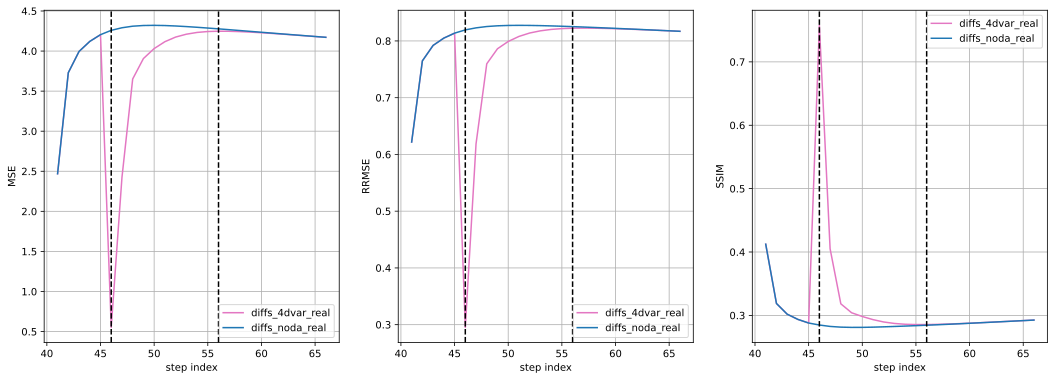

diffs_noda_real_mse[da_idxs[0]]=tensor(4.2584), diffs_noda_real_mse[da_idxs[1]]=tensor(4.2770)
diffs_da_real_mse[da_idxs[0]]=tensor(0.5524), diffs_da_real_mse[da_idxs[1]]=tensor(4.2476)
diffs_noda_real_rrmse[da_idxs[0]]=tensor(0.8195), diffs_noda_real_rrmse[da_idxs[1]]=tensor(0.8253)
diffs_da_real_rrmse[da_idxs[0]]=tensor(0.2952), diffs_da_real_rrmse[da_idxs[1]]=tensor(0.8224)
diffs_noda_real_ssim[da_idxs[0]]=np.float32(0.28480545), diffs_noda_real_ssim[da_idxs[1]]=np.float32(0.28447658)
diffs_da_real_ssim[da_idxs[0]]=np.float32(0.75761265), diffs_da_real_ssim[da_idxs[1]]=np.float32(0.28553855)


In [22]:
step_idxs = list(range(start_da_end_idxs[0] + 1, start_da_end_idxs[-1] + 2))

_, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].plot(step_idxs, diffs_da_real_mse, color="#e377c2", label="diffs_4dvar_real")
ax[0].plot(step_idxs, diffs_noda_real_mse, color="#1f77b4", label="diffs_noda_real")

ax[1].plot(step_idxs, diffs_da_real_rrmse, color="#e377c2", label="diffs_4dvar_real")
ax[1].plot(step_idxs, diffs_noda_real_rrmse, color="#1f77b4", label="diffs_noda_real")

ax[2].plot(step_idxs, diffs_da_real_ssim, color="#e377c2", label="diffs_4dvar_real")
ax[2].plot(step_idxs, diffs_noda_real_ssim, color="#1f77b4", label="diffs_noda_real")

for i, name in enumerate(["MSE", "RRMSE", "SSIM"]):
    ax[i].set_xlabel("step index")
    ax[i].set_ylabel(name)
    ax[i].grid(True)
    ax[i].legend()
    for x in time_obs:
        ax[i].axvline(x=x+1, color="k", linestyle="--")

plt.show()

da_idxs = [5, 15]
print(f"{diffs_noda_real_mse[da_idxs[0]]=}, {diffs_noda_real_mse[da_idxs[1]]=}")
print(f"{diffs_da_real_mse[da_idxs[0]]=}, {diffs_da_real_mse[da_idxs[1]]=}")
print(f"{diffs_noda_real_rrmse[da_idxs[0]]=}, {diffs_noda_real_rrmse[da_idxs[1]]=}")
print(f"{diffs_da_real_rrmse[da_idxs[0]]=}, {diffs_da_real_rrmse[da_idxs[1]]=}")
print(f"{diffs_noda_real_ssim[da_idxs[0]]=}, {diffs_noda_real_ssim[da_idxs[1]]=}")
print(f"{diffs_da_real_ssim[da_idxs[0]]=}, {diffs_da_real_ssim[da_idxs[1]]=}")

45
6569.9585
2300.8003
55
6591.861
6571.1357


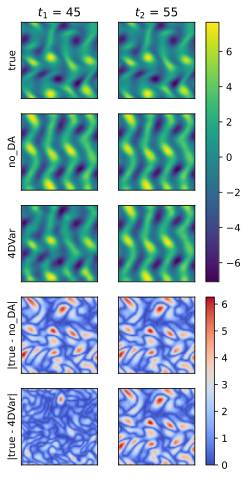

In [23]:
fig, ax = plt.subplots(5, len(da_idxs), figsize=(2 * len(da_idxs), 8), sharex=True)
for x in ax.flat:
    x.set_xticks([])
    x.set_yticks([])
    x.set_xticklabels([])
    x.set_yticklabels([])

setup_cmap = True
with torch.no_grad():
    for i, da_idx in enumerate(da_idxs):
        if i == 0:
            img_tensor = real_img[time_obs[i]+1, 0, ...]
        else:
            img_tensor = real_img[time_obs[i], 0, ...]
        print(time_obs[i])
        im1 = ax[0, i].imshow(torch.reshape(img_tensor, (64, 64)), cmap="viridis")
        if setup_cmap:
            # Create a ScalarMappable object with the colormap from images
            sm1 = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)
        no_da = forward_model.K_S_preimage(outs_no_4d_da[da_idx]).cpu()
        da = forward_model.K_S_preimage(outs_4d_da[da_idx]).cpu()

        de_no_da = denorm(no_da)
        de_da = denorm(da)

        image_noda = de_no_da[0, 0, ...]
        image_da = de_da[0, 0, ...]

        print(np.sum(np.abs(img_tensor.numpy() - image_noda.numpy())))
        print(np.sum(np.abs(img_tensor.numpy() - image_da.numpy())))

        ax[1, i].imshow(torch.reshape(image_noda, (64, 64)), cmap="viridis")
        ax[2, i].imshow(torch.reshape(image_da, (64, 64)), cmap="viridis")
        res = (img_tensor.reshape((64, 64)) - image_noda.reshape((64, 64))).abs()
        res = torch.where(res > 0.1, res, 0)
        im2 = ax[3, i].imshow(res, cmap="coolwarm")
        if setup_cmap:
            sm2 = plt.cm.ScalarMappable(cmap=im2.cmap, norm=im2.norm)
        res = (img_tensor.reshape((64, 64)) - image_da.reshape((64, 64))).abs()
        res = torch.where(res > 0.1, res, 0)
        ax[4, i].imshow(res, cmap="coolwarm")
        setup_cmap = False

for i, title in enumerate([f"$t_1$ = {time_obs[0]}", f"$t_2$ = {time_obs[1]}"]):
    ax[0, i].set_title(title)
# ax[0].set_title("$t$")
for i, ylabel in enumerate(["true", "no_DA", "4DVar", "|true - no_DA|", "|true - 4DVar|"]):
    ax[i, 0].set_ylabel(ylabel)

# # Create a ScalarMappable object with the colormap from images
# sm1 = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)

# Remove the set_array to avoid warning
sm1.set_array([])

# Add a colorbar to the figure that uses the ScalarMappable
# fig.colorbar(sm1, ax=ax, orientation="vertical")

fig.colorbar(sm1, ax=ax[:-2, :], orientation="vertical")
sm2 = plt.cm.ScalarMappable(cmap=im2.cmap, norm=im2.norm)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[-2:, :], orientation="vertical")

plt.show()